In [1]:
# !pip install -q lightgbm

In [2]:
import pandas as pd
import numpy as np
import os
import time
import phik
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(
    style='ticks', 
    context='talk', 
    font_scale=0.8, 
    rc={'figure.figsize': (8,6)}
)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFECV 
from category_encoders import TargetEncoder


from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, mutual_info_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
# get current working directory
os.getcwd()

'c:\\Users\\kings\\OneDrive - MMU\\Downloads\\new projects\\Credit-Score-Data'

### Load Data

In [159]:
def get_data(file):
    current_directory = os.getcwd()
    file_path = current_directory + "\\Credit Score Data\\"
    return pd.read_csv(file_path + file)

In [160]:
df = get_data('train.csv')
df.head()

ID  Customer_ID  Month           Name   Age          SSN Occupation  \
0  5634         3392      1  Aaron Maashoh  23.0  821000265.0  Scientist   
1  5635         3392      2  Aaron Maashoh  23.0  821000265.0  Scientist   
2  5636         3392      3  Aaron Maashoh  23.0  821000265.0  Scientist   
3  5637         3392      4  Aaron Maashoh  23.0  821000265.0  Scientist   
4  5638         3392      5  Aaron Maashoh  23.0  821000265.0  Scientist   

   Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  Credit_Mix  \
0       19114.12            1824.843333                3.0  ...        Good   
1       19114.12            1824.843333                3.0  ...        Good   
2       19114.12            1824.843333                3.0  ...        Good   
3       19114.12            1824.843333                3.0  ...        Good   
4       19114.12            1824.843333                3.0  ...        Good   

   Outstanding_Debt  Credit_Utilization_Ratio Credit_History_Age  \
0            809.98                 26.822620              265.0   
1            809.98                 31.944960              266.0   
2            809.98                 28.609352              267.0   
3            809.98                 31.377862              268.0   
4            809.98                 24.797347              269.0   

   Payment_of_Min_Amount  Total_EMI_per_month  Amount_invested_monthly  \
0                     No            49.574949                 21.46538   
1                     No            49.574949                 21.46538   
2                     No            49.574949                 21.46538   
3                     No            49.574949                 21.46538   
4                     No            49.574949                 21.46538   

                  Payment_Behaviour Monthly_Balance  Credit_Score  
0   High_spent_Small_value_payments      312.494089          Good  
1    Low_spent_Large_value_payments      284.629162          Good  
2   Low_spent_Medium_value_payments      331.209863          Good  
3    Low_spent_Small_value_payments      223.451310          Good  
4  High_spent_Medium_value_payments      341.489231          Good  

[5 rows x 28 columns]

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  int64  
 1   Customer_ID               100000 non-null  int64  
 2   Month                     100000 non-null  int64  
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  float64
 5   SSN                       100000 non-null  float64
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  float64
 10  Num_Credit_Card           100000 non-null  float64
 11  Interest_Rate             100000 non-null  float64
 12  Num_of_Loan               100000 non-null  float64
 13  Type_of_Loan              100000 non-null  ob

In [162]:
# check the shape of the dataset
df.shape

(100000, 28)

In [163]:
# check for missing values
df.isnull().sum()

ID                          0
Customer_ID                 0
Month                       0
Name                        0
Age                         0
SSN                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Type_of_Loan                0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
dtype: int64

In [164]:
# set id column as index
df = df.set_index(df['ID']).drop(columns=['ID'])

In [165]:
# check for duplicated entries
df[df.duplicated()]

Empty DataFrame
Columns: [Customer_ID, Month, Name, Age, SSN, Occupation, Annual_Income, Monthly_Inhand_Salary, Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, Num_of_Loan, Type_of_Loan, Delay_from_due_date, Num_of_Delayed_Payment, Changed_Credit_Limit, Num_Credit_Inquiries, Credit_Mix, Outstanding_Debt, Credit_Utilization_Ratio, Credit_History_Age, Payment_of_Min_Amount, Total_EMI_per_month, Amount_invested_monthly, Payment_Behaviour, Monthly_Balance, Credit_Score]
Index: []

[0 rows x 27 columns]

In [166]:
df.head()

Customer_ID  Month           Name   Age          SSN Occupation  \
ID                                                                      
5634         3392      1  Aaron Maashoh  23.0  821000265.0  Scientist   
5635         3392      2  Aaron Maashoh  23.0  821000265.0  Scientist   
5636         3392      3  Aaron Maashoh  23.0  821000265.0  Scientist   
5637         3392      4  Aaron Maashoh  23.0  821000265.0  Scientist   
5638         3392      5  Aaron Maashoh  23.0  821000265.0  Scientist   

      Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
ID                                                              
5634       19114.12            1824.843333                3.0   
5635       19114.12            1824.843333                3.0   
5636       19114.12            1824.843333                3.0   
5637       19114.12            1824.843333                3.0   
5638       19114.12            1824.843333                3.0   

      Num_Credit_Card  ...  Credit_Mix  Outstanding_Debt  \
ID                     ...                                 
5634              4.0  ...        Good            809.98   
5635              4.0  ...        Good            809.98   
5636              4.0  ...        Good            809.98   
5637              4.0  ...        Good            809.98   
5638              4.0  ...        Good            809.98   

     Credit_Utilization_Ratio  Credit_History_Age  Payment_of_Min_Amount  \
ID                                                                         
5634                26.822620               265.0                     No   
5635                31.944960               266.0                     No   
5636                28.609352               267.0                     No   
5637                31.377862               268.0                     No   
5638                24.797347               269.0                     No   

      Total_EMI_per_month  Amount_invested_monthly  \
ID                                                   
5634            49.574949                 21.46538   
5635            49.574949                 21.46538   
5636            49.574949                 21.46538   
5637            49.574949                 21.46538   
5638            49.574949                 21.46538   

                     Payment_Behaviour  Monthly_Balance  Credit_Score  
ID                                                                     
5634   High_spent_Small_value_payments       312.494089          Good  
5635    Low_spent_Large_value_payments       284.629162          Good  
5636   Low_spent_Medium_value_payments       331.209863          Good  
5637    Low_spent_Small_value_payments       223.451310          Good  
5638  High_spent_Medium_value_payments       341.489231          Good  

[5 rows x 27 columns]

In [167]:
df['Month'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

Some columns won't be neccessary in prediciting categories for Credit Scores. Columns like `Name`, `Customer_ID`, `SSN`

In [168]:
# Drop irrelevant columns
df.drop(columns=['Name','Customer_ID','SSN'], inplace=True)

#### Feature Correlation using `Phik library`

In [169]:
seed = 1234
feat_corr = df.sample(frac=0.1, random_state=seed).phik_matrix()

interval columns not set, guessing: ['Month', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']


<Axes: >

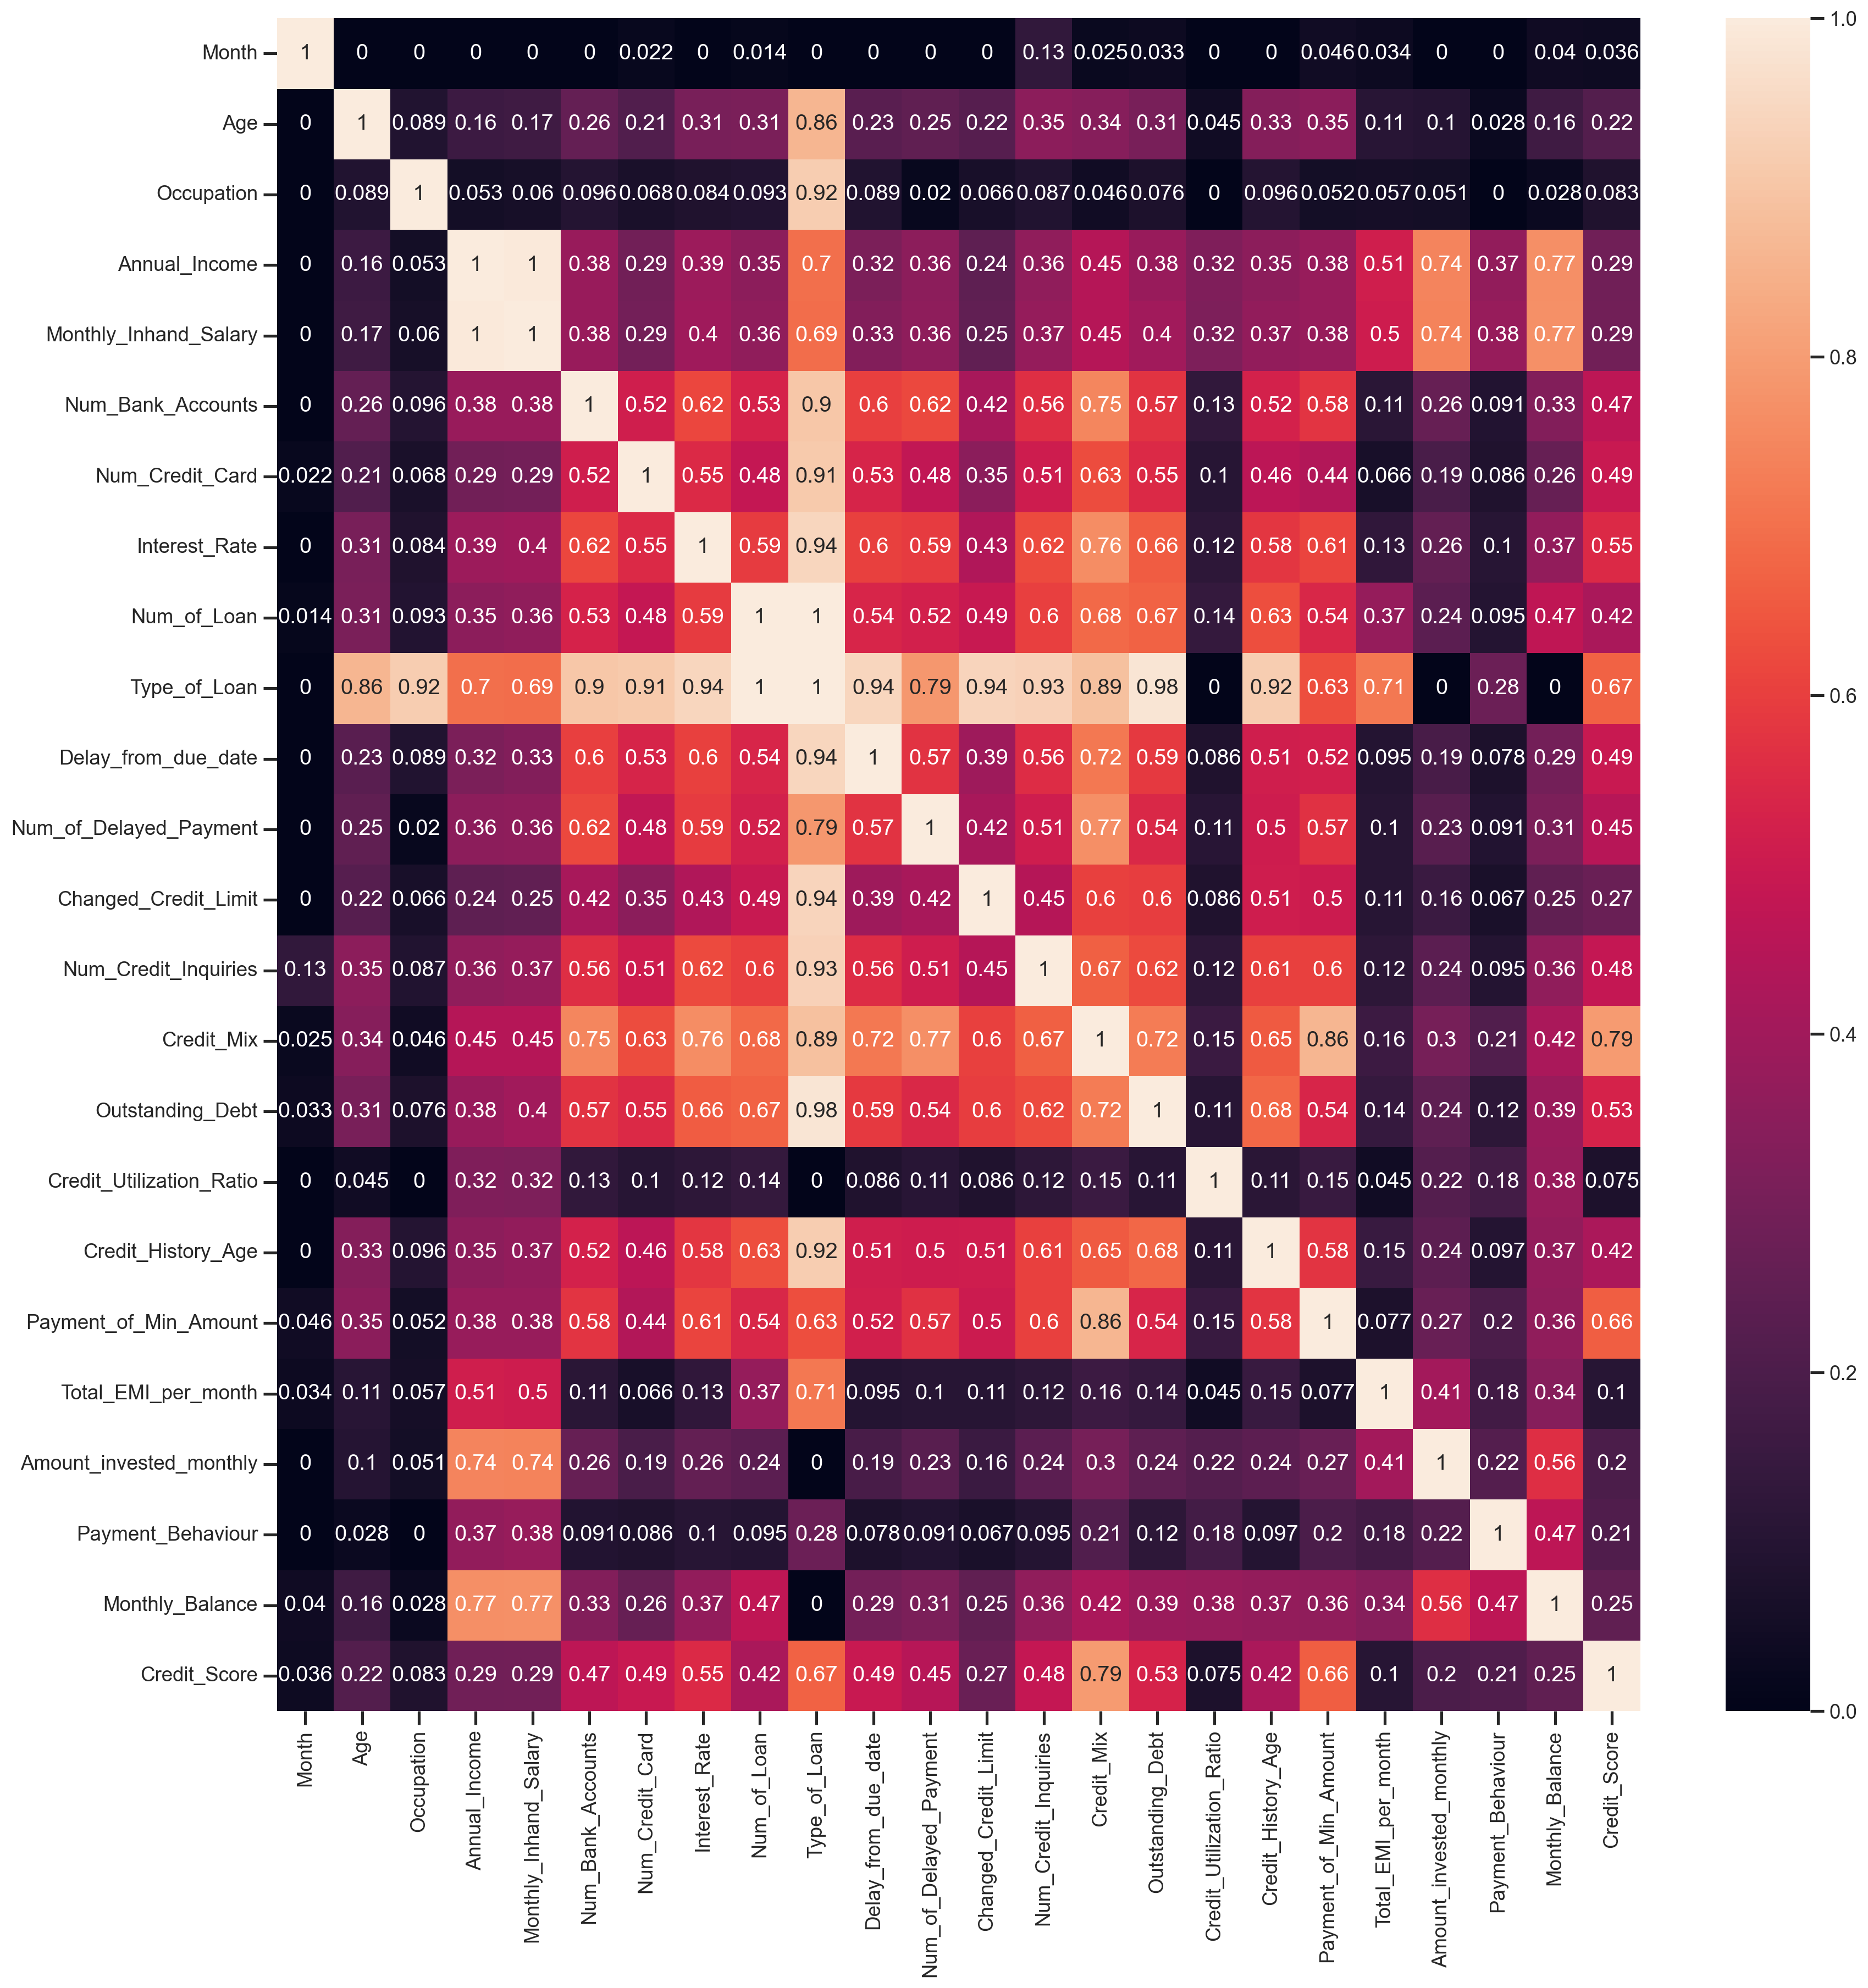

In [170]:
plt.figure(figsize=(20,20))
sns.heatmap(feat_corr, annot=True)

There are several feature selection techniques, however, to gauge the feature importance, the novel correlation coefficient, ϕK's was used so because it is suitable for data sets with mixed variable types, e.g. where some variables are categorical. We can anticipate one variable from another if the two are correlated. As a result, if two features are correlated, the model only actually requires one of them as the other does not provide any new information. Some features have a perfect correlation with each other. Features like `Annual_Income` & `Monthly_Inhand_Salary`, and `Num_of_Loan` & `Type_of_Loan` have a perfect correlation between each other. One of each pairs would be dropped moving forward. The one with the highest correlation with the target will be kept.

In [171]:
df = df.drop(columns=['Monthly_Inhand_Salary', 'Num_of_Loan'])
df.shape

(100000, 22)

Text(0.5, 0, 'phik coefficient')

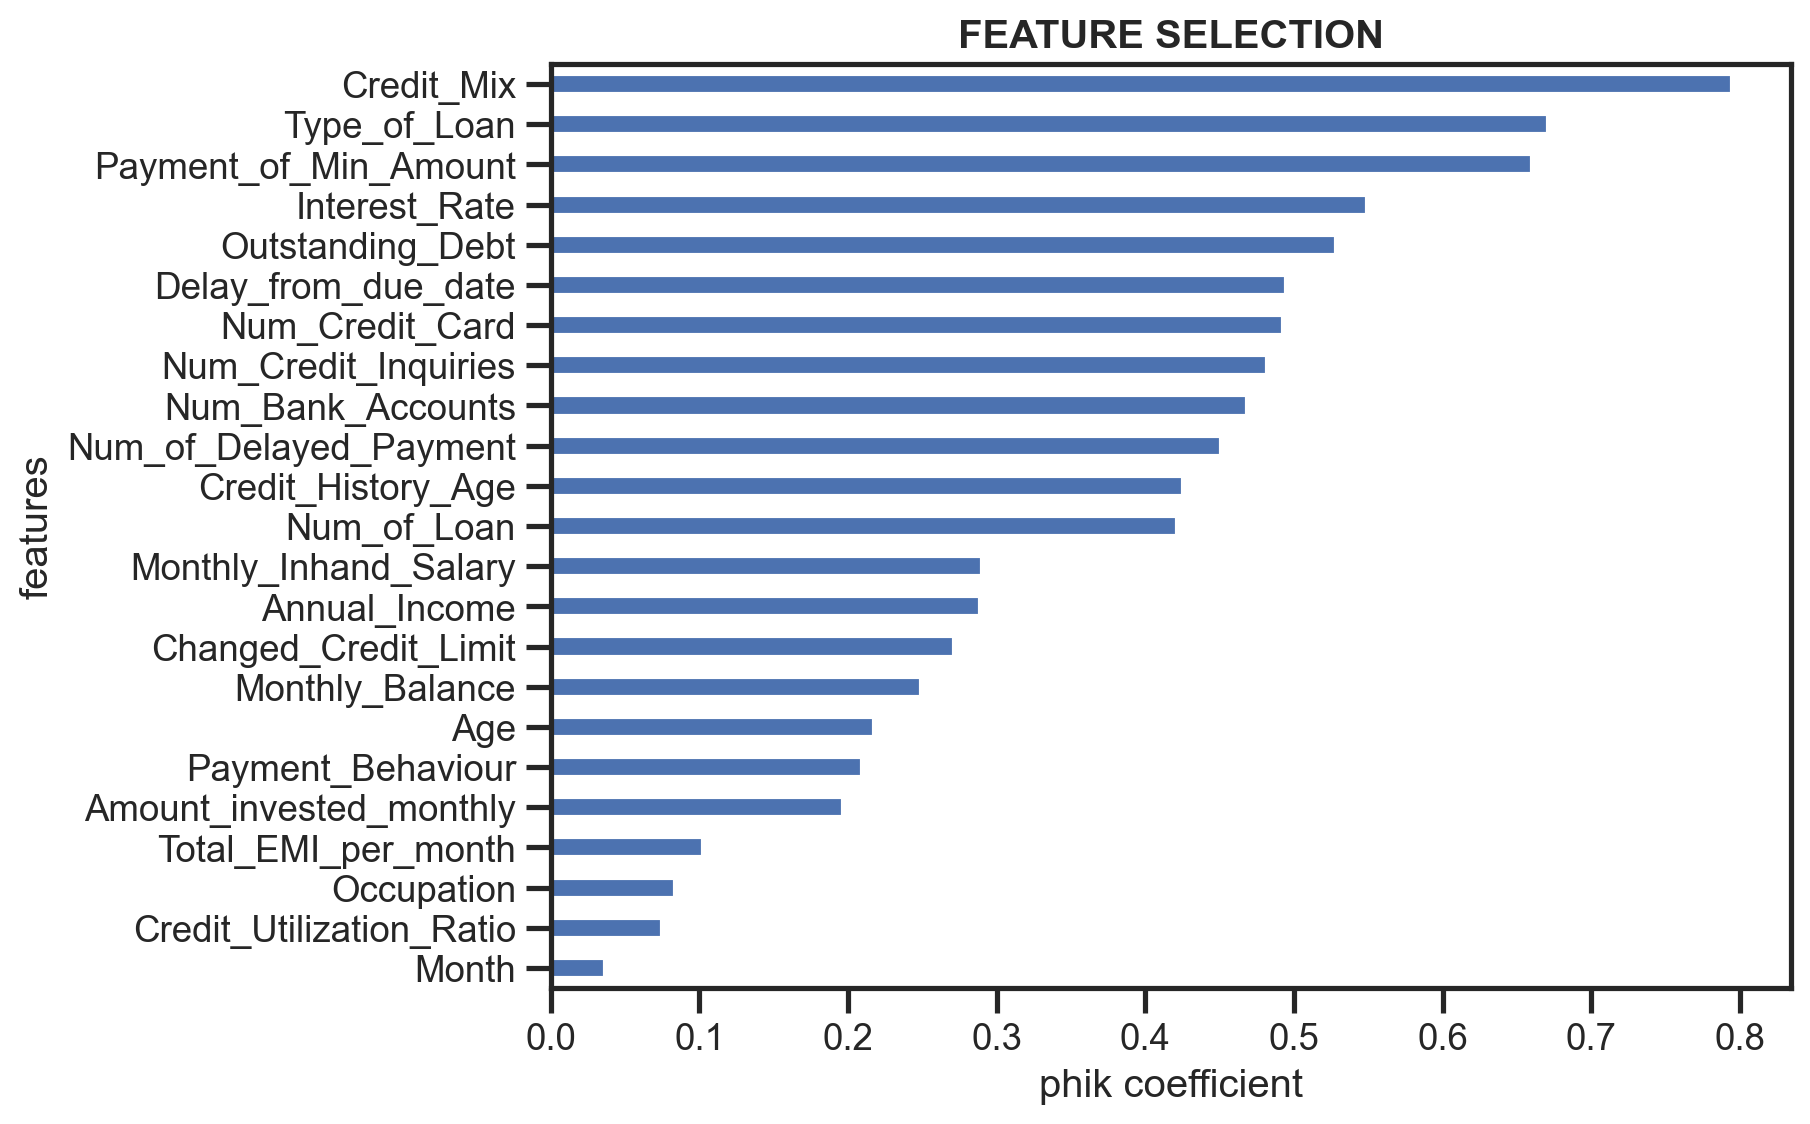

In [172]:
feat_corr['Credit_Score'].drop('Credit_Score').sort_values(ascending=True).plot(kind='barh')
plt.title('feature selection'.upper(),weight='bold')
plt.ylabel('features')
plt.xlabel('phik coefficient')

In [173]:
df['Credit_Score'] = df['Credit_Score'].astype('category').cat.codes

In [174]:
df['Credit_Score'].value_counts()

2    53174
1    28998
0    17828
Name: Credit_Score, dtype: int64

Making use of all 6000+ categories in `Type of Loan` column

In [175]:
cat_feat = [i for i in df.columns if df[i].dtype == 'O']
num_feat = [i for i in df.columns if i not in cat_feat]
print(len(cat_feat),' ',cat_feat)
print(' ')
num_feat.pop(-1)
print(len(num_feat),' ',num_feat)


5   ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
 
16   ['Month', 'Age', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']


Using Mutual Information to measure the IMPORTANCE OF CATEGORICAL FEATURES

In [176]:
mutual_score = []
for i in df[cat_feat].columns:
    mutual_score.append(mutual_info_score(df[i], df['Credit_Score']))

In [177]:
mutual_score

[0.0009226598871364122,
 0.36628704510869975,
 0.18765660504153825,
 0.10472066055141431,
 0.007793381392433171]

In [178]:
mutual_score_df  = pd.DataFrame(mutual_score, df[cat_feat].columns.tolist())
mutual_score_df.columns = ['mutual_score']

In [179]:
mutual_score_df = mutual_score_df.sort_values(by='mutual_score', ascending=False)

In [180]:
mutual_score_df

mutual_score
Type_of_Loan               0.366287
Credit_Mix                 0.187657
Payment_of_Min_Amount      0.104721
Payment_Behaviour          0.007793
Occupation                 0.000923

Using Pearson correlation to measure the IMPORTANCE OF NUMERICAL FEATURES

In [181]:
df[num_feat].corrwith(df['Credit_Score']).sort_values(ascending=False)

Num_of_Delayed_Payment      0.203116
Changed_Credit_Limit        0.190080
Num_Bank_Accounts           0.177389
Interest_Rate               0.121088
Num_Credit_Card             0.113333
Delay_from_due_date         0.097286
Num_Credit_Inquiries        0.067845
Outstanding_Debt            0.037153
Credit_Utilization_Ratio   -0.014371
Month                      -0.038069
Monthly_Balance            -0.047380
Age                        -0.058923
Total_EMI_per_month        -0.059341
Amount_invested_monthly    -0.068770
Annual_Income              -0.080700
Credit_History_Age         -0.102598
dtype: float64

In [182]:
features = ['Month','Age','Annual_Income', 'Num_Bank_Accounts','Num_Credit_Card','Interest_Rate','Delay_from_due_date','Num_of_Delayed_Payment',
 'Changed_Credit_Limit','Num_Credit_Inquiries','Outstanding_Debt','Credit_History_Age','Total_EMI_per_month',
 'Amount_invested_monthly','Monthly_Balance','Type_of_Loan','Credit_Mix','Payment_of_Min_Amount']

In [184]:
X, y = df[features],df['Credit_Score']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=seed)

In [185]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 18), (20000, 18), (80000,), (20000,))

In [186]:
def check_num_unique_cats(col_lst):
    for i in range(len(col_lst)):
        result = df[col_lst[i]].nunique()
        print(col_lst[i])
        print(result)
check_num_unique_cats(cat_feat)

Occupation
15
Type_of_Loan
6261
Credit_Mix
3
Payment_of_Min_Amount
3
Payment_Behaviour
6


`Type_of_Loan` has so many catregories, we will use Target encoding for encoding the variables 

In [187]:
encoder = TargetEncoder(cols=['Type_of_Loan']).fit(X_train, y_train) 
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [188]:
X_train.head()

Month   Age  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
ID                                                                       
94774       5  41.0      70154.850                8.0              5.0   
83569       8  54.0      29508.410                7.0              4.0   
100414      5  19.0      31346.220                8.0              5.0   
155051      6  32.0      64901.370                3.0              5.0   
92338       5  32.0       7200.035                8.0              8.0   

        Interest_Rate  Delay_from_due_date  Num_of_Delayed_Payment  \
ID                                                                   
94774            18.0                 27.0                     8.0   
83569             9.0                 18.0                    11.0   
100414           31.0                 44.0                    17.0   
155051           20.0                 15.0                    18.0   
92338            18.0                 60.0                    17.0   

        Changed_Credit_Limit  Num_Credit_Inquiries  Outstanding_Debt  \
ID                                                                     
94774                  19.23                   0.0            487.42   
83569                  10.75                   4.0            333.86   
100414                  3.76                  12.0           1795.98   
155051                  2.94                   3.0            442.06   
92338                   8.51                  11.0           2442.56   

        Credit_History_Age  Total_EMI_per_month  Amount_invested_monthly  \
ID                                                                         
94774                252.0            92.888270                51.510408   
83569                237.0            16.547212                32.351596   
100414               107.0           187.425136                32.206483   
155051               375.0             0.000000                62.392675   
92338                170.0            13.723019                20.544565   

        Monthly_Balance  Type_of_Loan Credit_Mix Payment_of_Min_Amount  
ID                                                                      
94774        629.102942      1.313830   Standard                   Yes  
83569        448.704608      1.266599   Standard                    No  
100414       238.969130      1.309262        Bad                   Yes  
155051       691.984837      1.281151   Standard                   Yes  
92338        294.975524      1.313031   Standard                   Yes

### Create preprocessing Pipeline

In [34]:
def preprocessor_pipe():
    numeric_features = X_train.select_dtypes(exclude='object').columns.tolist()
    numeric_transformer = Pipeline(
        steps=[
            # its a good practice to do the polynomial/interaction feature generation before scaling.
            ("poly_int", PolynomialFeatures(interaction_only=True, include_bias=False)),
            ("scaler", StandardScaler())
        ]
    ).set_output(transform='pandas')

    categorical_features = X_train.select_dtypes(include='object').columns.tolist()
    categorical_transformer = Pipeline(
        steps=[
            ("ohe", OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False, drop='if_binary')),
        ]
    ).set_output(transform='pandas')

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")

    return preprocessor

In [35]:
preprocessor = preprocessor_pipe() 
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [36]:
X_train_preprocessed.head()

Month       Age  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
ID                                                                              
94774   0.221838  0.716776       0.515418           1.014834        -0.260508   
83569   1.531871  1.925477      -0.547024           0.629120        -0.744118   
100414  0.221838 -1.328718      -0.498987           1.014834        -0.260508   
155051  0.658515 -0.120017       0.378099          -0.913739        -0.260508   
92338   0.221838 -0.120017      -1.130135           1.014834         1.190320   

        Interest_Rate  Delay_from_due_date  Num_of_Delayed_Payment  \
ID                                                                   
94774        0.395840             0.399309               -0.853053   
83569       -0.632929            -0.208510               -0.371463   
100414       1.881841             1.547413                0.591718   
155051       0.624456            -0.411116                0.752248   
92338        0.395840             2.627980                0.591718   

        Changed_Credit_Limit  Num_Credit_Inquiries  ...  \
ID                                                  ...   
94774               1.321152             -1.499988  ...   
83569               0.038994             -0.466088  ...   
100414             -1.017879              1.601711  ...   
155051             -1.141861             -0.724563  ...   
92338              -0.299689              1.343236  ...   

        Total_EMI_per_month Type_of_Loan  \
ID                                         
94774                          -0.129068   
83569                          -0.706954   
100414                          0.576130   
155051                         -0.826777   
92338                          -0.723762   

        Amount_invested_monthly Monthly_Balance  \
ID                                                
94774                                  0.228207   
83569                                 -0.349642   
100414                                -0.569939   
155051                                 0.576079   
92338                                 -0.622792   

        Amount_invested_monthly Type_of_Loan  Monthly_Balance Type_of_Loan  \
ID                                                                           
94774                              -0.110702                      1.140759   
83569                              -0.624595                      0.170592   
100414                             -0.601686                     -0.789242   
155051                              0.125241                      1.366209   
92338                              -0.894073                     -0.509550   

        Credit_Mix_Bad  Credit_Mix_Good  Credit_Mix_Standard  \
ID                                                             
94774              0.0              0.0                  1.0   
83569              0.0              0.0                  1.0   
100414             1.0              0.0                  0.0   
155051             0.0              0.0                  1.0   
92338              0.0              0.0                  1.0   

        Payment_of_Min_Amount_NM  Payment_of_Min_Amount_No  \
ID                                                           
94774                        0.0                       0.0   
83569                        0.0                       1.0   
100414                       0.0                       0.0   
155051                       0.0                       0.0   
92338                        0.0                       0.0   

        Payment_of_Min_Amount_Yes  
ID                                 
94774                         1.0  
83569                         0.0  
100414                        1.0  
155051                        1.0  
92338                         1.0  

[5 rows x 142 columns]

### Trying out Principal Component Analysis using the pre processed data set

In [37]:
X_pca = PCA()
X_pca.fit(X_train_preprocessed)

PCA()

In [38]:
X_pca.explained_variance_ratio_

array([3.05902847e-01, 1.67548760e-01, 6.33398485e-02, 5.48743121e-02,
       5.16140514e-02, 4.10828370e-02, 3.58127241e-02, 2.95273752e-02,
       2.93309869e-02, 2.73566100e-02, 2.61551090e-02, 2.36168170e-02,
       2.13089878e-02, 2.01793606e-02, 1.28329469e-02, 9.94478246e-03,
       9.20381284e-03, 5.77244709e-03, 4.54768978e-03, 3.76437593e-03,
       3.03061314e-03, 2.42297772e-03, 2.32021253e-03, 2.21034277e-03,
       2.01455163e-03, 1.98177528e-03, 1.95902417e-03, 1.84797157e-03,
       1.72745040e-03, 1.67789279e-03, 1.56872601e-03, 1.49456436e-03,
       1.42954202e-03, 1.27725122e-03, 1.20812020e-03, 1.15788552e-03,
       1.06447186e-03, 9.55323563e-04, 8.86283395e-04, 8.75874021e-04,
       8.32434141e-04, 8.01552168e-04, 7.63140728e-04, 7.51413018e-04,
       7.02171058e-04, 6.91856940e-04, 6.51604037e-04, 6.11599178e-04,
       5.68143449e-04, 5.24214229e-04, 4.99999741e-04, 4.96108917e-04,
       4.78108909e-04, 4.74835255e-04, 4.47845488e-04, 4.43850049e-04,
      

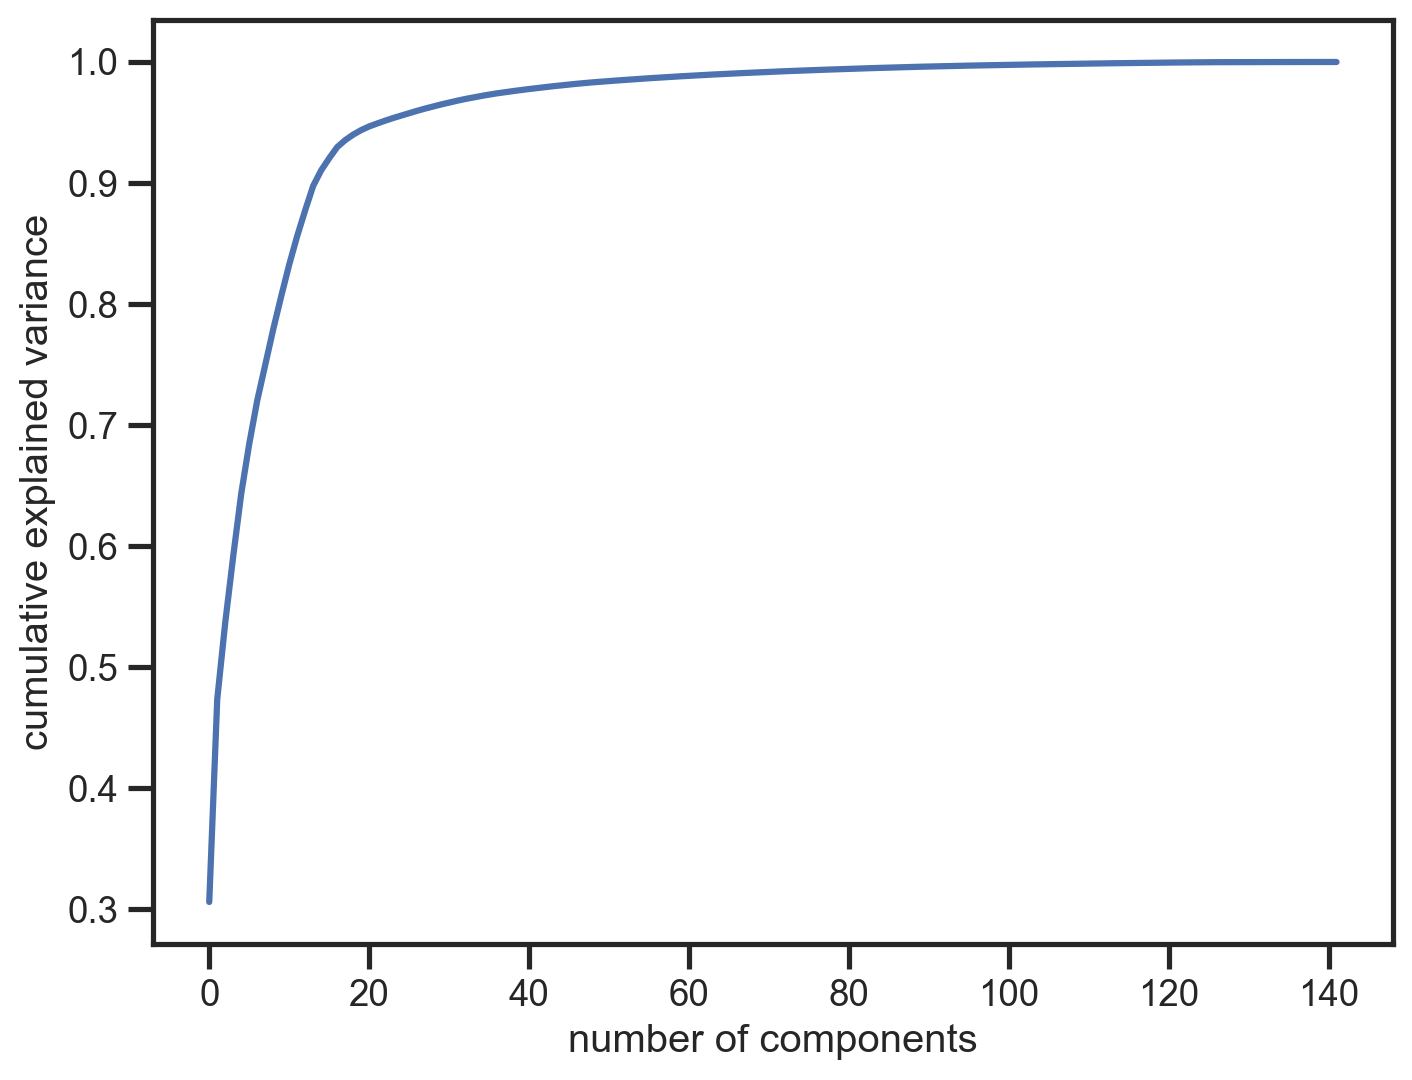

In [39]:
plt.plot(np.cumsum(X_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

 n_components=0.95. This will select the number of components while preserving 95% of the variability in the data.

In [40]:
X_pca = PCA(n_components=0.95,random_state=seed)
X_pca.fit(X_train_preprocessed)
pca_X = X_pca.transform(X_train_preprocessed)
pca_test = X_pca.transform(X_test_preprocessed)

In [41]:
pca_X.shape

(80000, 23)

In [42]:
components = []
for i in range(1,pca_X.shape[1]+1):
    components.append('component'+str(i))    

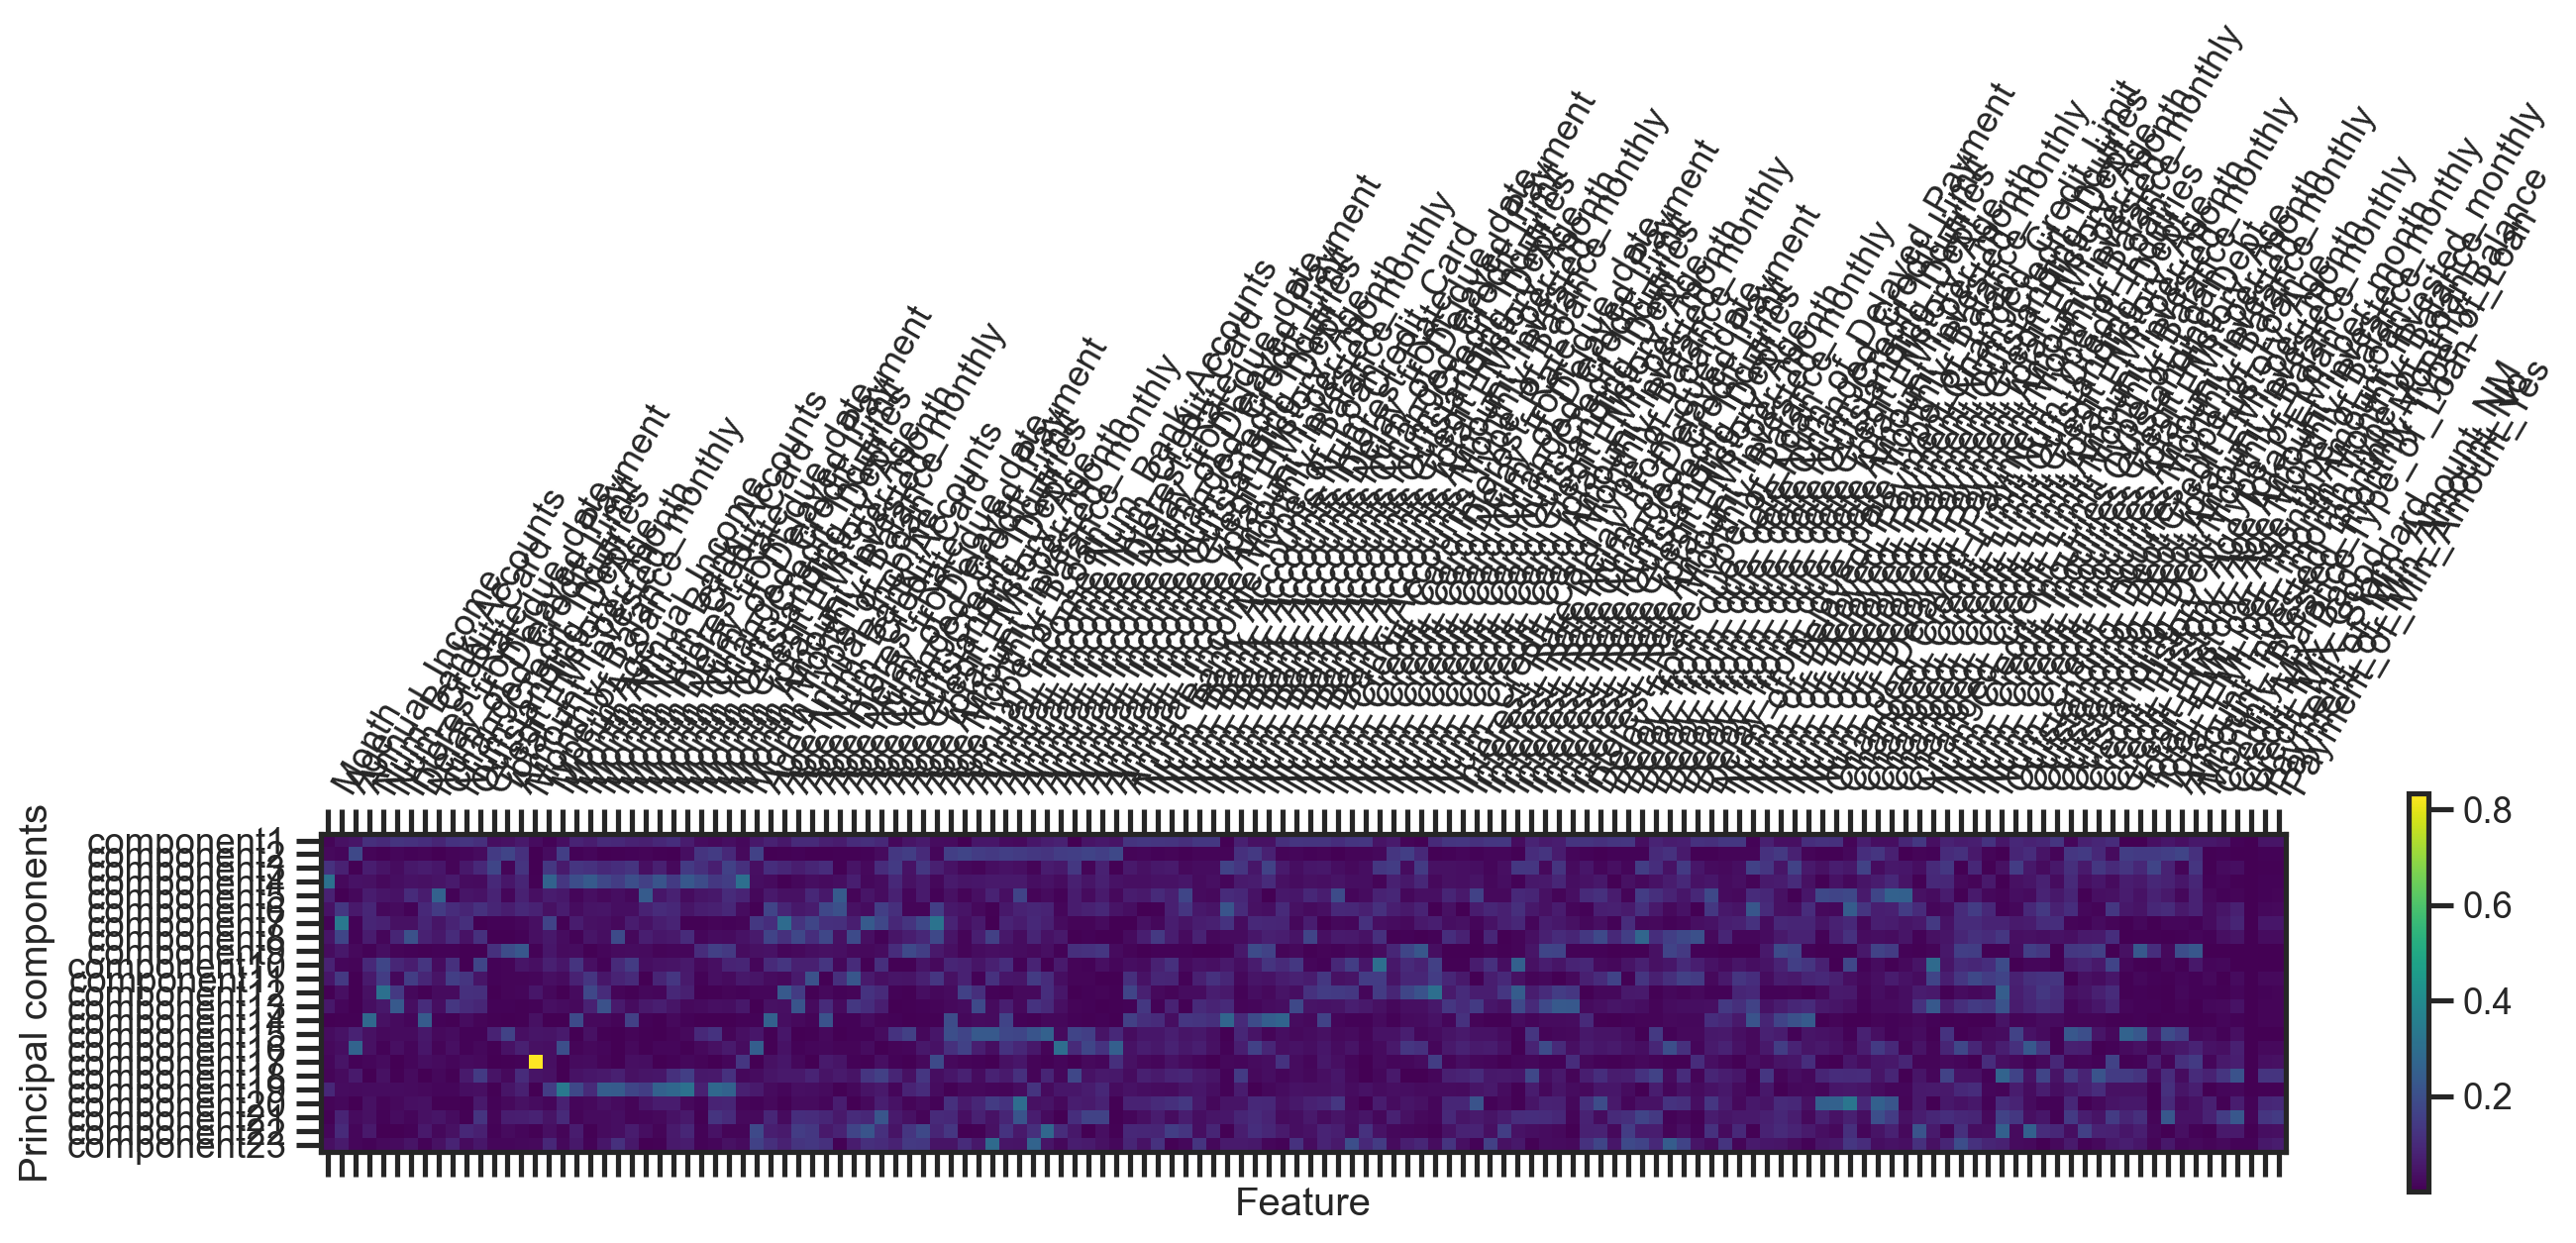

In [43]:
## The Influence of the Features in the Components
plt.matshow(np.abs(X_pca.components_)[:pca_X.shape[1]], cmap='viridis')
plt.yticks(range(pca_X.shape[1]), components)
plt.colorbar()
plt.xticks(range(len(X_train_preprocessed.columns)),
           X_train_preprocessed.columns, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components");

### Model fitting on PCA components

In [44]:
def model_selection(xtrain,xtest,ytrain,ytest):
    models = {
        'logistic_regression':{
            'model':LogisticRegression()
        },
        'random_forest':{
            'model':RandomForestClassifier(random_state=seed)
        },
       'catboost':{
            'model':CatBoostClassifier(verbose=False,random_state=seed)
        },
        'decisontree':{
            'model': DecisionTreeClassifier(random_state=seed)
        },
        'extratree':{
            'model': ExtraTreesClassifier(random_state=seed)
        },
        'xgb':{
            'model': XGBClassifier(random_state=seed)
        },
        'lgbm':{
            'model': LGBMClassifier(random_state=seed)
        }
    }

    scores = []
    for model_name, config in models.items():
        start = time.time()
        config['model'].fit(xtrain, ytrain)
        y_pred = config['model'].predict(xtest) 
        train_score = config['model'].score(xtrain, ytrain)
        balanced_acc = balanced_accuracy_score(ytest, y_pred)
        acc = accuracy_score(ytest, y_pred)
        precision = precision_score(ytest, y_pred, average='weighted')
        end = time.time()
        elasped_time = end - start
        scores.append({
            'model': model_name,
            'train_score':train_score,
            'balanced_acc':balanced_acc,
            'acc':acc,
            'precision':precision,
            'time_taken':elasped_time})

    return pd.DataFrame(scores,columns=['model','train_score','balanced_acc','acc','precision','time_taken'])

In [45]:
result_pca= model_selection(pca_X, pca_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 23
[LightGBM] [Info] Start training from score -1.729066
[LightGBM] [Info] Start training from score -1.236195
[LightGBM] [Info] Start training from score -0.630994


In [46]:
result_pca.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc      acc  precision  \
4            extratree     1.000000      0.776302  0.79805   0.797645   
1        random_forest     1.000000      0.761901  0.78440   0.783812   
5                  xgb     0.848650      0.735160  0.75955   0.758940   
2             catboost     0.821400      0.734255  0.75750   0.757001   
6                 lgbm     0.783238      0.715511  0.74365   0.742929   
3          decisontree     1.000000      0.664720  0.68960   0.689303   
0  logistic_regression     0.704263      0.638801  0.68420   0.683373   

   time_taken  
4   15.166666  
1   62.884204  
5    2.884086  
2   32.068882  
6    2.947221  
3    3.676291  
0    1.786009

Run the entire dataset (`X_train_preprocessed`) on different models

In [47]:
result_whole = model_selection(X_train_preprocessed, X_test_preprocessed, y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30850
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 142
[LightGBM] [Info] Start training from score -1.729066
[LightGBM] [Info] Start training from score -1.236195
[LightGBM] [Info] Start training from score -0.630994


In [48]:
result_whole.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc      acc  precision  \
1        random_forest     0.999975      0.831744  0.83275   0.833572   
4            extratree     1.000000      0.822199  0.82700   0.827358   
5                  xgb     0.889487      0.803684  0.80780   0.808389   
2             catboost     0.849400      0.781906  0.79190   0.792101   
6                 lgbm     0.827475      0.777342  0.78350   0.784823   
3          decisontree     1.000000      0.762911  0.77700   0.776708   
0  logistic_regression     0.739950      0.697029  0.72105   0.721326   

   time_taken  
1  110.512677  
4   35.082296  
5   11.606032  
2   95.009384  
6    9.680330  
3   14.470236  
0    9.077254

### Automated Feature Selection Using Recursive Feature Elimination with Cross-Validation (RFECV)

In [49]:
model = LogisticRegression()
ref_selector = RFECV(model, step=1, cv=10)

In [50]:
ref_selector.fit(X_train_preprocessed, y_train)

RFECV(cv=10, estimator=LogisticRegression())

In [51]:
n_scores = len(ref_selector.cv_results_["mean_test_score"])
n_scores

142

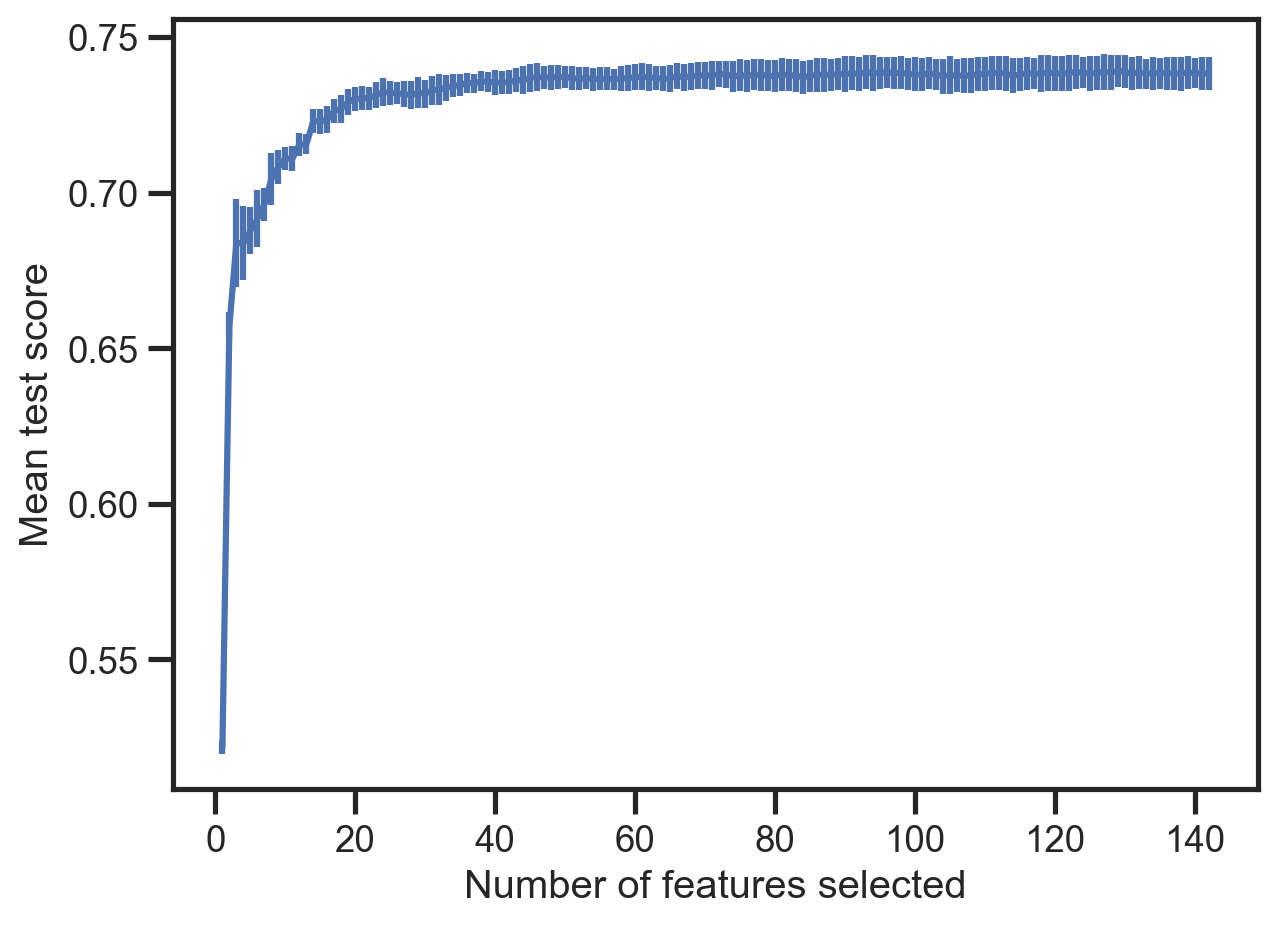

In [52]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(
    range(1, n_scores+1),
    ref_selector.cv_results_["mean_test_score"],
    yerr=ref_selector.cv_results_["std_test_score"],
)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test score");

In [53]:
pd.DataFrame(ref_selector.cv_results_["mean_test_score"],range(1, n_scores+1)).sort_values(by=0,ascending=False).head()

0
129  0.739138
130  0.738913
127  0.738850
123  0.738787
93   0.738738

In [54]:
# Get the indices of the top performing features
top_features_idx = ref_selector.get_support(indices=True)

# Get the names of the top performing features
top_features_names = X_train_preprocessed.columns[top_features_idx]

# Print the top performing features
print("Top performing features:")
print(len(top_features_names))


Top performing features:
129


In [55]:
top_features_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  38,  39,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  51,  52,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  66,  68,  69,  70,  71,
        72,  73,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141],
      dtype=int64)

In [56]:
X_train_preprocessed.columns[top_features_idx]

Index(['Month', 'Age', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries',
       ...
       'Total_EMI_per_month Type_of_Loan',
       'Amount_invested_monthly Monthly_Balance',
       'Amount_invested_monthly Type_of_Loan', 'Monthly_Balance Type_of_Loan',
       'Credit_Mix_Bad', 'Credit_Mix_Good', 'Credit_Mix_Standard',
       'Payment_of_Min_Amount_NM', 'Payment_of_Min_Amount_No',
       'Payment_of_Min_Amount_Yes'],
      dtype='object', length=129)

### Model fitting and prediction on top selected features by REFCV

In [57]:
result_refcv_full = model_selection(X_train_preprocessed[top_features_names], X_test_preprocessed[top_features_names], y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27706
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 129
[LightGBM] [Info] Start training from score -1.729066
[LightGBM] [Info] Start training from score -1.236195
[LightGBM] [Info] Start training from score -0.630994


In [58]:
result_refcv_full.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc      acc  precision  \
1        random_forest     0.999962      0.830309  0.83180   0.832484   
4            extratree     1.000000      0.822184  0.82730   0.827644   
5                  xgb     0.890338      0.800571  0.80570   0.806136   
2             catboost     0.847850      0.780305  0.78995   0.790110   
6                 lgbm     0.826738      0.775477  0.78225   0.783463   
3          decisontree     1.000000      0.761532  0.77765   0.777263   
0  logistic_regression     0.740062      0.697029  0.72090   0.721419   

   time_taken  
1  111.665174  
4   34.947170  
5   10.571965  
2   91.791496  
6    9.004287  
3   12.857072  
0    8.431435

### Model fitting on top 51 selected features using SelectKbest

In [60]:
selector = SelectKBest(f_classif, k=129).fit(X_train_preprocessed, y_train)
X_sel = selector.transform(X_train_preprocessed)
auto_select = pd.DataFrame(X_sel, columns=selector.get_feature_names_out()).columns

In [61]:
auto_select = auto_select.tolist()

In [62]:
result_selectkbest = model_selection(X_train_preprocessed[auto_select], X_test_preprocessed[auto_select], y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28034
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 129
[LightGBM] [Info] Start training from score -1.729066
[LightGBM] [Info] Start training from score -1.236195
[LightGBM] [Info] Start training from score -0.630994


### Comparing metrics between whole dataset, pca components, slekectKbest and REFCV features

In [63]:
result_pca.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc      acc  precision  \
4            extratree     1.000000      0.776302  0.79805   0.797645   
1        random_forest     1.000000      0.761901  0.78440   0.783812   
5                  xgb     0.848650      0.735160  0.75955   0.758940   
2             catboost     0.821400      0.734255  0.75750   0.757001   
6                 lgbm     0.783238      0.715511  0.74365   0.742929   
3          decisontree     1.000000      0.664720  0.68960   0.689303   
0  logistic_regression     0.704263      0.638801  0.68420   0.683373   

   time_taken  
4   15.166666  
1   62.884204  
5    2.884086  
2   32.068882  
6    2.947221  
3    3.676291  
0    1.786009

In [64]:
result_selectkbest.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc      acc  precision  \
1        random_forest     0.999962      0.823975  0.82770   0.828218   
4            extratree     1.000000      0.820765  0.82620   0.826560   
5                  xgb     0.886500      0.800352  0.80520   0.805742   
2             catboost     0.847025      0.779479  0.78965   0.789862   
6                 lgbm     0.824375      0.773499  0.78005   0.781449   
3          decisontree     1.000000      0.750347  0.76570   0.765425   
0  logistic_regression     0.737800      0.695409  0.71945   0.720087   

   time_taken  
1  115.086797  
4   47.364749  
5   10.578199  
2  123.853632  
6    8.478257  
3   19.566544  
0    8.346350

In [65]:
result_whole.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc      acc  precision  \
1        random_forest     0.999975      0.831744  0.83275   0.833572   
4            extratree     1.000000      0.822199  0.82700   0.827358   
5                  xgb     0.889487      0.803684  0.80780   0.808389   
2             catboost     0.849400      0.781906  0.79190   0.792101   
6                 lgbm     0.827475      0.777342  0.78350   0.784823   
3          decisontree     1.000000      0.762911  0.77700   0.776708   
0  logistic_regression     0.739950      0.697029  0.72105   0.721326   

   time_taken  
1  110.512677  
4   35.082296  
5   11.606032  
2   95.009384  
6    9.680330  
3   14.470236  
0    9.077254

In [66]:
result_refcv_full.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc      acc  precision  \
1        random_forest     0.999962      0.830309  0.83180   0.832484   
4            extratree     1.000000      0.822184  0.82730   0.827644   
5                  xgb     0.890338      0.800571  0.80570   0.806136   
2             catboost     0.847850      0.780305  0.78995   0.790110   
6                 lgbm     0.826738      0.775477  0.78225   0.783463   
3          decisontree     1.000000      0.761532  0.77765   0.777263   
0  logistic_regression     0.740062      0.697029  0.72090   0.721419   

   time_taken  
1  111.665174  
4   34.947170  
5   10.571965  
2   91.791496  
6    9.004287  
3   12.857072  
0    8.431435

Reducing the categories in the `Type of Loan` columns and perform one hot encoding on the categories left.

In [189]:
df['Type_of_Loan'].nunique()

6261

In [190]:
df['Type_of_Loan'].value_counts().head(20)

No Data                                     11408
Not Specified                                1408
Credit-Builder Loan                          1280
Personal Loan                                1272
Debt Consolidation Loan                      1264
Student Loan                                 1240
Payday Loan                                  1200
Mortgage Loan                                1176
Auto Loan                                    1152
Home Equity Loan                             1136
Personal Loan, and Student Loan               320
Not Specified, and Payday Loan                272
Mortgage Loan, and Home Equity Loan           264
Student Loan, and Payday Loan                 256
Student Loan, and Credit-Builder Loan         248
Credit-Builder Loan, and Not Specified        248
Payday Loan, and Debt Consolidation Loan      240
Payday Loan, and Auto Loan                    240
Mortgage Loan, and Not Specified              232
Payday Loan, and Personal Loan                232


In [191]:
df.loc[df['Type_of_Loan']=='No Data', 'Type_of_Loan'] = 'Not Specified'

In [192]:
df['Type_of_Loan'].value_counts().head(20)

Not Specified                               12816
Credit-Builder Loan                          1280
Personal Loan                                1272
Debt Consolidation Loan                      1264
Student Loan                                 1240
Payday Loan                                  1200
Mortgage Loan                                1176
Auto Loan                                    1152
Home Equity Loan                             1136
Personal Loan, and Student Loan               320
Not Specified, and Payday Loan                272
Mortgage Loan, and Home Equity Loan           264
Student Loan, and Payday Loan                 256
Credit-Builder Loan, and Not Specified        248
Student Loan, and Credit-Builder Loan         248
Payday Loan, and Auto Loan                    240
Payday Loan, and Debt Consolidation Loan      240
Payday Loan, and Student Loan                 232
Personal Loan, and Credit-Builder Loan        232
Mortgage Loan, and Not Specified              232


<font size="3">I need to replace the the **and** with **,** so as to get all types of loans into a different column

In [193]:
df['Type_of_Loan'] = df['Type_of_Loan'].apply(lambda x: str(x).replace('and',''))

In [194]:
df['Type_of_Loan'].value_counts()

Not Specified                                                                                                                      12816
Credit-Builder Loan                                                                                                                 1280
Personal Loan                                                                                                                       1272
Debt Consolidation Loan                                                                                                             1264
Student Loan                                                                                                                        1240
                                                                                                                                   ...  
Not Specified, Mortgage Loan, Auto Loan,  Payday Loan                                                                                  8
Payday Loan, Mortgage Loan, Debt Consolid

In [195]:
# loop through the loans list and check if there's the exact string in the columns./
# if yes, create a new column and add the count
df['CreditBuilder'] = df['Type_of_Loan'].apply(lambda x: 1 if "Credit-Builder Loan" in str(x).split(',') else 0)
df['Personal'] = df['Type_of_Loan'].apply(lambda x: 1 if "Personal Loan" in str(x).split(',') else 0)
df['DebtConsolidation'] = df['Type_of_Loan'].apply(lambda x: 1 if "Debt Consolidation Loan" in str(x).split(',') else 0)
df['Student'] = df['Type_of_Loan'].apply(lambda x: 1 if "Student Loan" in str(x).split(',') else 0) 
df['Payday'] = df['Type_of_Loan'].apply(lambda x: 1 if "Payday Loan" in str(x).split(',') else 0)
df['Mortgage'] = df['Type_of_Loan'].apply(lambda x: 1 if "Mortgage Loan" in str(x).split(',') else 0)
df['Auto'] = df['Type_of_Loan'].apply(lambda x: 1 if "Auto Loan" in str(x).split(',') else 0)
df['HomeEquity'] = df['Type_of_Loan'].apply(lambda x: 1 if "Home Equity Loan" in str(x).split(',') else 0)

In [197]:
features.extend(df.columns[-8:])

In [199]:
df[features]

Month   Age  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
ID                                                                       
5634        1  23.0       19114.12                3.0              4.0   
5635        2  23.0       19114.12                3.0              4.0   
5636        3  23.0       19114.12                3.0              4.0   
5637        4  23.0       19114.12                3.0              4.0   
5638        5  23.0       19114.12                3.0              4.0   
...       ...   ...            ...                ...              ...   
155625      4  25.0       39628.99                4.0              6.0   
155626      5  25.0       39628.99                4.0              6.0   
155627      6  25.0       39628.99                4.0              6.0   
155628      7  25.0       39628.99                4.0              6.0   
155629      8  25.0       39628.99                4.0              6.0   

        Interest_Rate  Delay_from_due_date  Num_of_Delayed_Payment  \
ID                                                                   
5634              3.0                  3.0                     7.0   
5635              3.0                  3.0                     4.0   
5636              3.0                  3.0                     7.0   
5637              3.0                  5.0                     4.0   
5638              3.0                  6.0                     4.0   
...               ...                  ...                     ...   
155625            7.0                 23.0                     7.0   
155626            7.0                 18.0                     7.0   
155627            7.0                 27.0                     6.0   
155628            7.0                 20.0                     6.0   
155629            7.0                 18.0                     6.0   

        Changed_Credit_Limit  Num_Credit_Inquiries  ...  Credit_Mix  \
ID                                                  ...               
5634                   11.27                   4.0  ...        Good   
5635                   11.27                   4.0  ...        Good   
5636                   11.27                   4.0  ...        Good   
5637                    6.27                   4.0  ...        Good   
5638                   11.27                   4.0  ...        Good   
...                      ...                   ...  ...         ...   
155625                 11.50                   3.0  ...        Good   
155626                 11.50                   3.0  ...        Good   
155627                 11.50                   3.0  ...        Good   
155628                 11.50                   3.0  ...        Good   
155629                 11.50                   3.0  ...        Good   

        Payment_of_Min_Amount  CreditBuilder  Personal  DebtConsolidation  \
ID                                                                          
5634                       No              0         0                  0   
5635                       No              0         0                  0   
5636                       No              0         0                  0   
5637                       No              0         0                  0   
5638                       No              0         0                  0   
...                       ...            ...       ...                ...   
155625                     No              0         0                  0   
155626                     No              0         0                  0   
155627                     No              0         0                  0   
155628                     No              0         0                  0   
155629                     No              0         0                  0   

       Student Payday Mortgage  Auto  HomeEquity  
ID                                                
5634         0      0        0     1           0  
5635         0      0        0     1           0  
5636

In [200]:
X, y = df[features].drop(columns=['Type_of_Loan']),df['Credit_Score']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=seed)

In [201]:
X_train.head()

Month   Age  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
ID                                                                       
65156       3  41.0       53698.44                7.0              5.0   
136868      3  53.0      160591.24                3.0              5.0   
24139       2  33.0       90701.28                1.0              5.0   
19593       4  20.0        7775.33                5.0              7.0   
125425      8  39.0       28941.24                3.0              5.0   

        Interest_Rate  Delay_from_due_date  Num_of_Delayed_Payment  \
ID                                                                   
65156            29.0                 36.0                    21.0   
136868           12.0                 11.0                     2.0   
24139            11.0                  6.0                     2.0   
19593            30.0                 28.0                     8.0   
125425           11.0                  8.0                     9.0   

        Changed_Credit_Limit  Num_Credit_Inquiries  ...  Credit_Mix  \
ID                                                  ...               
65156                  25.44                  12.0  ...         Bad   
136868                  2.33                   3.0  ...        Good   
24139                   8.26                   5.0  ...        Good   
19593                  20.57                   6.0  ...    Standard   
125425                  8.59                   6.0  ...        Good   

        Payment_of_Min_Amount  CreditBuilder  Personal  DebtConsolidation  \
ID                                                                          
65156                     Yes              0         0                  0   
136868                     No              0         1                  0   
24139                      NM              0         0                  0   
19593                     Yes              0         0                  1   
125425                     No              1         0                  0   

       Student Payday  Mortgage  Auto  HomeEquity  
ID                                                 
65156        0      0         1     0           0  
136868       0      0         0     0           0  
24139        0      0         0     0           0  
19593        0      0         0     0           0  
125425       0      0         0     0           0  

[5 rows x 25 columns]

In [202]:
# some numerical features are not continous but descrete.
# We will handle them accordingly
def preprocessor_pipe2():
    numeric_features = ['Month','Age','Annual_Income','Num_Bank_Accounts','Num_Credit_Card','Interest_Rate','Delay_from_due_date','Num_of_Delayed_Payment',
                        'Changed_Credit_Limit','Num_Credit_Inquiries','Outstanding_Debt','Credit_History_Age','Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance']
    numeric_transformer = Pipeline(
        steps=[
            # its a good practice to do the polynomial/interaction feature generation before scaling.
            ("poly_int", PolynomialFeatures(interaction_only=True, include_bias=False)),
            ("scaler", StandardScaler())
        ]
    ).set_output(transform='pandas')

    categorical_features = X_train.select_dtypes(include='object').columns.tolist()
    categorical_transformer = Pipeline(
        steps=[
            ("ohe", OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False, drop='if_binary')),
        ]
    ).set_output(transform='pandas')

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    ).set_output(transform="pandas")

    return preprocessor

In [203]:
preprocessor = preprocessor_pipe2() 
X_train_preprocessed2 = preprocessor.fit_transform(X_train)
X_test_preprocessed2 = preprocessor.transform(X_test)

Run the entire dataset (`X_train_preprocessed2`) on different models

In [104]:
X_train_preprocessed2

Month       Age  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
ID                                                                              
65156  -0.649614  0.716979       0.087854           0.628784        -0.259549   
136868 -0.649614  1.832428       2.885329          -0.913626        -0.259549   
24139  -1.086233 -0.026653       1.056250          -1.684831        -0.259549   
19593  -0.212995 -1.235056      -1.113992          -0.142421         0.707978   
125425  1.533483  0.531071      -0.560063          -0.913626        -0.259549   
...          ...       ...            ...                ...              ...   
139822  0.223625  0.995842      -0.146491          -0.913626        -1.227075   
96562   0.223625 -0.398469      -0.855766          -2.070433         0.707978   
56760   1.096864 -0.863240      -0.126709           1.014386         1.191741   
92733  -0.212995  0.995842      -0.864816          -1.684831        -1.227075   
145093  1.533483  1.925382       1.635984          -1.299228        -0.743312   

        Interest_Rate  Delay_from_due_date  Num_of_Delayed_Payment  \
ID                                                                   
65156        1.653549             1.008331                1.233144   
136868      -0.288751            -0.681063               -1.814032   
24139       -0.403004            -1.018942               -1.814032   
19593        1.767802             0.467725               -0.851766   
125425      -0.403004            -0.883790               -0.691388   
...               ...                  ...                     ...   
139822      -0.517257            -1.086517               -0.370633   
96562       -0.631510            -0.140457               -0.691388   
56760        2.110561             0.400149                0.431256   
92733       -0.403004            -1.221669               -1.653654   
145093      -1.202774            -1.221669               -2.134787   

        Changed_Credit_Limit  Num_Credit_Inquiries  ...  \
ID                                                  ...   
65156               2.256455              1.603223  ...   
136868             -1.233724             -0.723811  ...   
24139              -0.338148             -0.206692  ...   
19593               1.520965              0.051867  ...   
125425             -0.288310              0.051867  ...   
...                      ...                   ...  ...   
139822             -0.771589              0.051867  ...   
96562              -1.488956             -1.240930  ...   
56760               1.798850              0.827545  ...   
92733              -0.288310             -1.499489  ...   
145093             -0.368353             -1.499489  ...   

        Payment_of_Min_Amount_No  Payment_of_Min_Amount_Yes  CreditBuilder  \
ID                                                                           
65156                        0.0                        1.0              0   
136868                       1.0                        0.0              0   
24139                        0.0                        0.0              0   
19593                        0.0                        1.0              0   
125425                       1.0                        0.0              1   
...                          ...                        ...            ...   
139822                       1.0                        0.0              0   
96562                        1.0                        0.0              0   
56760                        0.0                        1.0              0   
92733                        1.0                        0.0              0   
145093                       0.0                        0.0              0   

        Personal  DebtConsolidation  Student  Payday  Mortgage  Auto  \
ID                                                                     
65156          0                  0        0       0         1     0   
136868         1                  0        0   

In [105]:
result_whole2 = model_selection(X_train_preprocessed2, X_test_preprocessed2, y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26789
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 134
[LightGBM] [Info] Start training from score -1.729724
[LightGBM] [Info] Start training from score -1.236542
[LightGBM] [Info] Start training from score -0.630586


In [106]:
result_whole2.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc      acc  precision  \
1        random_forest     1.000000      0.821539  0.82520   0.825968   
4            extratree     1.000000      0.817095  0.82388   0.824070   
5                  xgb     0.870720      0.790726  0.79436   0.795129   
2             catboost     0.826493      0.768507  0.77764   0.778266   
6                 lgbm     0.796493      0.756606  0.76284   0.764630   
3          decisontree     1.000000      0.735269  0.75144   0.751179   
0  logistic_regression     0.684800      0.665840  0.68376   0.685785   

   time_taken  
1  103.176716  
4   36.299432  
5   10.497841  
2   85.262871  
6    8.041608  
3   14.650653  
0    8.573501

### Automated Feature Selection Using Recursive Feature Elimination with Cross-Validation (RFECV)

### Logistic Regression

In [107]:
model = LogisticRegression()
ref_selector2 = RFECV(model, step=1, cv=10)

In [108]:
ref_selector2.fit(X_train_preprocessed2, y_train)

RFECV(cv=10, estimator=LogisticRegression())

In [112]:
n_scores = len(ref_selector2.cv_results_["mean_test_score"])
n_scores

134

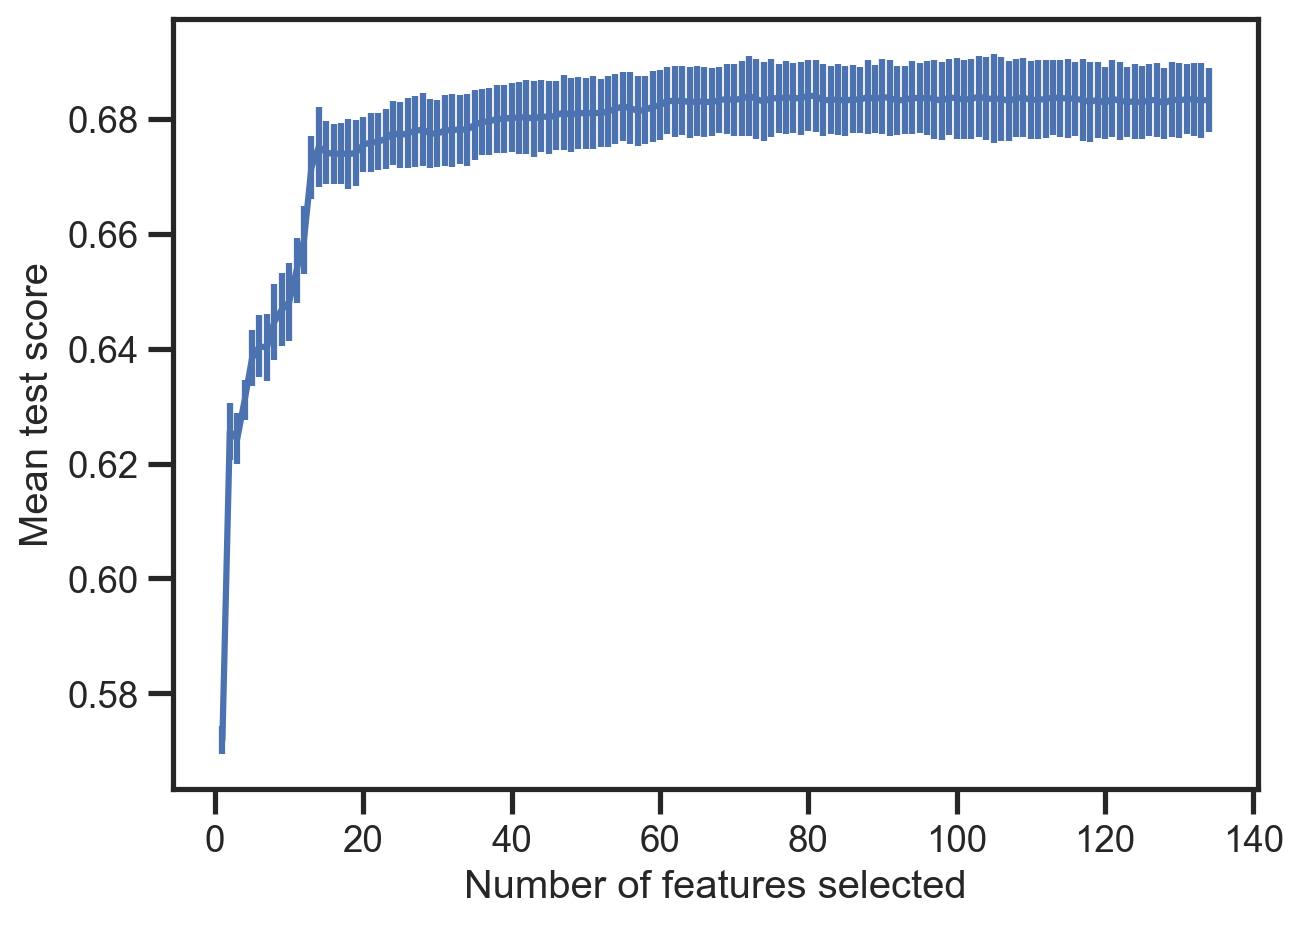

In [113]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(
    range(1, n_scores+1),
    ref_selector2.cv_results_["mean_test_score"],
    yerr=ref_selector2.cv_results_["std_test_score"],
)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test score");

In [114]:
pd.DataFrame(ref_selector2.cv_results_["mean_test_score"],range(1, n_scores+1)).sort_values(by=0,ascending=False).head()

0
80   0.684067
72   0.684027
81   0.683973
103  0.683920
90   0.683853

In [115]:
# Get the indices of the top performing features
top_features_idx = ref_selector2.get_support(indices=True)

# Get the names of the top performing features
top_features_names = X_train_preprocessed2.columns[top_features_idx]

# Print the top performing features
print("Top performing features:")
print(len(top_features_names))


Top performing features:
80


### Extra Trree

In [100]:
extra_tree = ExtraTreesClassifier()
ref_extra= RFECV(extra_tree, step=1, cv=10)

In [101]:
ref_extra.fit(X_train_preprocessed2, y_train)

RFECV(cv=10, estimator=ExtraTreesClassifier())

In [102]:
n_scores = len(ref_extra.cv_results_["mean_test_score"])
n_scores

327

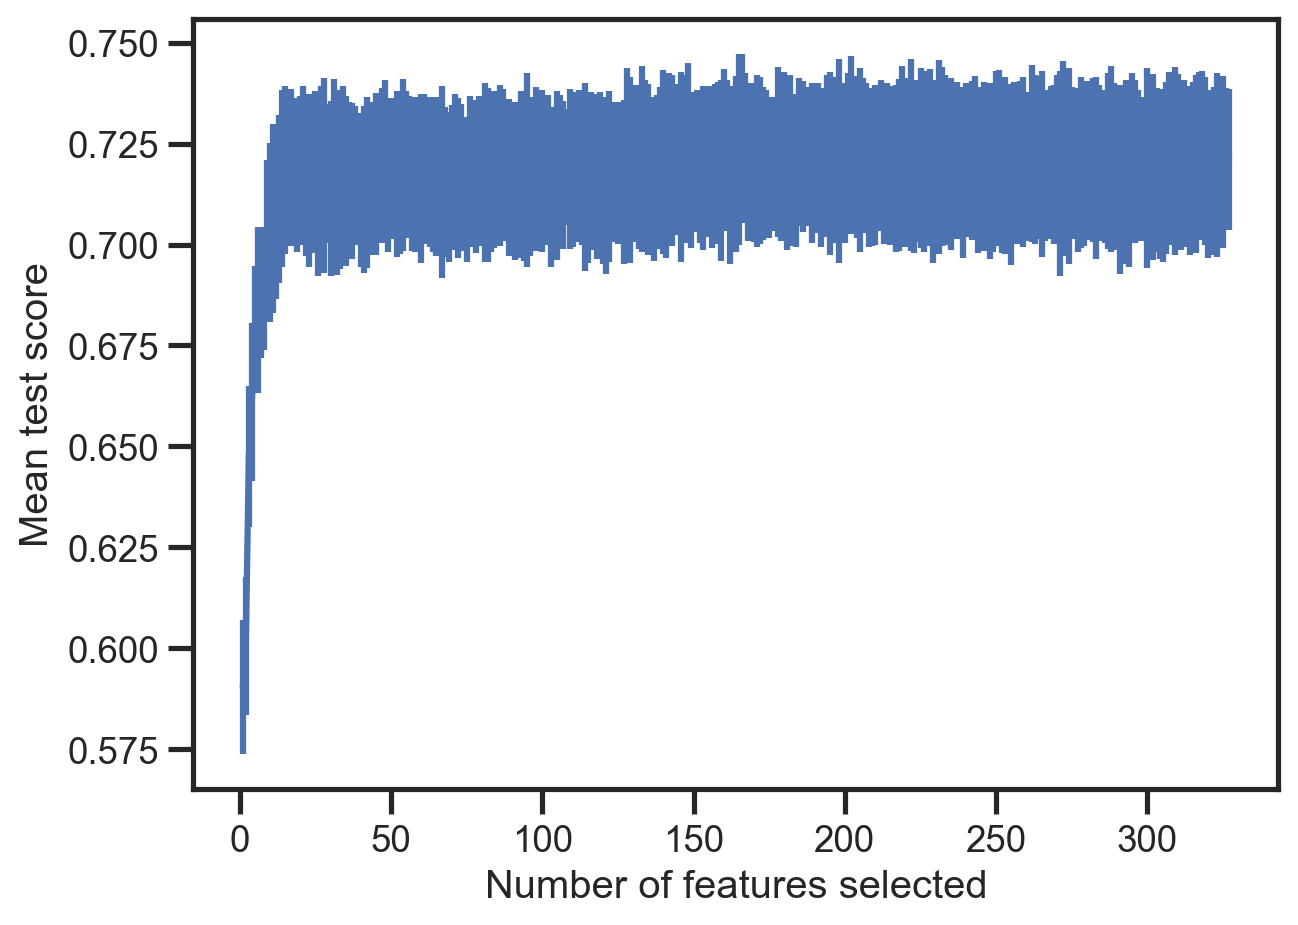

In [103]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(
    range(1, n_scores+1),
    ref_extra.cv_results_["mean_test_score"],
    yerr=ref_extra.cv_results_["std_test_score"],
)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test score");

In [104]:
pd.DataFrame(ref_extra.cv_results_["mean_test_score"],range(1, n_scores+1)).sort_values(by=0,ascending=False).head()

0
166  0.726667
272  0.726400
202  0.724667
230  0.724400
142  0.724133

In [106]:
# Get the indices of the top performing features
top_features_idx = ref_extra.get_support(indices=True)

# Get the names of the top performing features
top_features_names = X_train_preprocessed2.columns[top_features_idx]

# Print the top performing features
print("Top performing features:")
print(len(top_features_names))


Top performing features:
166


### Model fitting and prediction on top selected features by REFCV

In [116]:
result_refcv_full2 = model_selection(X_train_preprocessed2[top_features_names], X_test_preprocessed2[top_features_names], y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15556
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 80
[LightGBM] [Info] Start training from score -1.729724
[LightGBM] [Info] Start training from score -1.236542
[LightGBM] [Info] Start training from score -0.630586


In [117]:
result_refcv_full2.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc      acc  precision  \
1        random_forest     0.999973      0.822731  0.82640   0.827060   
4            extratree     1.000000      0.817378  0.82504   0.825156   
5                  xgb     0.862813      0.785740  0.79228   0.792813   
2             catboost     0.822213      0.765950  0.77544   0.776405   
6                 lgbm     0.791720      0.751750  0.75888   0.760837   
3          decisontree     1.000000      0.742693  0.75688   0.756675   
0  logistic_regression     0.686080      0.663993  0.68240   0.684451   

   time_taken  
1   80.582296  
4   27.160619  
5    6.227148  
2   57.576154  
6    5.508082  
3    8.208284  
0    6.056135

### Model fitting on top 80 selected features using SelectKbest

In [118]:
selector = SelectKBest(f_classif, k=80).fit(X_train_preprocessed2, y_train)
X_sel = selector.transform(X_train_preprocessed2)
auto_select = pd.DataFrame(X_sel, columns=selector.get_feature_names_out()).columns

In [119]:
auto_select = auto_select.tolist()

In [120]:
result_selectkbest2 = model_selection(X_train_preprocessed2[auto_select], X_test_preprocessed2[auto_select], y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15788
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 80
[LightGBM] [Info] Start training from score -1.729724
[LightGBM] [Info] Start training from score -1.236542
[LightGBM] [Info] Start training from score -0.630586


In [121]:
final_features = [i for i in top_features_names if i in auto_select]
final_features

['Annual_Income',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Outstanding_Debt',
 'Credit_History_Age',
 'Monthly_Balance',
 'Month Num_Bank_Accounts',
 'Month Num_Credit_Card',
 'Month Interest_Rate',
 'Month Delay_from_due_date',
 'Month Num_of_Delayed_Payment',
 'Month Num_Credit_Inquiries',
 'Month Outstanding_Debt',
 'Age Annual_Income',
 'Age Delay_from_due_date',
 'Age Num_of_Delayed_Payment',
 'Age Outstanding_Debt',
 'Age Amount_invested_monthly',
 'Annual_Income Credit_History_Age',
 'Annual_Income Monthly_Balance',
 'Num_Bank_Accounts Num_Credit_Card',
 'Num_Bank_Accounts Interest_Rate',
 'Num_Bank_Accounts Delay_from_due_date',
 'Num_Bank_Accounts Num_of_Delayed_Payment',
 'Num_Bank_Accounts Changed_Credit_Limit',
 'Num_Bank_Accounts Num_Credit_Inquiries',
 'Num_Bank_Accounts Outstanding_Debt',
 'Num_Credit_Card Interest_Rate',
 'Num_Credit_Card Num_of_Dela

In [122]:
result_selectkbest2.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc      acc  precision  \
1        random_forest     1.000000      0.821313  0.82528   0.825936   
4            extratree     1.000000      0.811609  0.81968   0.819819   
5                  xgb     0.859720      0.784640  0.79072   0.791346   
2             catboost     0.819373      0.762025  0.77336   0.773820   
6                 lgbm     0.788107      0.749881  0.75684   0.758968   
3          decisontree     1.000000      0.738788  0.75280   0.752683   
0  logistic_regression     0.684427      0.664754  0.68208   0.684391   

   time_taken  
1   78.102125  
4   27.953031  
5    6.666622  
2   58.478587  
6    5.249338  
3    8.869212  
0    6.286561

In [123]:
result_final_features = model_selection(X_train_preprocessed2[final_features], X_test_preprocessed2[final_features], y_train, y_test)
result_final_features.sort_values(by='precision',ascending=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11210
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 61
[LightGBM] [Info] Start training from score -1.729724
[LightGBM] [Info] Start training from score -1.236542
[LightGBM] [Info] Start training from score -0.630586


model  train_score  balanced_acc      acc  precision  \
1        random_forest     1.000000      0.819298  0.82364   0.824259   
4            extratree     1.000000      0.815224  0.82316   0.823325   
5                  xgb     0.854627      0.777863  0.78560   0.786180   
2             catboost     0.818387      0.761686  0.77236   0.773027   
6                 lgbm     0.785773      0.747943  0.75600   0.758169   
3          decisontree     1.000000      0.730243  0.74772   0.747403   
0  logistic_regression     0.683080      0.660324  0.67932   0.681624   

   time_taken  
1   61.850618  
4   21.146528  
5    4.318448  
2   45.265727  
6    3.836319  
3    5.795560  
0    4.255886

Precision Improved by about **2%** after reducing the categories in the `Type of Loan` column.

Let's check and handle outliers

# Check and Handle Outliers

In [204]:
def plot_boxplot(col):
    """
    Returns a boxplot of a single feature
        col: The column of interest
    """
    plt.figure(figsize=(8, 5))
    feature = df[col]
    sns.boxplot(data=df, x=feature)
    plt.title(col)    
    plt.show()

In [205]:
def plot_boxplots(cols):
    """
    Returns a box plots of all features in the cols list:
        col: The column of interest
    """
    for col in cols:
        plt.figure(figsize=(8, 5))
        feature = df[col]
        sns.boxplot(data=df, x=feature)
        plt.title(col)    
        plt.show()

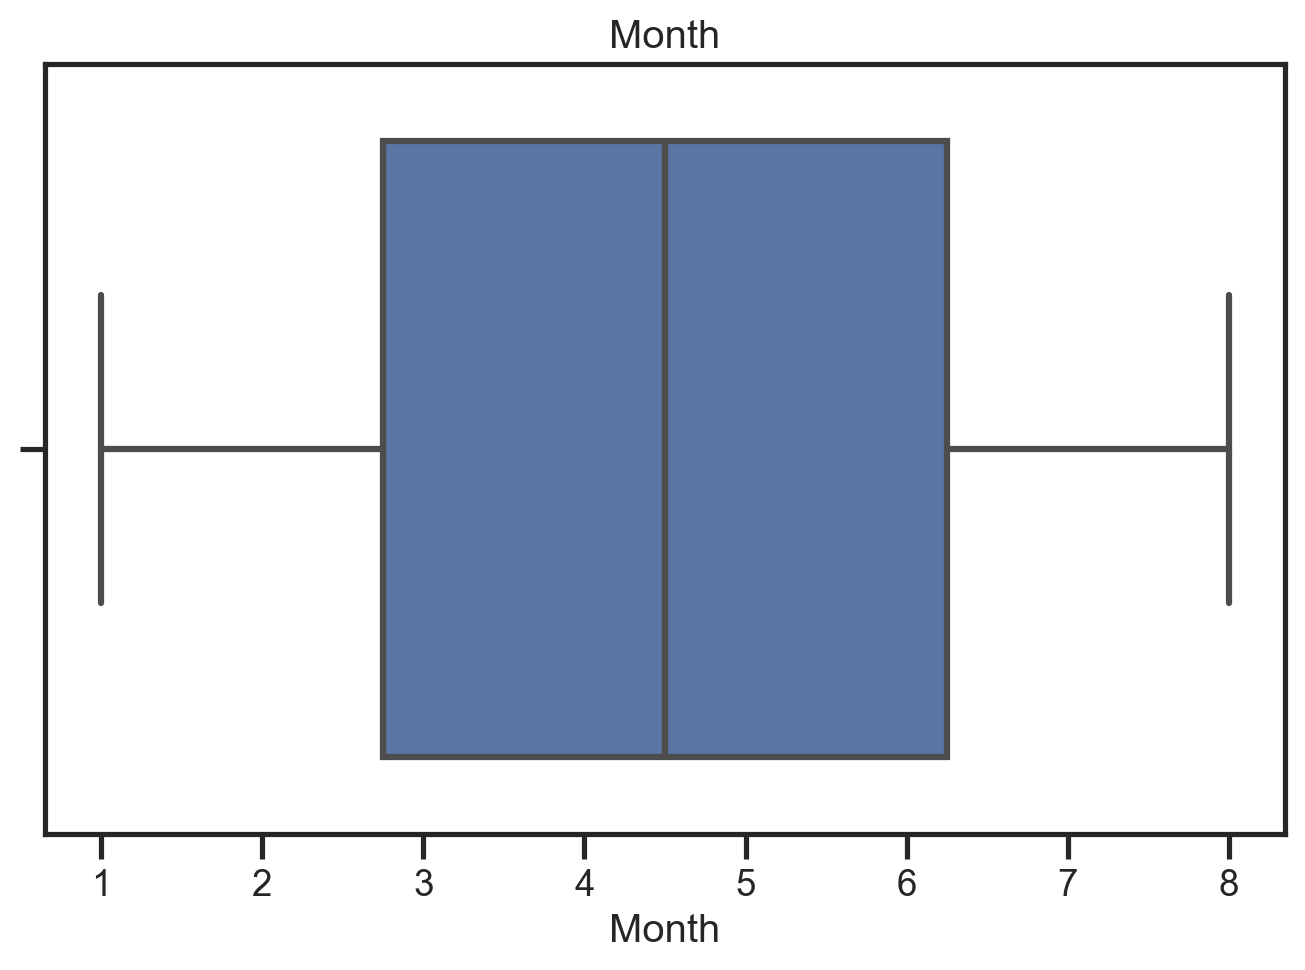

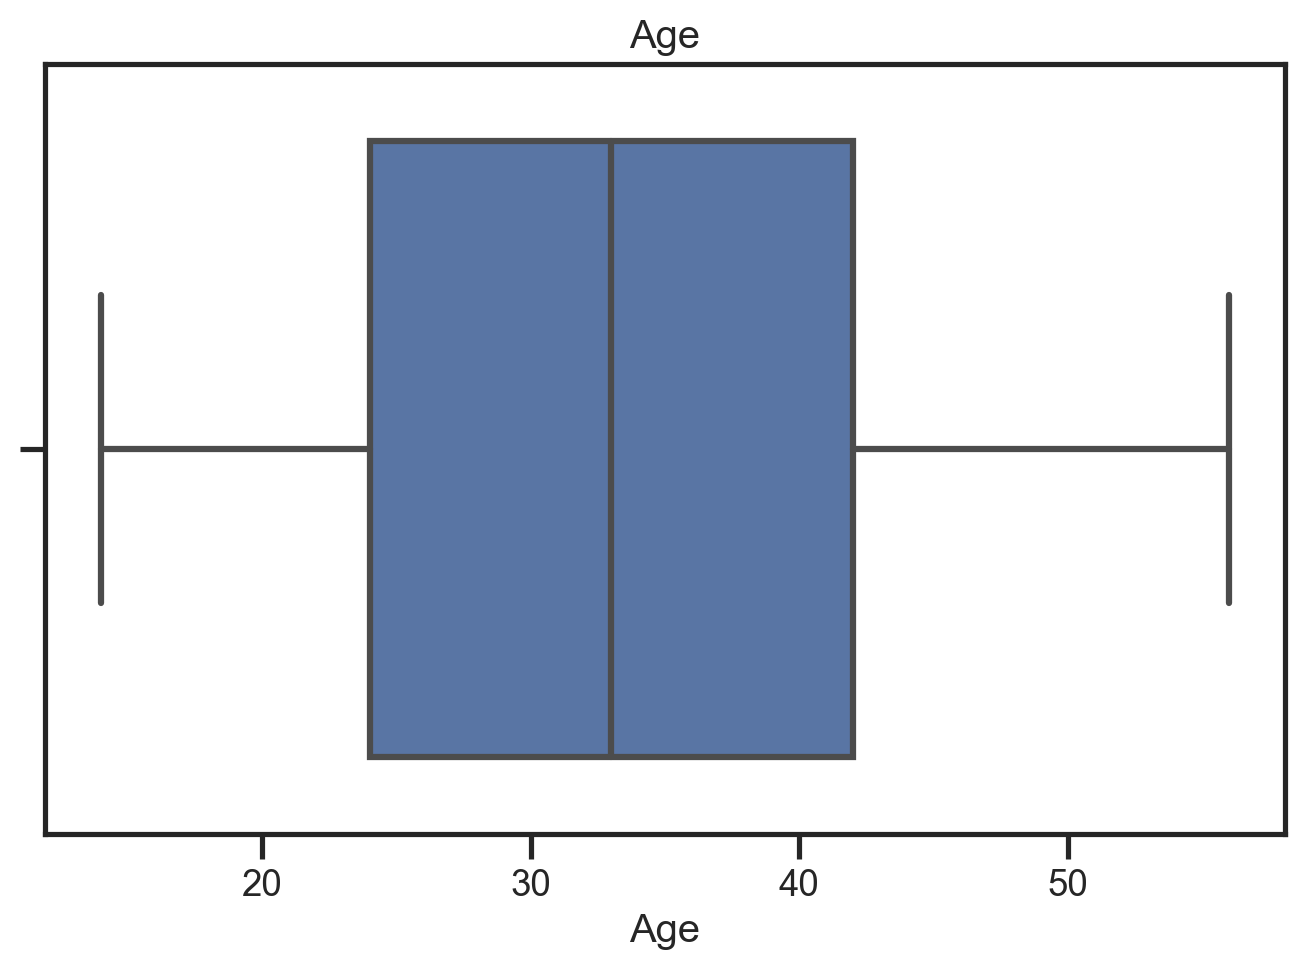

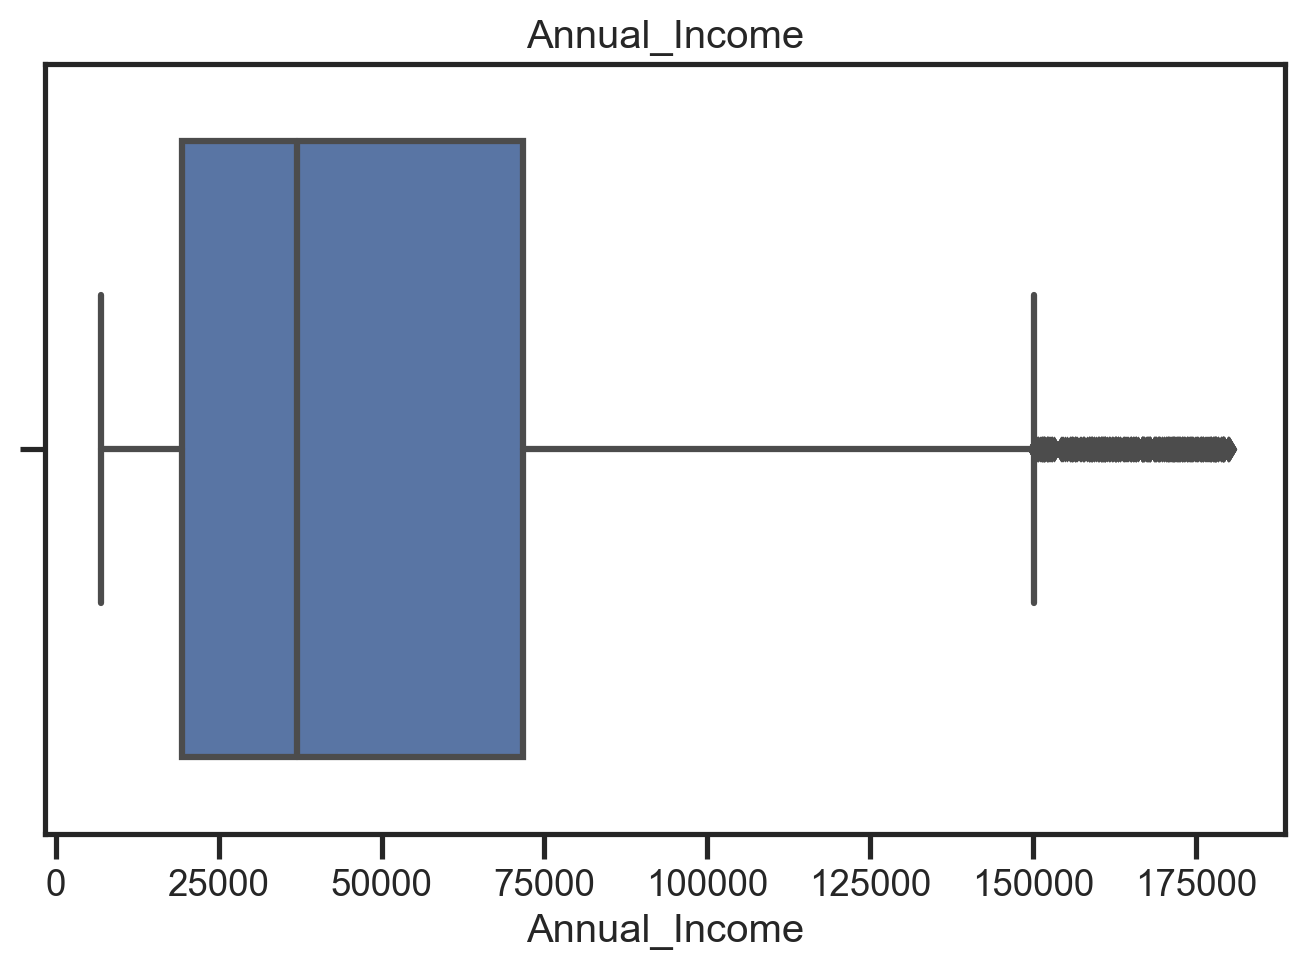

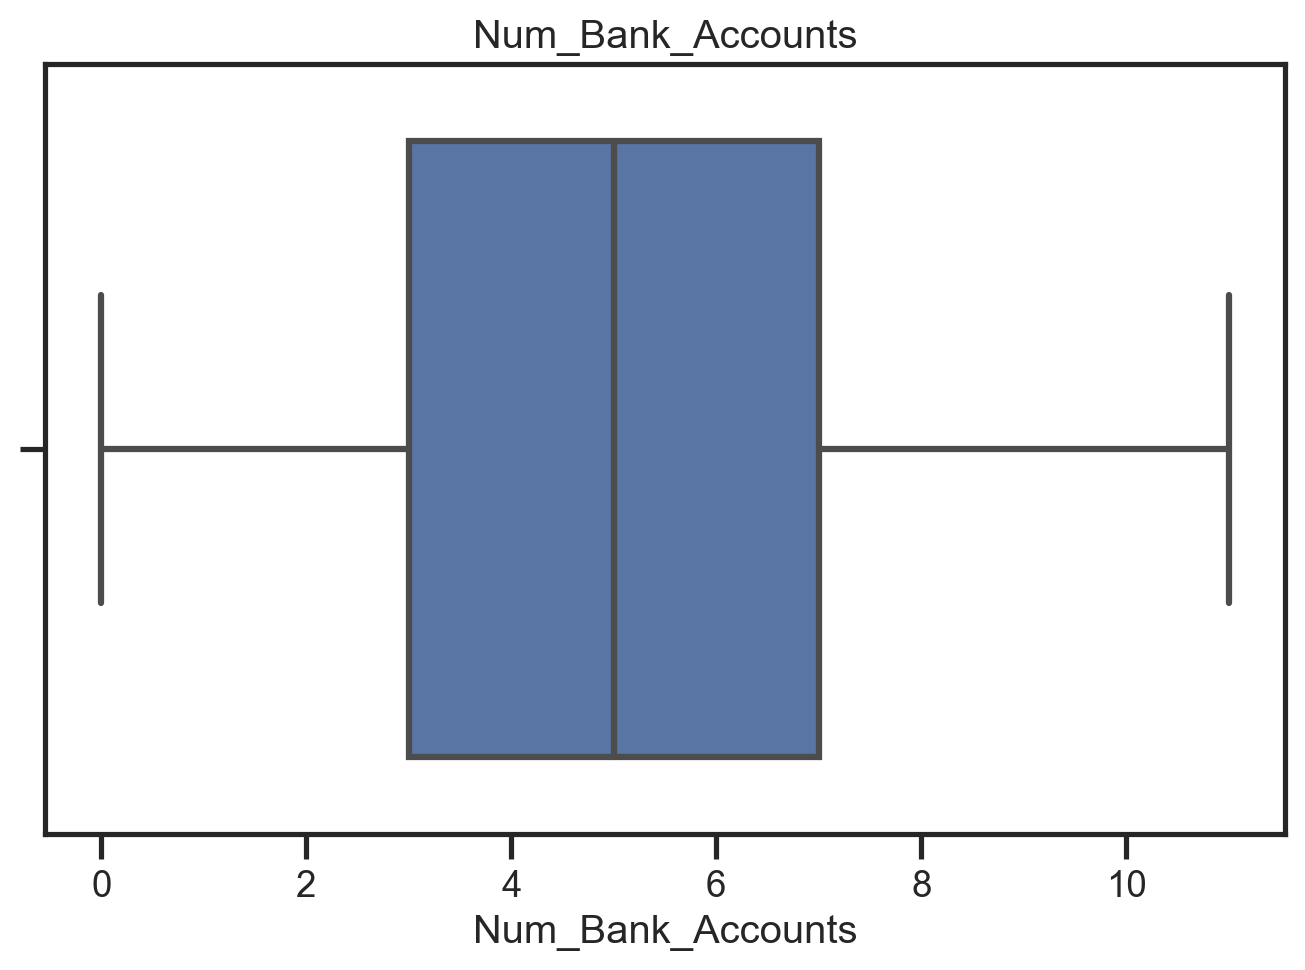

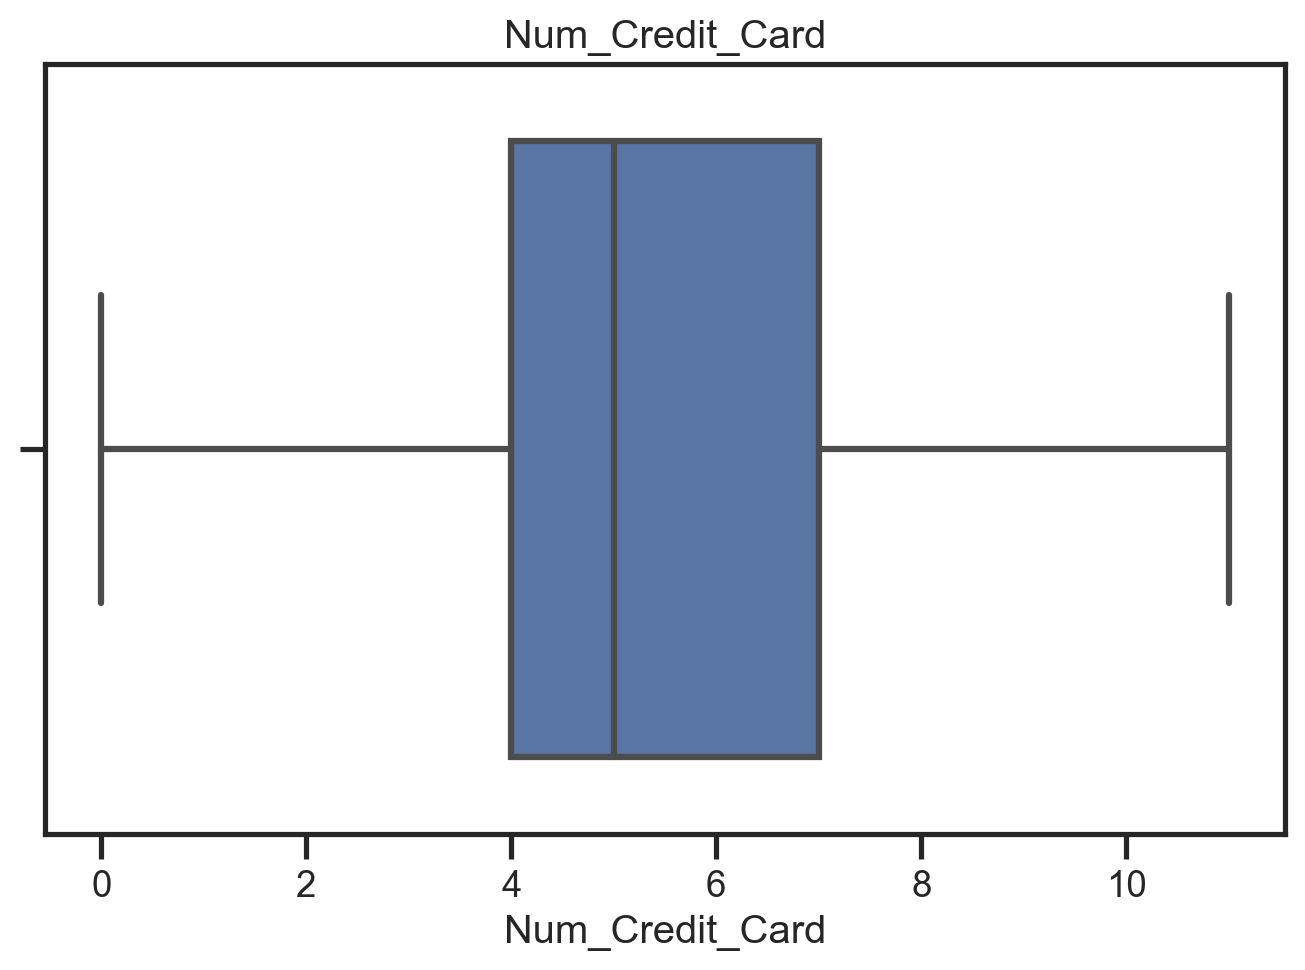

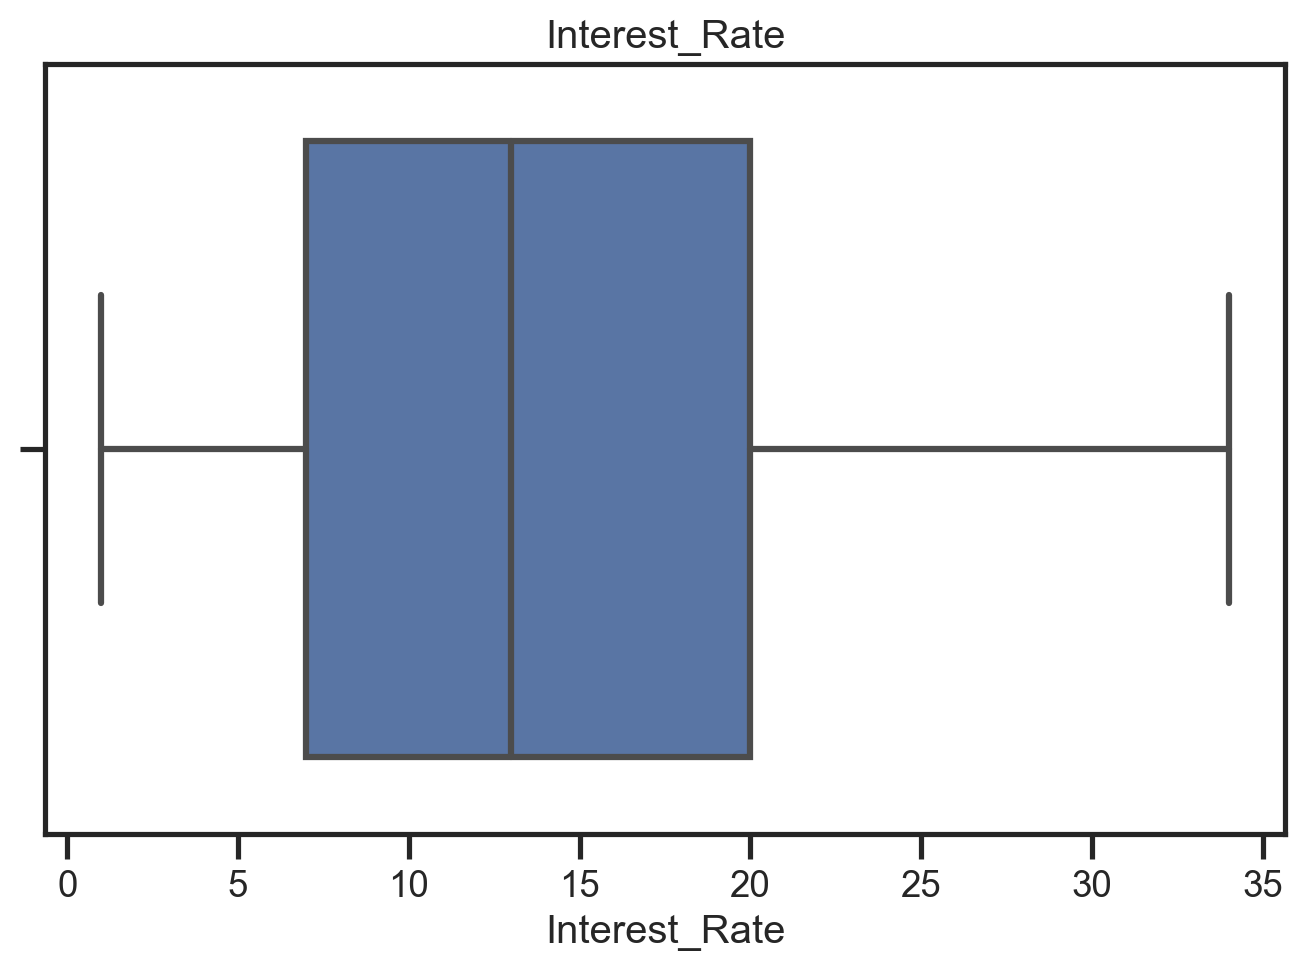

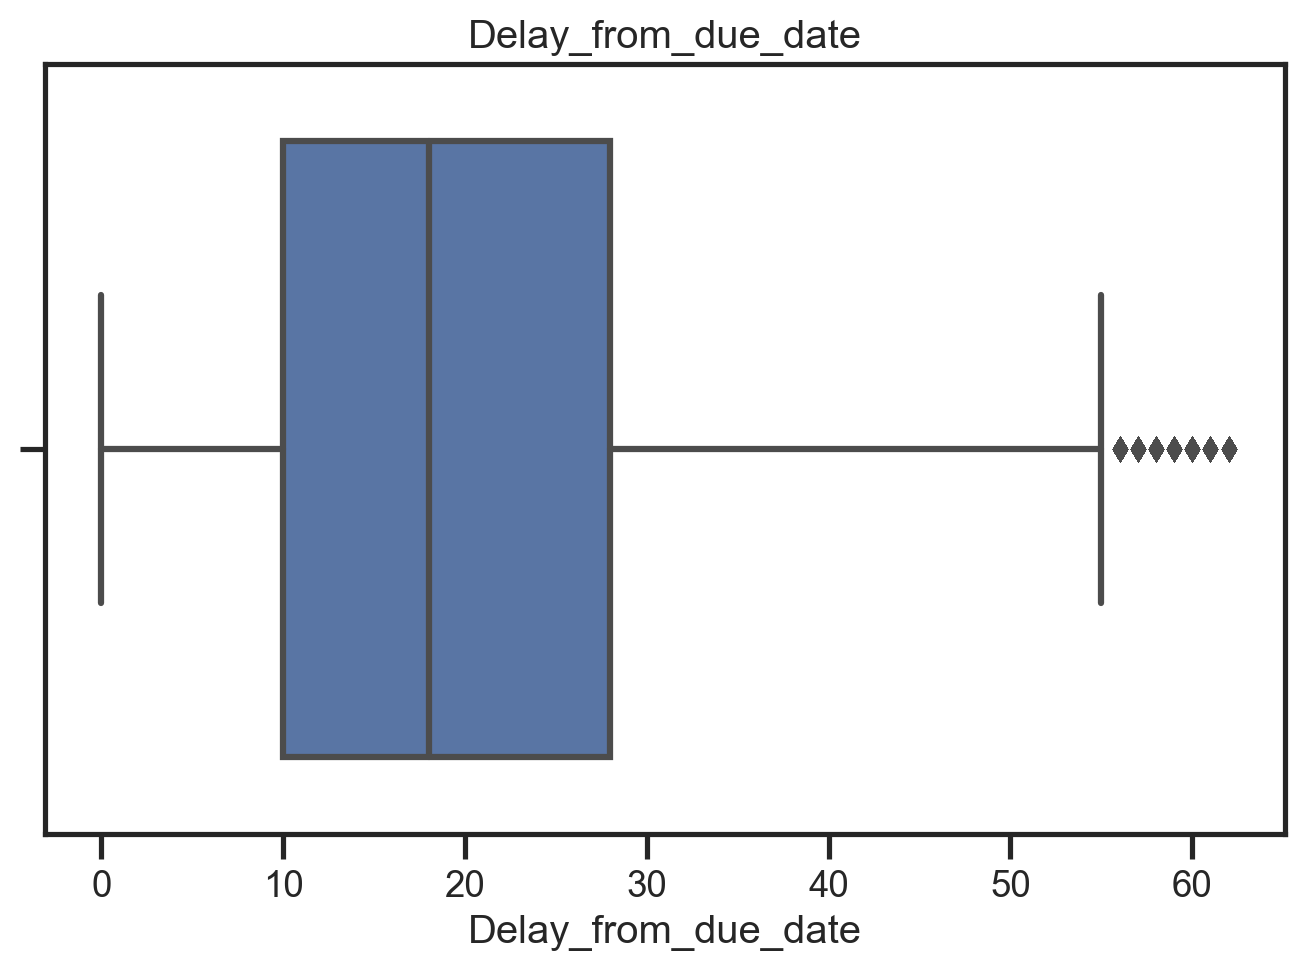

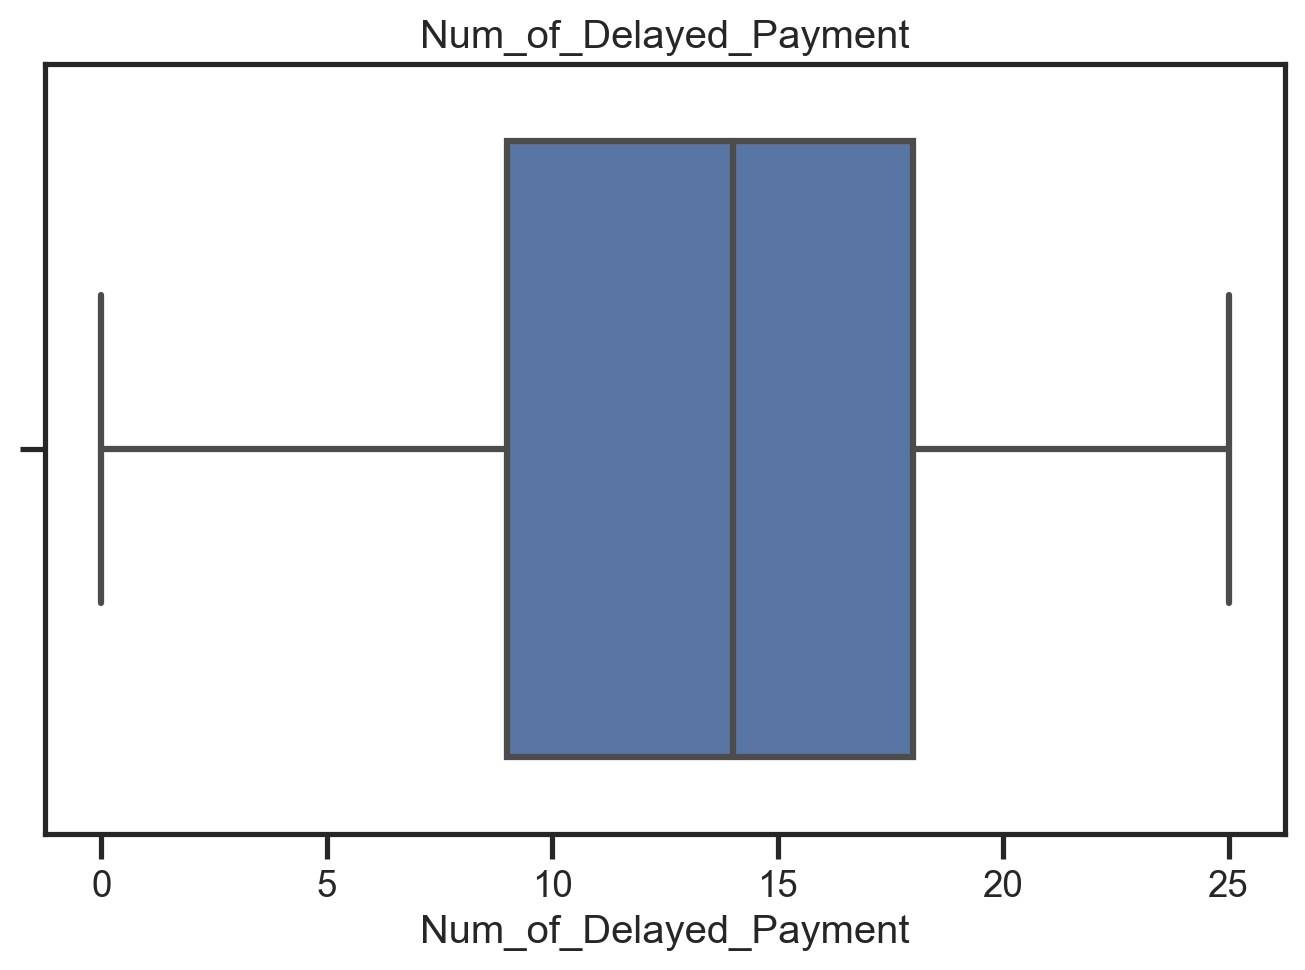

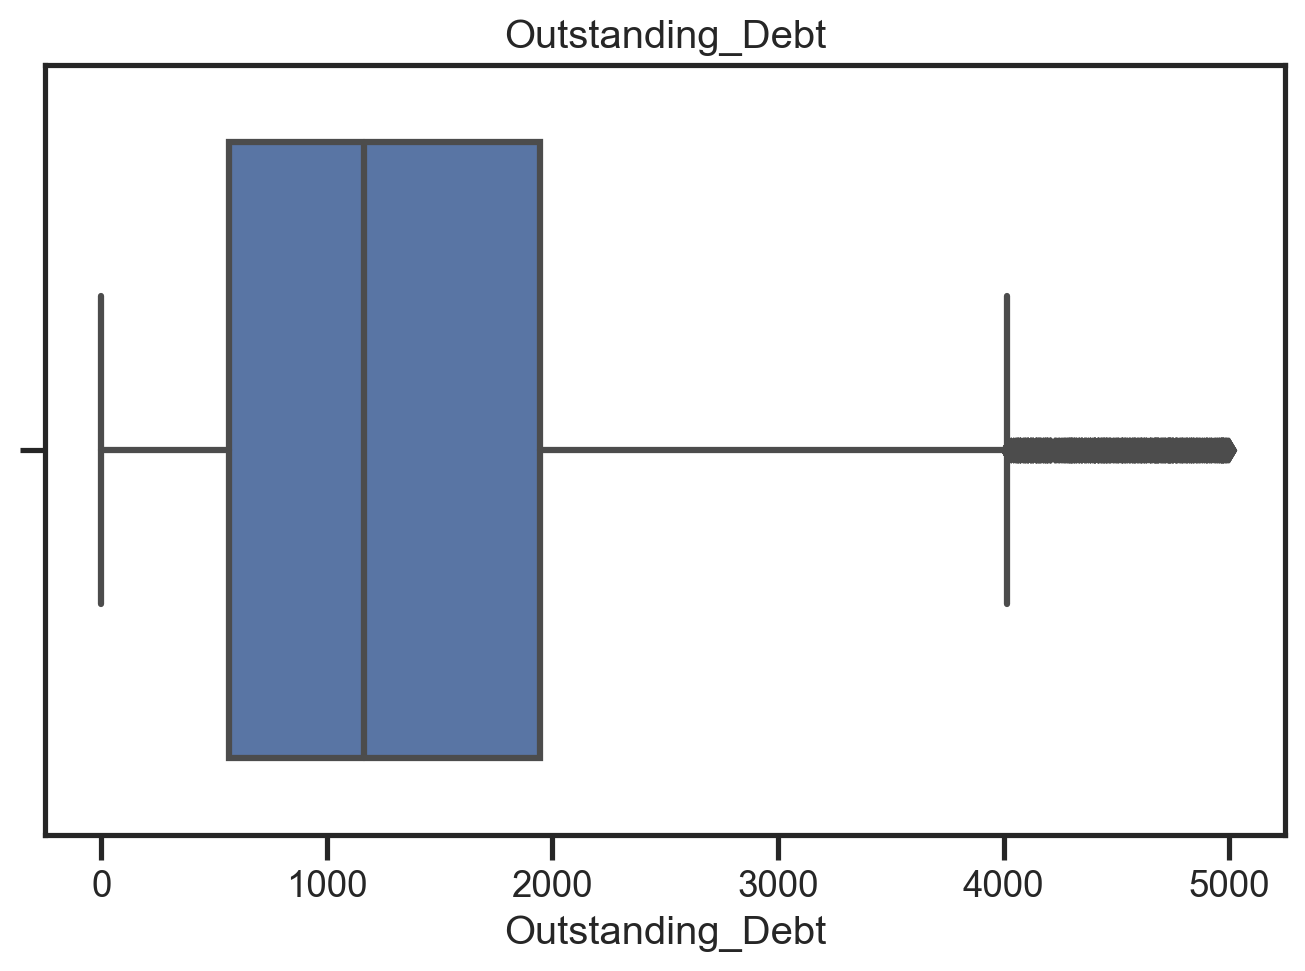

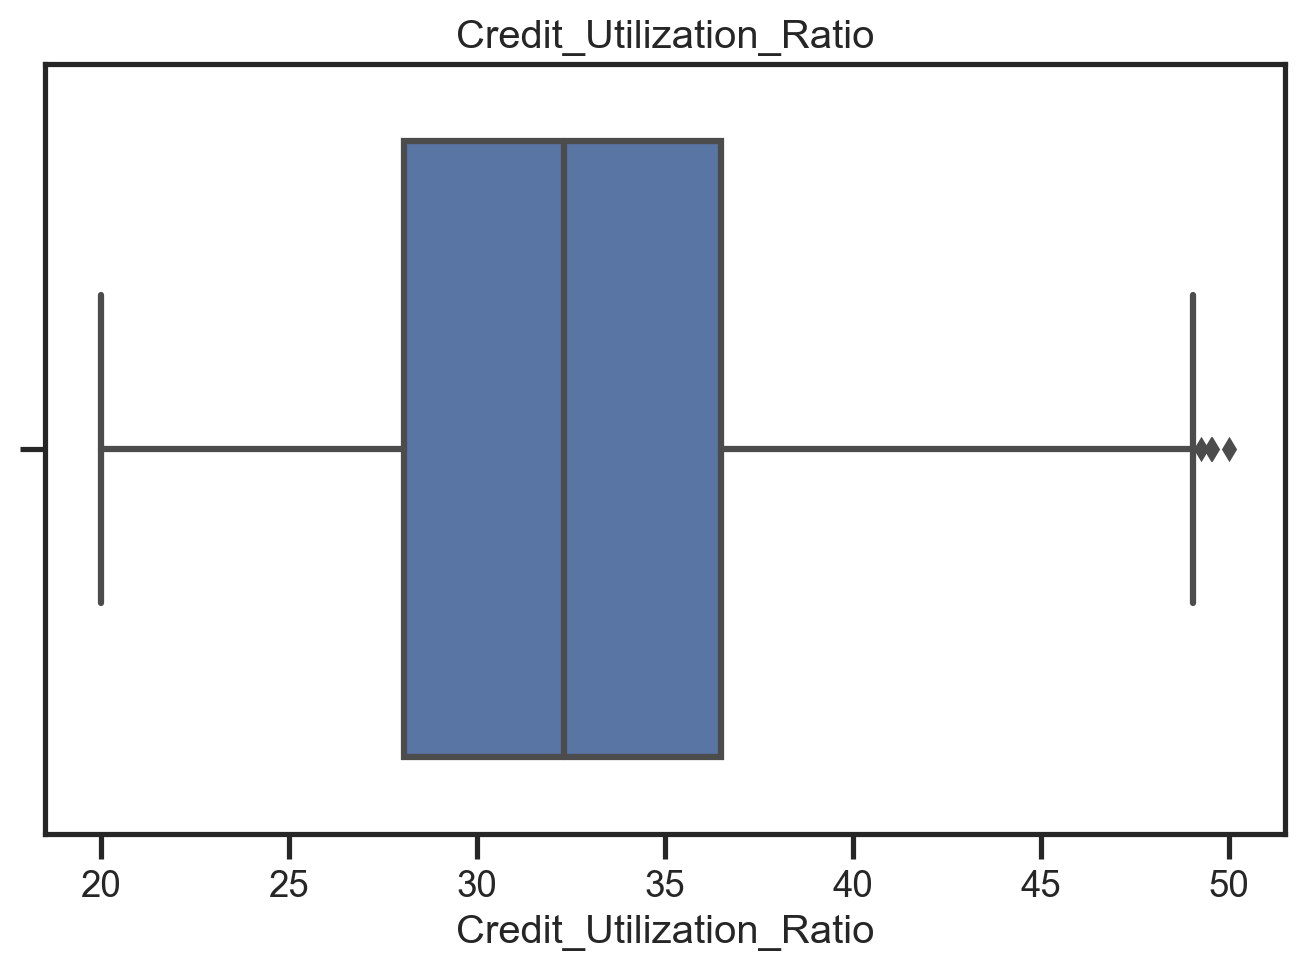

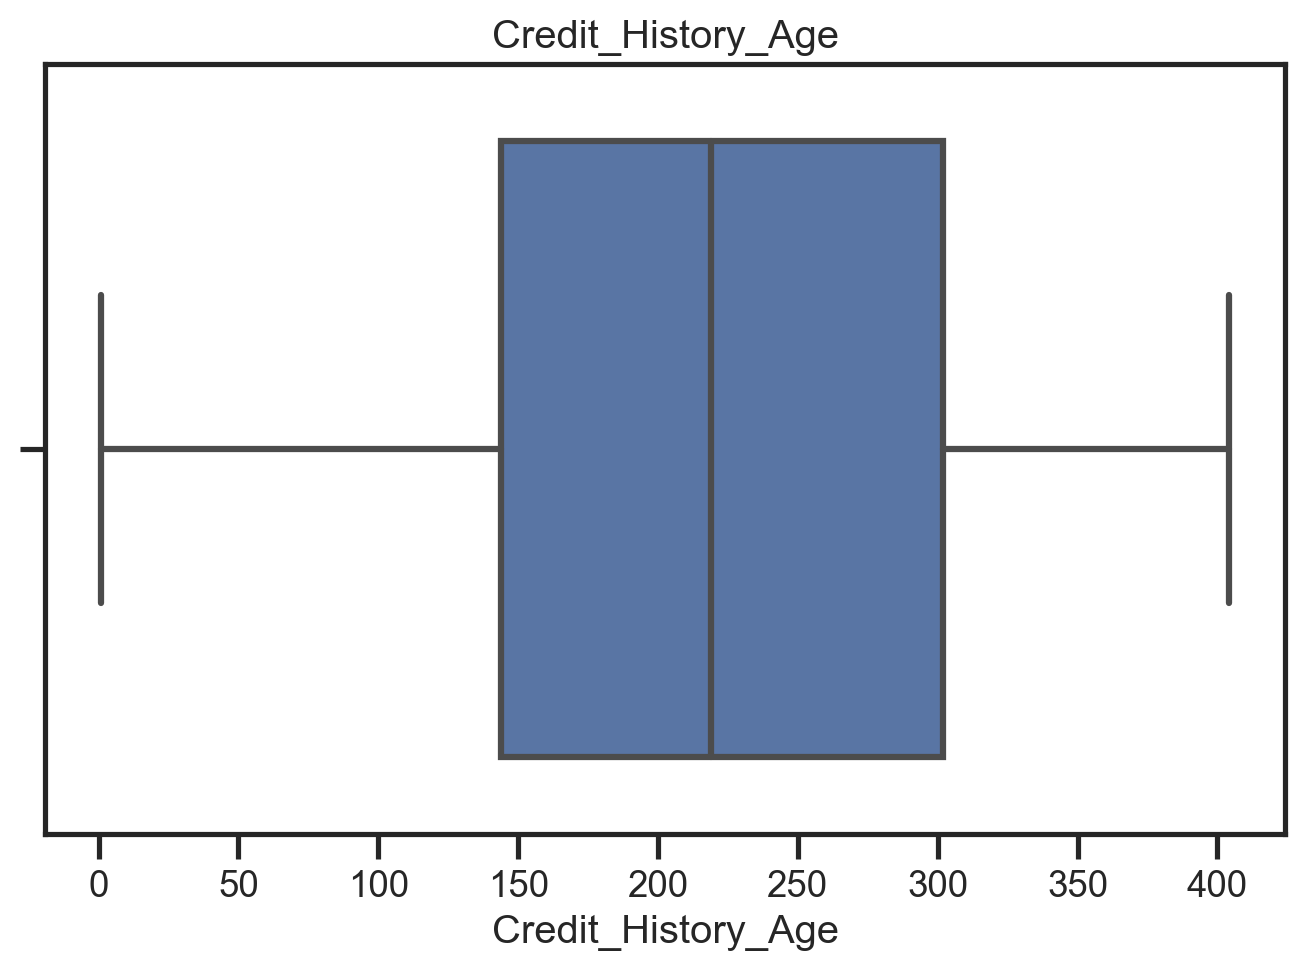

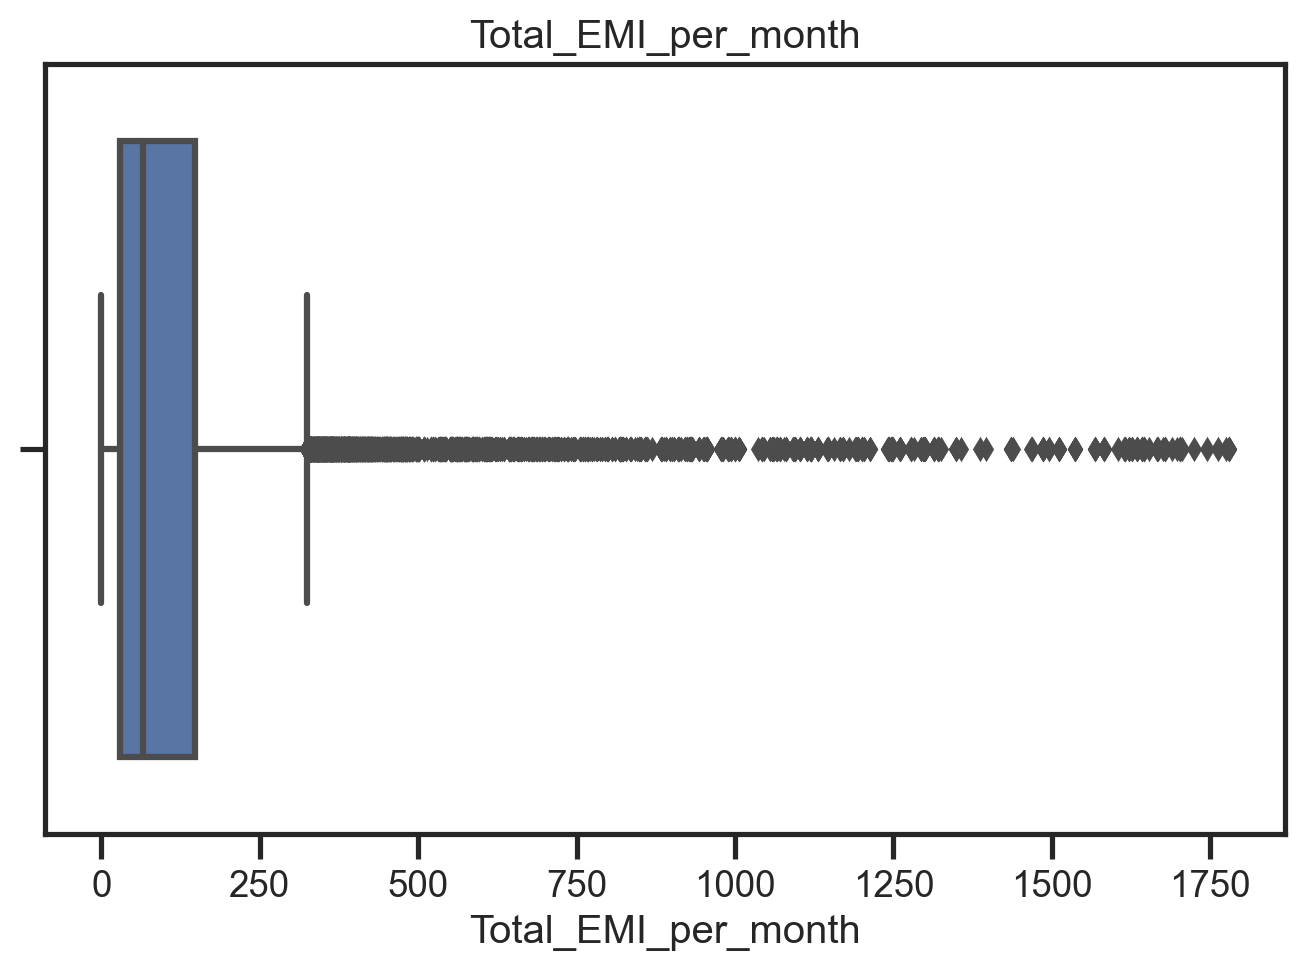

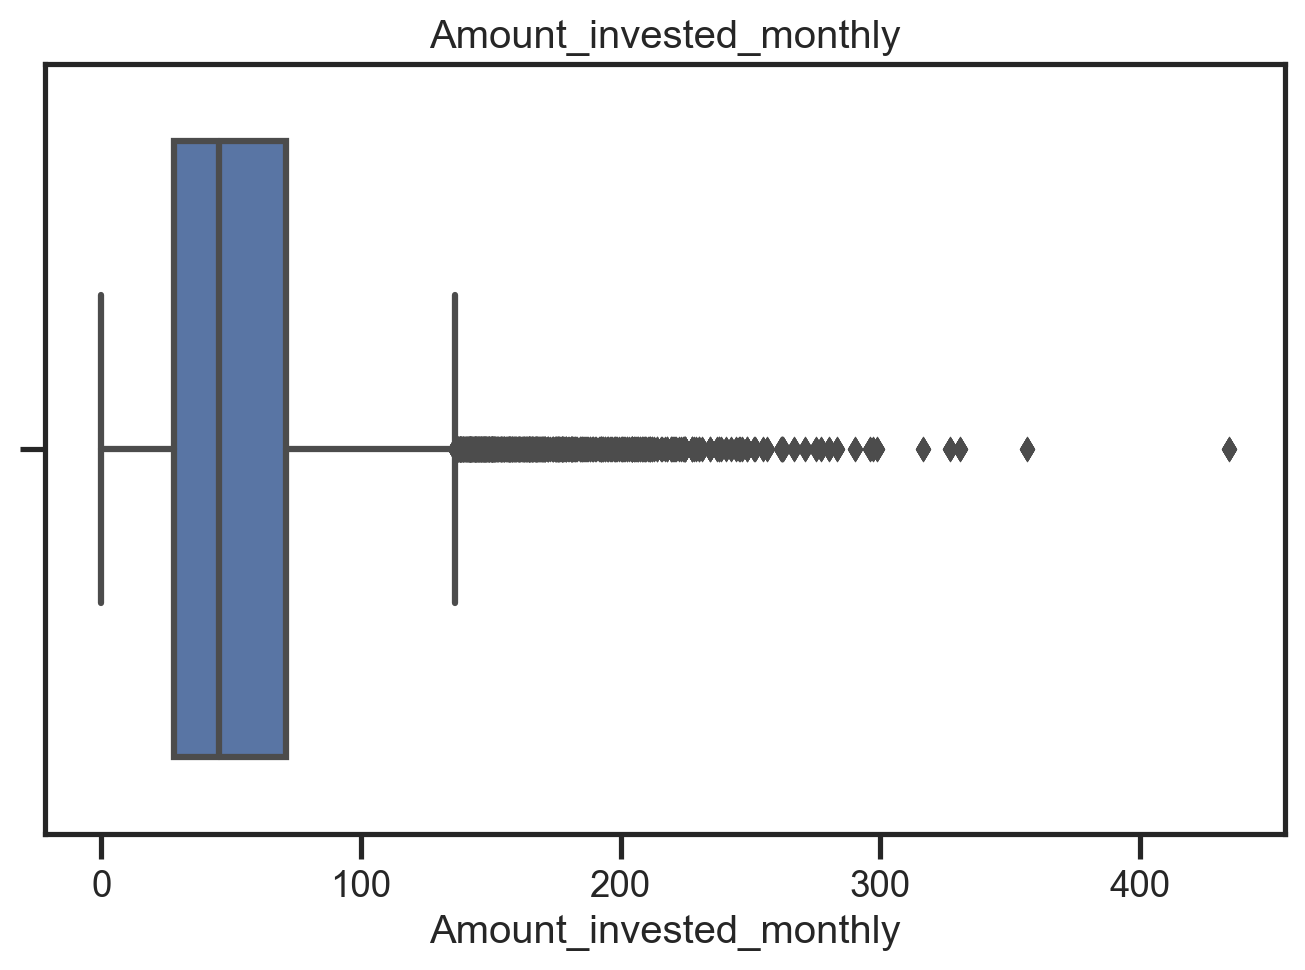

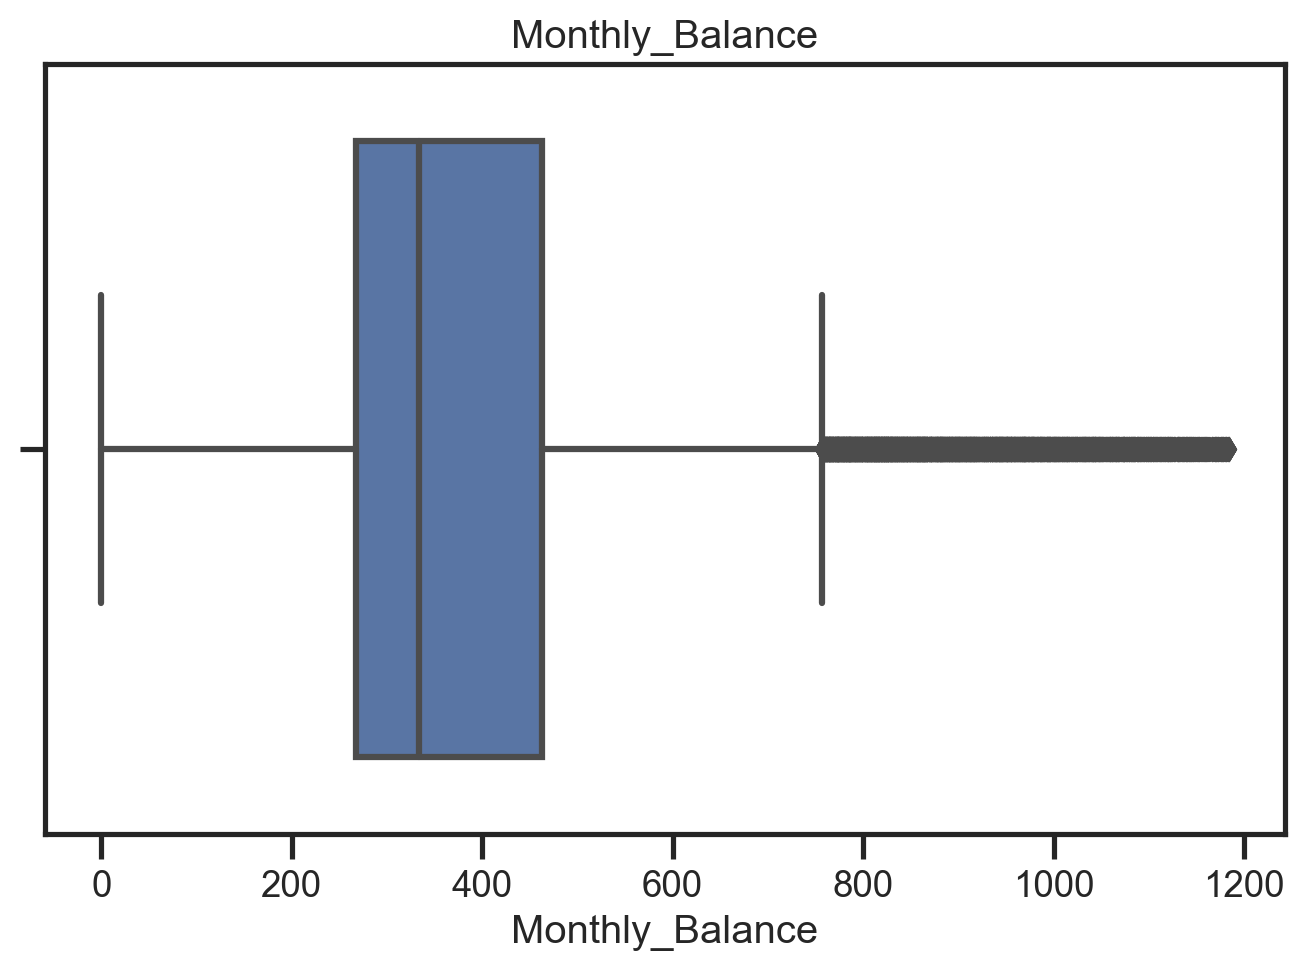

In [206]:
# Month
plot_boxplots(num_feat)

Some features have outliers in them while others don't. However, the last 5/6 features are categorical features with 1 for True and 0 for False

We will only treat the features with outliers that seems to have some effect on credit score

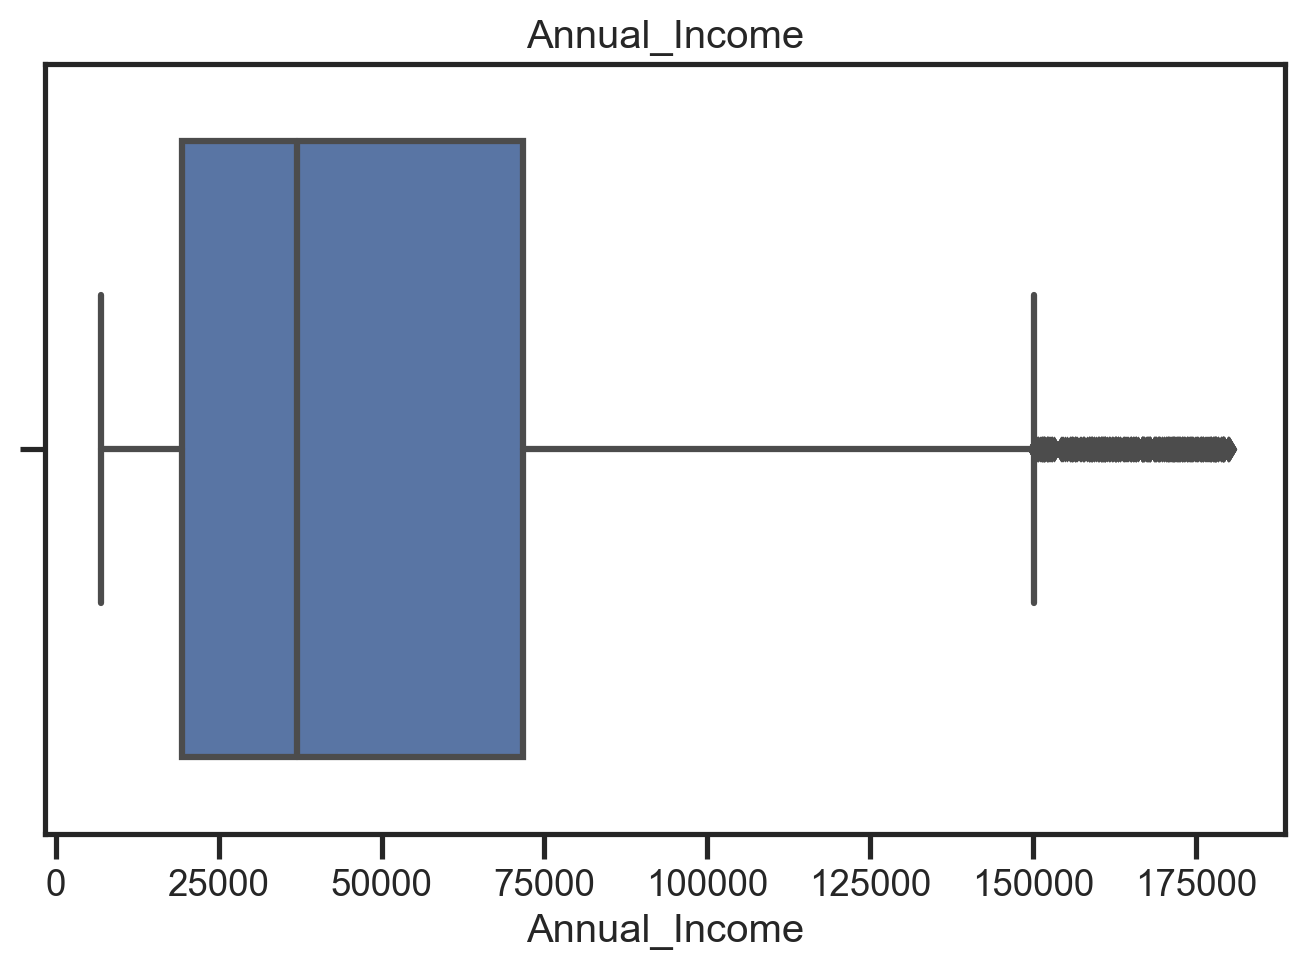

In [208]:
# Annual Income
plot_boxplot("Annual_Income")

In [209]:
df.loc[df['Annual_Income'] > df['Annual_Income'].quantile(0.99), 'Annual_Income'] = df['Annual_Income'].quantile(0.99)

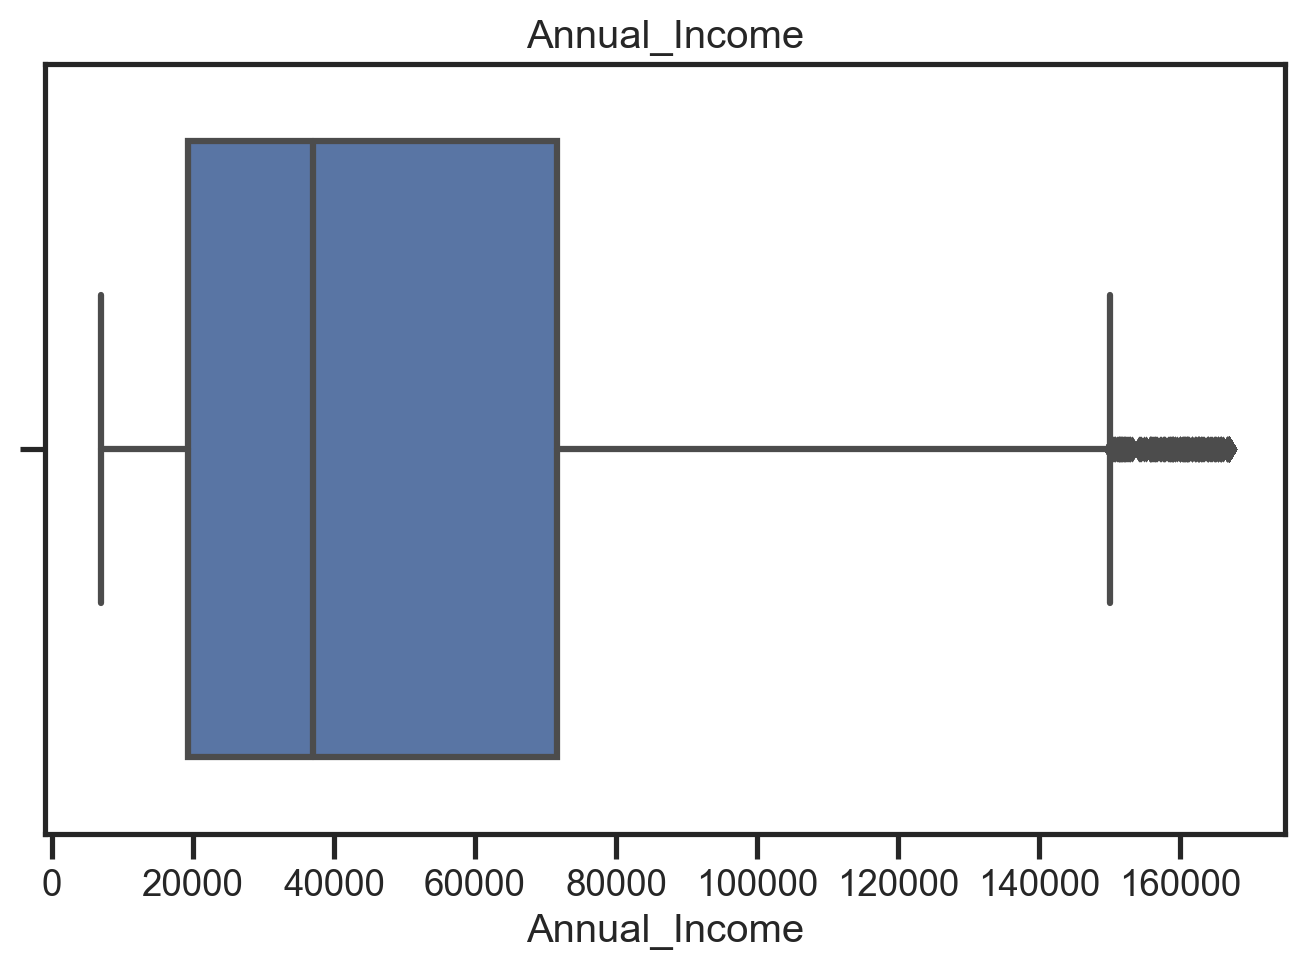

In [210]:
plot_boxplot("Annual_Income")

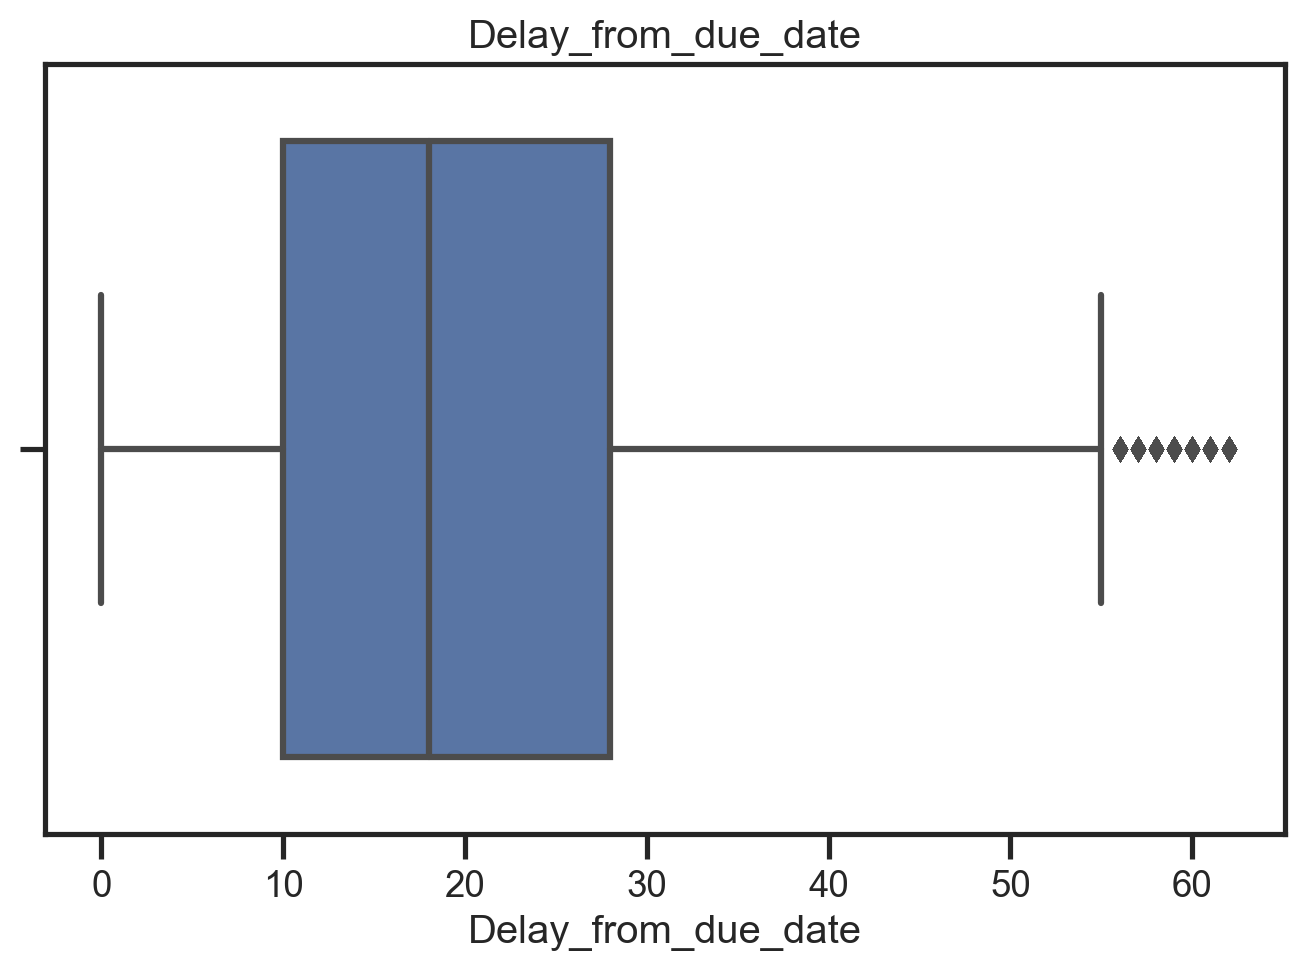

In [211]:
# DElay from due date
plot_boxplot("Delay_from_due_date")

<Axes: xlabel='Delay_from_due_date'>

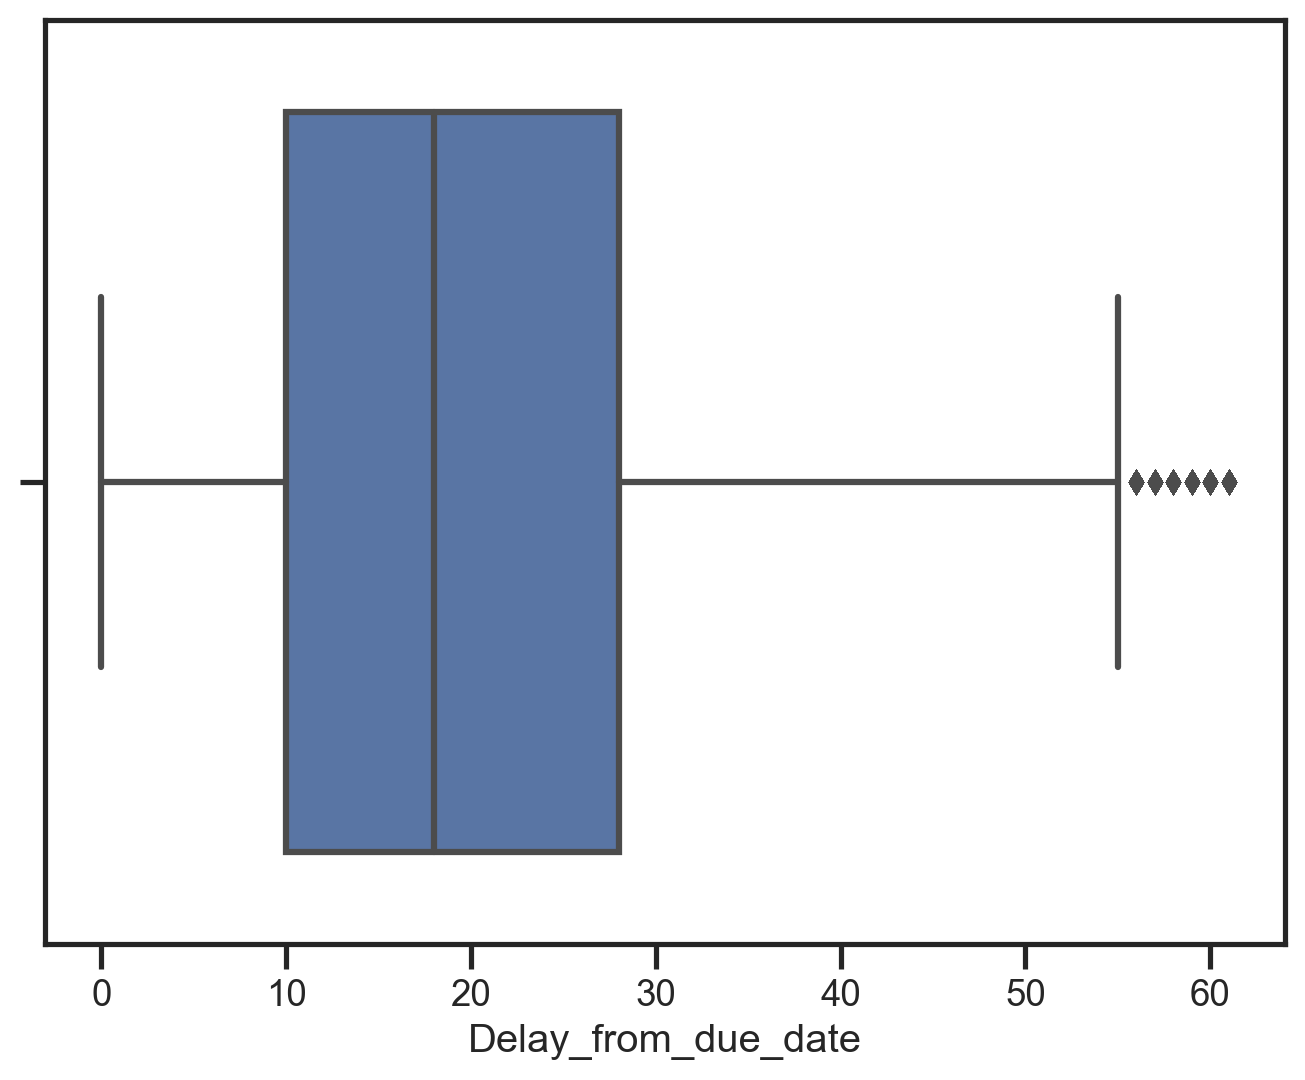

In [212]:
sns.boxplot(x=df[df['Delay_from_due_date'] <= df['Delay_from_due_date'].quantile(0.99)]['Delay_from_due_date'])

In [213]:
df[df['Delay_from_due_date'] > df['Delay_from_due_date'].quantile(0.99)]['Delay_from_due_date'].value_counts()

62.0    638
Name: Delay_from_due_date, dtype: int64

In [214]:
df.loc[df['Delay_from_due_date'] > df['Delay_from_due_date'].quantile(0.99),'Delay_from_due_date'] = df['Delay_from_due_date'].quantile(0.99)

In [215]:
plot_boxplot("Delay_from_due_date")

In [216]:
# changed credit limt
plot_boxplot("Changed_Credit_Limit")

In [218]:
df['Changed_Credit_Limit'].quantile(0.99)

28.55

In [220]:
df.loc[df['Changed_Credit_Limit'] > df['Changed_Credit_Limit'].quantile(0.99),'Changed_Credit_Limit'] = df['Changed_Credit_Limit'].quantile(0.99)

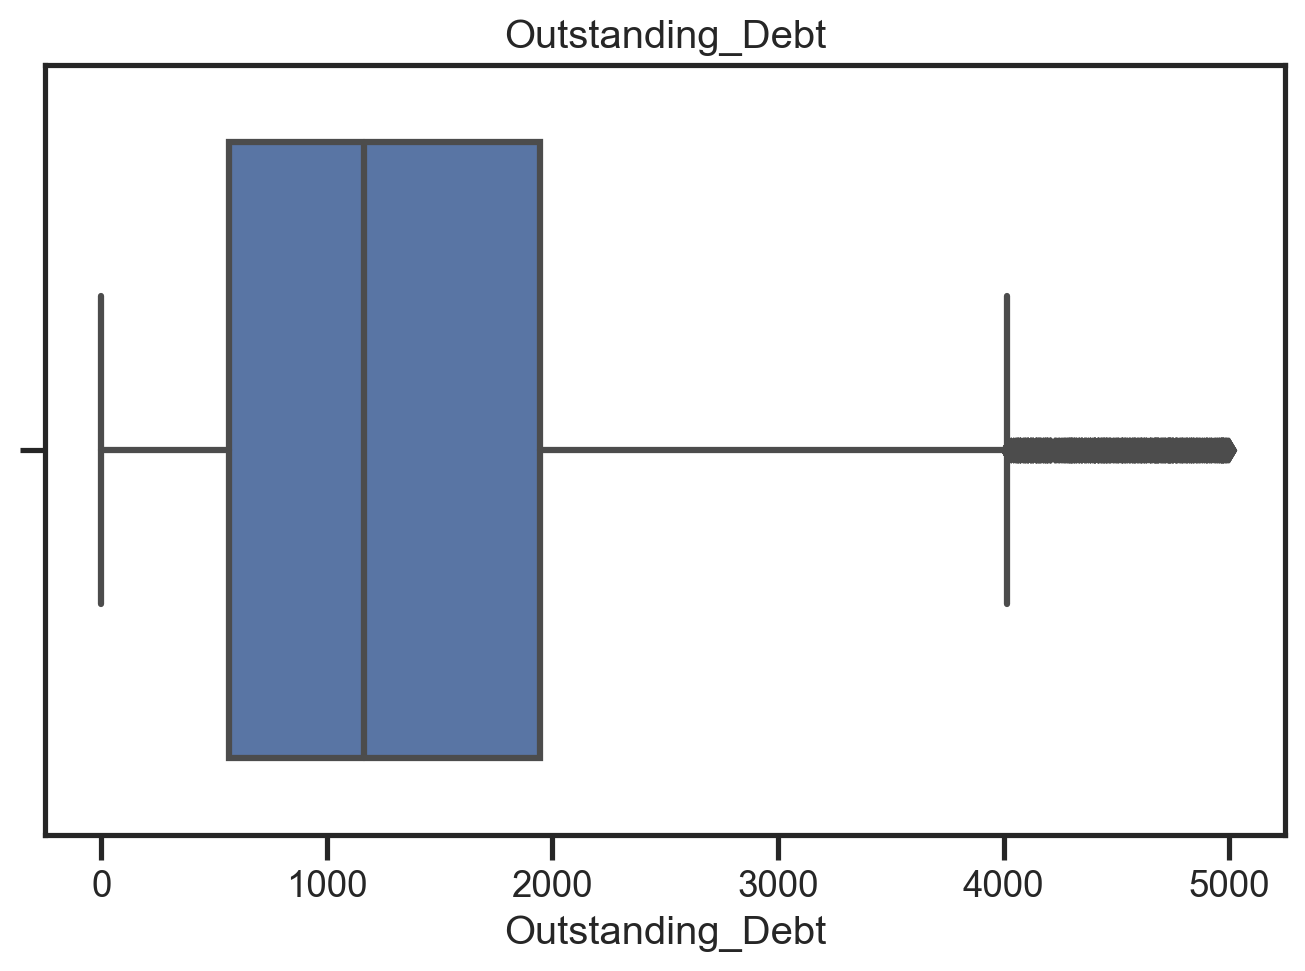

In [221]:
# Outstanding debts
plot_boxplot('Outstanding_Debt')

In [225]:
df['Outstanding_Debt'].quantile(0.99)

4806.966899999997

In [226]:
df.loc[df['Outstanding_Debt'] > df['Outstanding_Debt'].quantile(0.99),'Outstanding_Debt'] = df['Outstanding_Debt'].quantile(0.99)

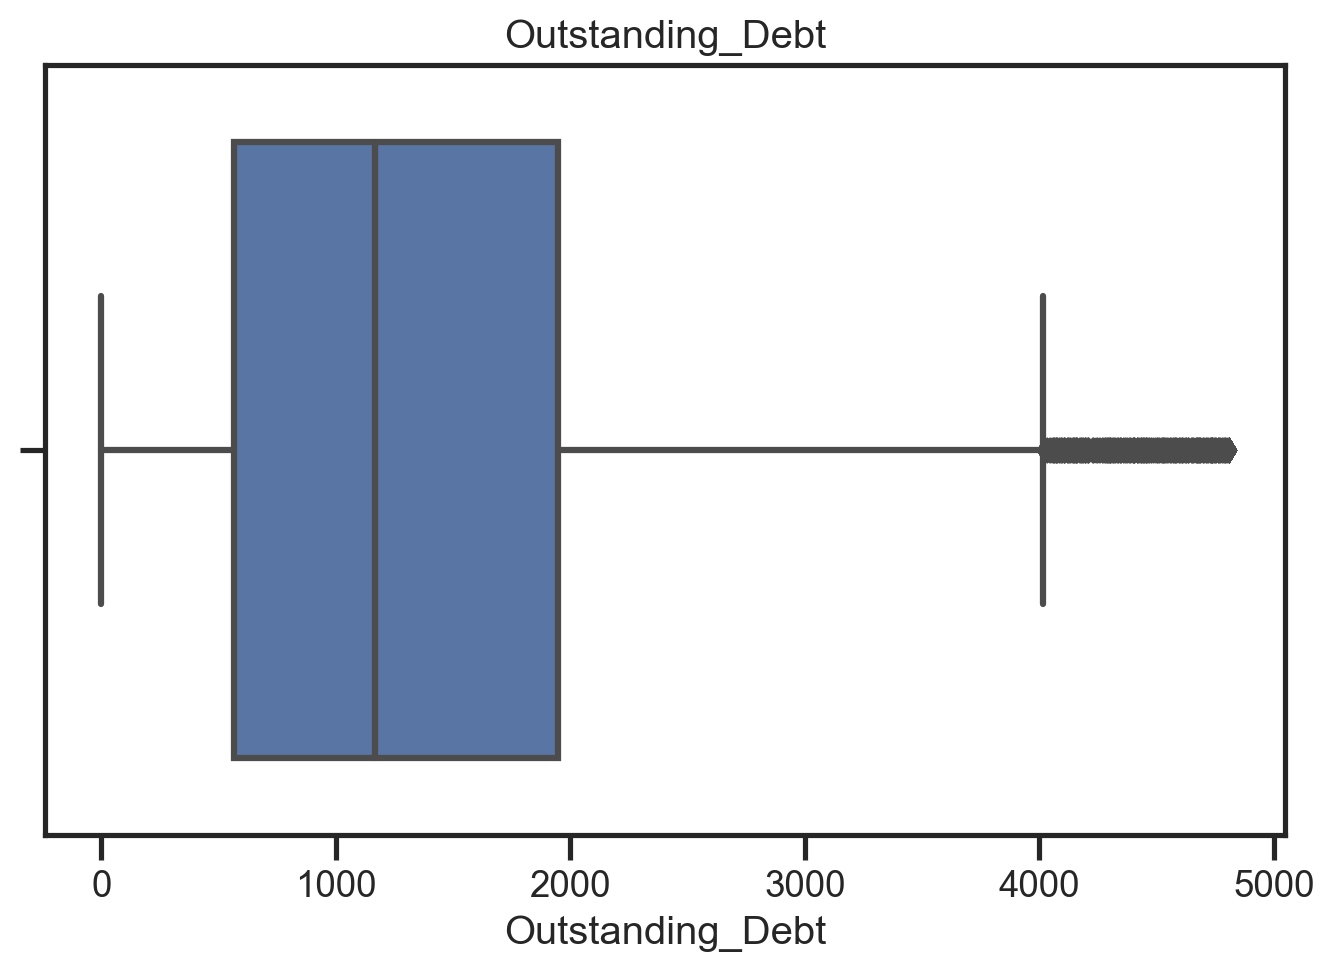

In [227]:
plot_boxplot('Outstanding_Debt')

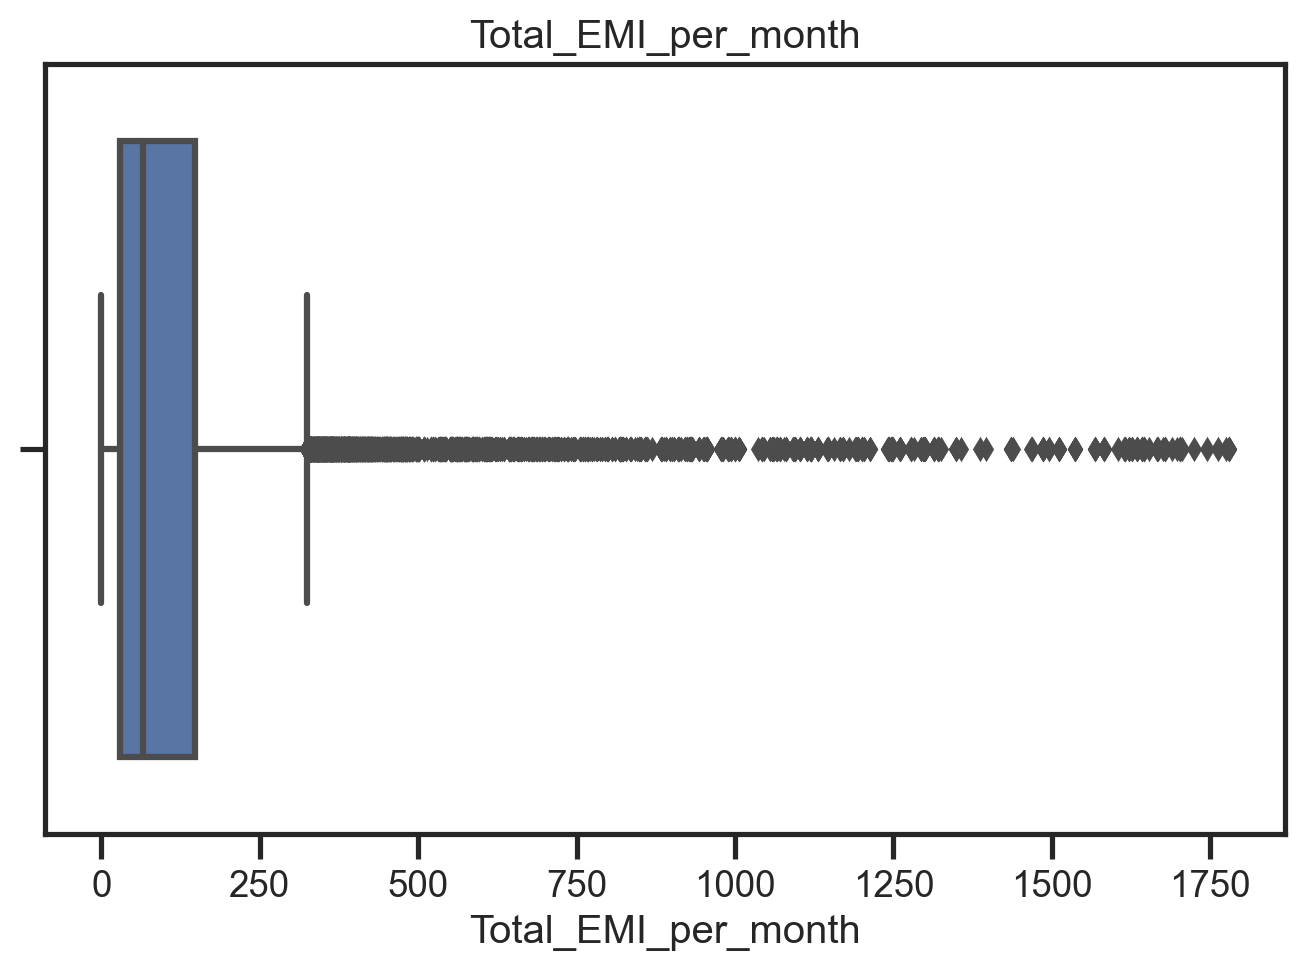

In [228]:
# Total EMI per month
plot_boxplot('Total_EMI_per_month')

In [229]:
df.query("Total_EMI_per_month>1000")[['Age','Occupation','Type_of_Loan','Annual_Income','Num_Bank_Accounts','Total_EMI_per_month']].sort_values(by='Total_EMI_per_month',ascending=False)[:20]

Age Occupation                                       Type_of_Loan  \
ID                                                                           
58846   51.0    Teacher   Payday Loan, Auto Loan,  Debt Consolidation Loan   
58848   51.0    Teacher   Payday Loan, Auto Loan,  Debt Consolidation Loan   
58849   52.0    Teacher   Payday Loan, Auto Loan,  Debt Consolidation Loan   
58847   51.0    Teacher   Payday Loan, Auto Loan,  Debt Consolidation Loan   
58845   51.0    Teacher   Payday Loan, Auto Loan,  Debt Consolidation Loan   
132505  37.0   Musician                                      Not Specified   
71316   15.0  Scientist  Payday Loan, Personal Loan, Mortgage Loan,  Au...   
112629  19.0  Scientist  Credit-Builder Loan, Debt Consolidation Loan, ...   
149072  20.0     Writer                                      Mortgage Loan   
35790   27.0  Architect                                      Not Specified   
132983  41.0     Lawyer  Home Equity Loan, Debt Consolidation Loan, Pay...   
73669   42.0  Architect                        Not Specified,  Payday Loan   
73668   41.0  Architect                        Not Specified,  Payday Loan   
73667   41.0  Architect                        Not Specified,  Payday Loan   
73666   41.0  Architect                        Not Specified,  Payday Loan   
73665   41.0  Architect                        Not Specified,  Payday Loan   
73664   41.0  Architect                        Not Specified,  Payday Loan   
73663   41.0  Architect                        Not Specified,  Payday Loan   
151410  31.0    Manager  Payday Loan, Personal Loan, Home Equity Loan, ...   
137869  31.0   Mechanic  Auto Loan, Debt Consolidation Loan, Credit-Bui...   

        Annual_Income  Num_Bank_Accounts  Total_EMI_per_month  
ID                                                             
58846     166891.7612                1.0          1779.103254  
58848     166891.7612                1.0          1779.103254  
58849     166891.7612                1.0          1779.103254  
58847     166891.7612                1.0          1779.103254  
58845     166891.7612                1.0          1779.103254  
132505    109655.2500                1.0          1775.000000  
71316      61707.7200               10.0          1762.000000  
112629      7423.9700                5.0          1745.000000  
149072     16994.6700                4.0          1724.000000  
35790      42796.5200                4.0          1705.000000  
132983      8089.4150                6.0          1702.000000  
73669     142001.1200                7.0          1701.955013  
73668     142001.1200                7.0          1701.955013  
73667     142001.1200                7.0          1701.955013  
73666     142001.1200                7.0          1701.955013  
73665     142001.1200                7.0          1701.955013  
73664     142001.1200                7.0          1701.955013  
73663     142001.1200                7.0          1701.955013  
151410     63675.8400               10.0          1698.000000  
137869     10277.1900                4.0          1689.000000

Outliers in `Total_EMI_per_month` wont' be removed because it doesn't really affect ones credit score


**NOTE** Insight was gotten from the EDA notebook

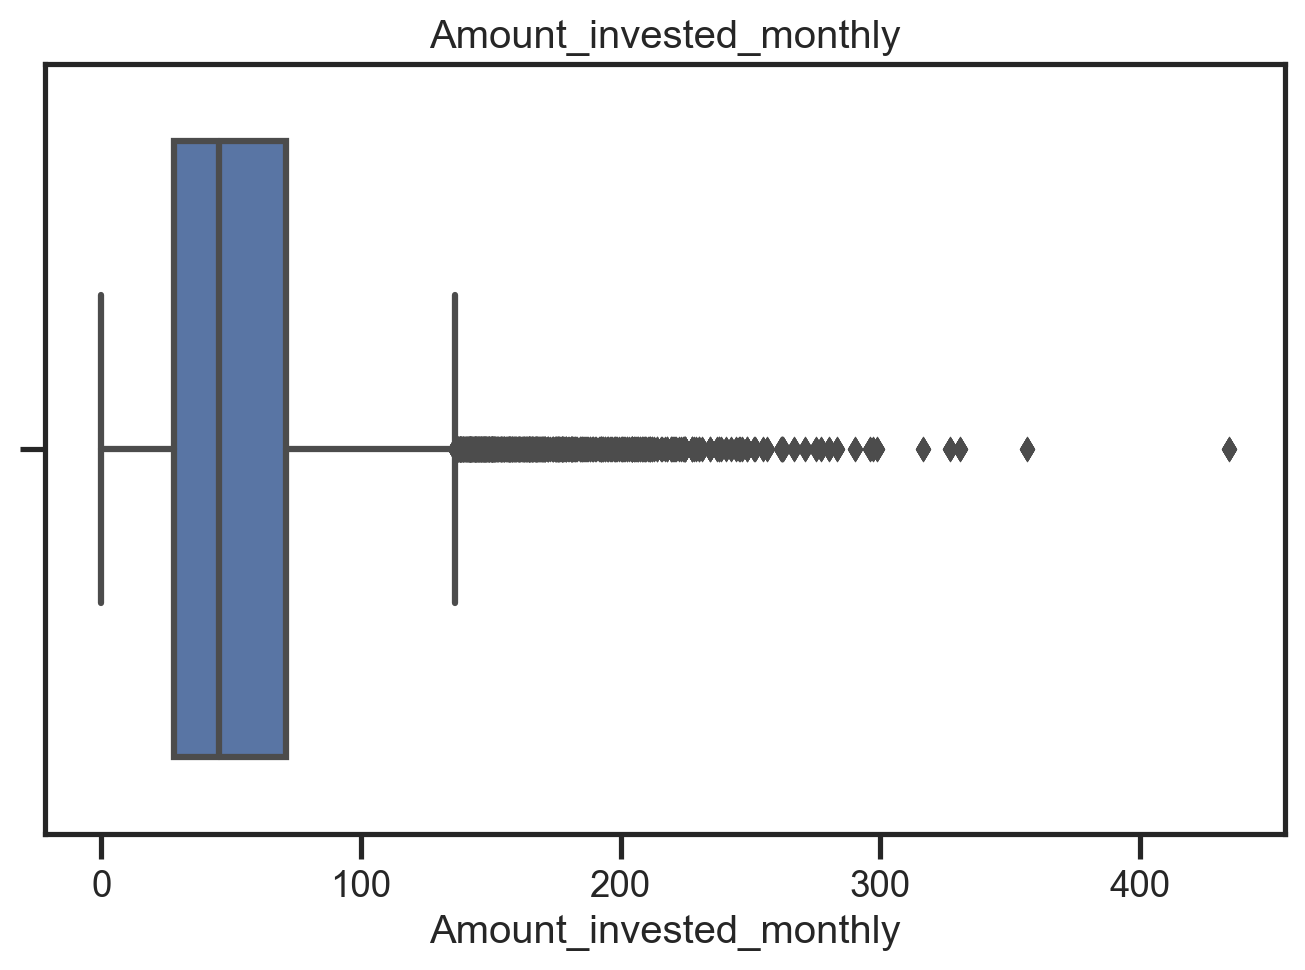

In [230]:
# Amount invested monthly
plot_boxplot('Amount_invested_monthly')

Amount invested monthly doesn't also seem to affect credit score that much. however, let's check the exception of that point above 400

In [231]:
df.query("Amount_invested_monthly>350")[['Annual_Income','Amount_invested_monthly']]

Annual_Income  Amount_invested_monthly
ID                                            
30738     136386.2000               434.191089
30739     136386.2000               434.191089
30740     136386.2000               434.191089
30741     136386.2000               434.191089
30742     136386.2000               434.191089
30743     136386.2000               434.191089
30744     136386.2000               434.191089
30745     136386.2000               434.191089
154026    166891.7612               356.550361
154027    166891.7612               356.550361
154028    166891.7612               356.550361
154029    166891.7612               356.550361
154030    166891.7612               356.550361
154031    166891.7612               356.550361
154032    166891.7612               356.550361
154033    166891.7612               356.550361

There should be a correlation between `Total EMI` and `Amount invested monthly`

In [232]:
df[['Amount_invested_monthly','Total_EMI_per_month']]

Amount_invested_monthly  Total_EMI_per_month
ID                                                  
5634                  21.465380            49.574949
5635                  21.465380            49.574949
5636                  21.465380            49.574949
5637                  21.465380            49.574949
5638                  21.465380            49.574949
...                         ...                  ...
155625                24.028477            35.104023
155626                24.028477            35.104023
155627                24.028477            35.104023
155628                24.028477            35.104023
155629                24.028477            35.104023

[100000 rows x 2 columns]

In [233]:
df['Amount_invested_monthly'].quantile(0.99)

192.40492171775415

In [236]:
df[df['Amount_invested_monthly']> df['Amount_invested_monthly'].quantile(0.99)].iloc[:,10:]

Changed_Credit_Limit  Num_Credit_Inquiries Credit_Mix  \
ID                                                              
5730                    8.24                   3.0       Good   
5731                    8.24                   3.0       Good   
5732                    8.24                   3.0       Good   
5733                    8.24                   8.0       Good   
5734                   11.24                   8.0       Good   
...                      ...                   ...        ...   
154485                  3.86                   2.0       Good   
154486                  5.86                   2.0       Good   
154487                  3.86                   2.0       Good   
154488                  3.86                   2.0       Good   
154489                  3.86                   2.0       Good   

        Outstanding_Debt  Credit_Utilization_Ratio  Credit_History_Age  \
ID                                                                       
5730             1377.74                 33.664554               256.0   
5731             1377.74                 27.626325               257.0   
5732             1377.74                 35.141567               258.0   
5733             1377.74                 30.459032               259.0   
5734             1377.74                 29.819187               260.0   
...                  ...                       ...                 ...   
154485           1075.47                 29.950395               326.0   
154486           1075.47                 37.124680               327.0   
154487           1075.47                 30.022752               328.0   
154488           1075.47                 29.728954               329.0   
154489           1075.47                 36.872445               330.0   

       Payment_of_Min_Amount  Total_EMI_per_month  Amount_invested_monthly  \
ID                                                                           
5730                      No           226.892792               212.235602   
5731                      NM           226.892792               212.235602   
5732                      NM           226.892792               212.235602   
5733                      No           226.892792               212.235602   
5734                      No           226.892792               212.235602   
...                      ...                  ...                      ...   
154485                    No           101.118773               219.562320   
154486                    NM           101.118773               219.562320   
154487                    No           101.118773               219.562320   
154488                    No           101.118773               219.562320   
154489                    No          1179.253921               219.562320   

                       Payment_Behaviour  Monthly_Balance  Credit_Score  \
ID                                                                        
5730     High_spent_Small_value_payments       802.300442             0   
5731     High_spent_Large_value_payments       785.258356             0   
5732     High_spent_Small_value_payments       547.108162             0   
5733     High_spent_Small_value_payments       772.411909             0   
5734     High_spent_Small_value_payments       367.684594             2   
...                                  ...              ...           ...   
154485  High_spent_Medium_value_payments       900.350775             0   
154486  High_spent_Medium_value_payments       782.473412             0   
154487    Low_spent_Small_value_payments       215.414136             0   
154488  High_spent_Medium_value_payments       302.957443             0   
154489  High_spent_Medium_value_payments       781.194032             2   

        CreditBuilder  Personal  DebtConsolidation  Student  Payday  Mortgage  \
ID                                                                              
5730                0         1               

In [237]:
# df = df.query('Amount_invested_monthly<350')
# df.shape

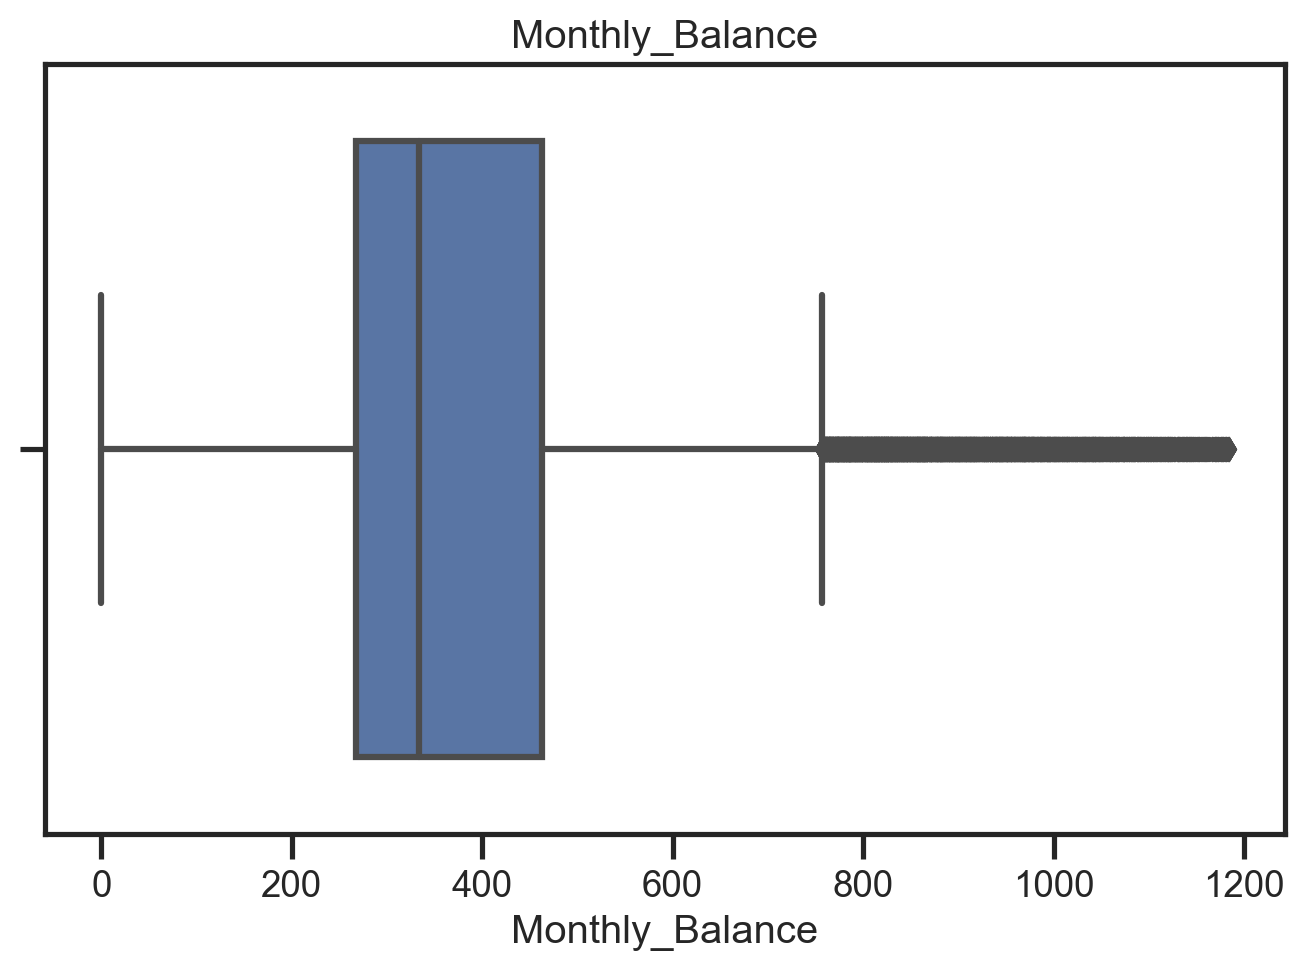

In [238]:
# monthly balance
plot_boxplot('Monthly_Balance')

In [239]:
df.columns

Index(['Month', 'Age', 'Occupation', 'Annual_Income', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score', 'CreditBuilder', 'Personal', 'DebtConsolidation',
       'Student', 'Payday', 'Mortgage', 'Auto', 'HomeEquity'],
      dtype='object')

In [240]:
(df.query('Monthly_Balance>770')
    [['Annual_Income','Amount_invested_monthly','Total_EMI_per_month','Credit_Mix','Monthly_Balance']]
    .sort_values(by='Monthly_Balance', ascending=False)
    ['Credit_Mix'].value_counts()
)

Good        4440
Standard    2527
Name: Credit_Mix, dtype: int64

In [241]:
(df.query('Monthly_Balance<770')
    [['Annual_Income','Amount_invested_monthly','Total_EMI_per_month','Credit_Mix','Monthly_Balance']]
    .sort_values(by='Monthly_Balance', ascending=False)
    ['Credit_Mix'].value_counts()
)

Standard    43321
Good        25944
Bad         23768
Name: Credit_Mix, dtype: int64

Having a high monthly balance in your account at the end of the month have a positive effect on your credit score.

### Outliers have been handles to the best of our knowledge and insights gotten from the data exploration

In [242]:
df.shape

(100000, 30)

In [244]:
# using the whole dataset
X, y = df[features].drop(columns=['Type_of_Loan']),df['Credit_Score']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=seed)

In [245]:
X_train.head()

Month   Age  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
ID                                                                       
94774       5  41.0      70154.850                8.0              5.0   
83569       8  54.0      29508.410                7.0              4.0   
100414      5  19.0      31346.220                8.0              5.0   
155051      6  32.0      64901.370                3.0              5.0   
92338       5  32.0       7200.035                8.0              8.0   

        Interest_Rate  Delay_from_due_date  Num_of_Delayed_Payment  \
ID                                                                   
94774            18.0                 27.0                     8.0   
83569             9.0                 18.0                    11.0   
100414           31.0                 44.0                    17.0   
155051           20.0                 15.0                    18.0   
92338            18.0                 60.0                    17.0   

        Changed_Credit_Limit  Num_Credit_Inquiries  ...  Credit_Mix  \
ID                                                  ...               
94774                  19.23                   0.0  ...    Standard   
83569                  10.75                   4.0  ...    Standard   
100414                  3.76                  12.0  ...         Bad   
155051                  2.94                   3.0  ...    Standard   
92338                   8.51                  11.0  ...    Standard   

        Payment_of_Min_Amount  CreditBuilder  Personal  DebtConsolidation  \
ID                                                                          
94774                     Yes              0         0                  0   
83569                      No              0         0                  0   
100414                    Yes              0         0                  0   
155051                    Yes              0         0                  0   
92338                     Yes              0         0                  0   

       Student Payday  Mortgage  Auto  HomeEquity  
ID                                                 
94774        0      0         0     1           0  
83569        0      1         0     0           0  
100414       1      0         0     0           0  
155051       0      0         0     0           0  
92338        0      0         0     0           1  

[5 rows x 25 columns]

In [246]:
preprocessor = preprocessor_pipe2() 
X_train_preprocessed3 = preprocessor.fit_transform(X_train)
X_test_preprocessed3 = preprocessor.transform(X_test)

Run the entire dataset (`X_train_preprocessed3`) on different models

In [247]:
result_whole3 = model_selection(X_train_preprocessed3, X_test_preprocessed3, y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26782
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 134
[LightGBM] [Info] Start training from score -1.729066
[LightGBM] [Info] Start training from score -1.236195
[LightGBM] [Info] Start training from score -0.630994


In [248]:
result_whole3.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc      acc  precision  \
1        random_forest     1.000000      0.821826  0.82575   0.826391   
4            extratree     1.000000      0.819814  0.82550   0.825770   
5                  xgb     0.869150      0.794489  0.79785   0.798650   
2             catboost     0.825275      0.772555  0.77955   0.780485   
6                 lgbm     0.794500      0.756954  0.76170   0.763919   
3          decisontree     1.000000      0.735385  0.75220   0.751787   
0  logistic_regression     0.685000      0.665395  0.68260   0.685034   

   time_taken  
1  114.395708  
4   39.432747  
5   12.611116  
2   88.402249  
6    8.972349  
3   16.385172  
0    8.910757

### Still retaining 66 features as the value for k in SelectKbest

In [249]:
selector = SelectKBest(f_classif, k=80).fit(X_train_preprocessed3, y_train)
X_sel = selector.transform(X_train_preprocessed3)
auto_select = pd.DataFrame(X_sel, columns=selector.get_feature_names_out()).columns

In [250]:
auto_select = auto_select.tolist()

In [251]:
result_selectkbest3 = model_selection(X_train_preprocessed3[auto_select], X_test_preprocessed3[auto_select], y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15781
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 80
[LightGBM] [Info] Start training from score -1.729066
[LightGBM] [Info] Start training from score -1.236195
[LightGBM] [Info] Start training from score -0.630994


In [252]:
result_selectkbest3.sort_values(by='precision',ascending=False)

model  train_score  balanced_acc      acc  precision  \
1        random_forest     0.999988      0.817247  0.82190   0.822441   
4            extratree     1.000000      0.814385  0.82040   0.820636   
5                  xgb     0.857225      0.784514  0.78880   0.789681   
2             catboost     0.819450      0.766200  0.77415   0.775135   
6                 lgbm     0.789088      0.752695  0.75795   0.760333   
3          decisontree     1.000000      0.726543  0.74330   0.743005   
0  logistic_regression     0.684312      0.663828  0.68135   0.683991   

   time_taken  
1   77.578136  
4   26.002488  
5    6.145737  
2   59.103814  
6    5.451922  
3    8.636177  
0    5.863699

In [254]:
def model_pipe(est):
    """ """
    pipe = Pipeline(
        steps=[
            ("pp", preprocessor_pipe2()),
            ("featsel", SelectKBest(f_classif, k=80)),
            ("classif", est)
        ]
    ).set_output(transform="pandas")

    return pipe
def evaluate(model):
    scores = []
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test) 
    train_score = model.score(X_train, y_train)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    scores.append({
        'model': model['classif'],
        'train_score':train_score,
        'balanced_acc':balanced_acc,
        'acc':acc,
        'precision':precision})

    return pd.DataFrame(scores,columns=['model','train_score','balanced_acc','acc','precision'])

# GridSearch

In [255]:
# Instantiate model
extra = model_pipe(ExtraTreesClassifier())

In [256]:
# Define the parameter grid
param_grid = {
    'classif__n_estimators': [100,150,200],
    'classif__max_depth': [5,10,15],
    'classif__min_samples_split': [2,4,6],
    'classif__min_samples_leaf': [1,3,5]
}
kf = KFold(n_splits=5, random_state=seed, shuffle=True)
grid_extra = GridSearchCV(extra, param_grid,scoring='balanced_accuracy',cv=kf, return_train_score=True)
grid_extra.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('poly_int',
                                                                                          PolynomialFeatures(include_bias=False,
                                                                                                             interaction_only=True)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Month',
                                                                          'Age',
                                                                          'Annual_Income',
                                                                          'Num_Bank_Accounts',
                                                                          'Num_Credit_Card',
                                                                          '...
                                                                                                        sparse_output=False))]),
                                                                         ['Credit_Mix',
                                                                          'Payment_of_Min_Amount'])],
                                                          verbose_feature_names_out=False)),
                                       ('featsel', SelectKBest(k=80)),
                                       ('classif', ExtraTreesClassifier())]),
             param_grid={'classif__max_depth': [5, 10, 15],
                         'classif__min_samples_leaf': [1, 3, 5],
                         'classif__min_samples_split': [2, 4, 6],
                         'classif__n_estimators': [100, 150, 200]},
             return_train_score=True, scoring='balanced_accuracy')

In [257]:
print("Best hyperparameters: ", grid_extra.best_params_)
print("Best score: ", grid_extra.best_score_)

Best hyperparameters:  {'classif__max_depth': 15, 'classif__min_samples_leaf': 1, 'classif__min_samples_split': 4, 'classif__n_estimators': 200}
Best score:  0.7632873440829322


In [259]:
# Extra trees model
extra = model_pipe(ExtraTreesClassifier(n_estimators=200, min_samples_leaf=1, min_samples_split=4, max_depth=15))
evaluate(extra)

model  train_score  \
0  (ExtraTreeClassifier(max_depth=15, min_samples...     0.832588   

   balanced_acc     acc  precision  
0      0.765262  0.7633   0.769843

### Random Forest Regression Model

In [260]:
# Instantiate model
rfc = model_pipe(RandomForestClassifier())

In [261]:
# Define the parameter grid
param_grid = {
    'classif__n_estimators':[100,150,200],
    'classif__min_samples_leaf':[1,3,5],
    'classif__min_samples_split':[2,4,6],
    'classif__max_depth': [5,10,15],
}
kf = KFold(n_splits=5, random_state=seed, shuffle=True)
grid_rfc = GridSearchCV(rfc, param_grid,scoring='balanced_accuracy',cv=kf, return_train_score=True)
grid_rfc.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('poly_int',
                                                                                          PolynomialFeatures(include_bias=False,
                                                                                                             interaction_only=True)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Month',
                                                                          'Age',
                                                                          'Annual_Income',
                                                                          'Num_Bank_Accounts',
                                                                          'Num_Credit_Card',
                                                                          '...
                                                                         ['Credit_Mix',
                                                                          'Payment_of_Min_Amount'])],
                                                          verbose_feature_names_out=False)),
                                       ('featsel', SelectKBest(k=80)),
                                       ('classif', RandomForestClassifier())]),
             param_grid={'classif__max_depth': [5, 10, 15],
                         'classif__min_samples_leaf': [1, 3, 5],
                         'classif__min_samples_split': [2, 4, 6],
                         'classif__n_estimators': [100, 150, 200]},
             return_train_score=True, scoring='balanced_accuracy')

In [262]:
print("Best hyperparameters: ", grid_rfc.best_params_)
print("Best score: ", grid_rfc.best_score_)

Best hyperparameters:  {'classif__max_depth': 15, 'classif__min_samples_leaf': 1, 'classif__min_samples_split': 4, 'classif__n_estimators': 200}
Best score:  0.7771452860635399


In [263]:
pd.DataFrame(grid_rfc.cv_results_,columns=['mean_test_score','mean_train_score','params',\
                                                  'rank_test_score']).sort_values(by='rank_test_score')

mean_test_score  mean_train_score  \
59         0.777145          0.868719   
58         0.776684          0.868531   
56         0.776366          0.873733   
55         0.776328          0.873224   
61         0.775270          0.861452   
..              ...               ...   
15         0.658876          0.662367   
14         0.658739          0.662565   
18         0.658695          0.662465   
6          0.657911          0.661714   
22         0.657611          0.659569   

                                               params  rank_test_score  
59  {'classif__max_depth': 15, 'classif__min_sampl...                1  
58  {'classif__max_depth': 15, 'classif__min_sampl...                2  
56  {'classif__max_depth': 15, 'classif__min_sampl...                3  
55  {'classif__max_depth': 15, 'classif__min_sampl...                4  
61  {'classif__max_depth': 15, 'classif__min_sampl...                5  
..                                                ...              ...  
15  {'classif__max_depth': 5, 'classif__min_sample...               77  
14  {'classif__max_depth': 5, 'classif__min_sample...               78  
18  {'classif__max_depth': 5, 'classif__min_sample...               79  
6   {'classif__max_depth': 5, 'classif__min_sample...               80  
22  {'classif__max_depth': 5, 'classif__min_sample...               81  

[81 rows x 4 columns]

In [264]:
# Random forest model
rfc = model_pipe(RandomForestClassifier(n_estimators=200, min_samples_leaf=1, min_samples_split=4, max_depth=15))
evaluate(rfc)

model  train_score  \
0  (DecisionTreeClassifier(max_depth=15, max_feat...        0.867   

   balanced_acc     acc  precision  
0      0.781512  0.7836   0.785759

In [265]:
ensembled = [extra, rfc]

In [266]:
# fit all models
for est in ensembled:
    est.fit(X_train, y_train)

In [267]:
ensemble = VotingClassifier([("extra",extra), ("rfc", rfc)])

In [268]:
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('extra',
                              Pipeline(steps=[('pp',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('num',
                                                                                Pipeline(steps=[('poly_int',
                                                                                                 PolynomialFeatures(include_bias=False,
                                                                                                                    interaction_only=True)),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['Month',
                                                                                 'Age',
                                                                                 'Annual_Income',
                                                                                 'Num_Bank_Accounts',
                                                                                 'Num_Credit_Card',
                                                                                 'Interest_Rate',
                                                                                 'Delay_from_due_date',...
                                                                                 'Amount_invested_monthly',
                                                                                 'Monthly_Balance']),
                                                                               ('cat',
                                                                                Pipeline(steps=[('ohe',
                                                                                                 OneHotEncoder(drop='if_binary',
                                                                                                               handle_unknown='infrequent_if_exist',
                                                                                                               sparse_output=False))]),
                                                                                ['Credit_Mix',
                                                                                 'Payment_of_Min_Amount'])],
                                                                 verbose_feature_names_out=False)),
                                              ('featsel', SelectKBest(k=80)),
                                              ('classif',
                                               RandomForestClassifier(max_depth=15,
                                                                      min_samples_split=4,
                                                                      n_estimators=200))]))])

In [269]:
all_regr = ensembled + [ ensemble ]
all_regr

[Pipeline(steps=[('pp',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num',
                                                   Pipeline(steps=[('poly_int',
                                                                    PolynomialFeatures(include_bias=False,
                                                                                       interaction_only=True)),
                                                                   ('scaler',
                                                                    StandardScaler())]),
                                                   ['Month', 'Age',
                                                    'Annual_Income',
                                                    'Num_Bank_Accounts',
                                                    'Num_Credit_Card',
                                                    'Interest_Rate',
                                         

In [270]:
for est in all_regr:
    kf = KFold(n_splits=5, random_state=seed, shuffle=True)
    scores = cross_val_score(est, X_train, y_train, cv=kf, scoring='balanced_accuracy')
    print(scores.mean(), scores.std())

0.7623287268209137 0.005265177394924036
0.7769572038393303 0.004540408371507839
0.7750631941820048 0.005242121692879609


Voting Ensembled model happens to be the best performing model

### Voting Classifier

In [271]:
predictions = ensemble.predict(X_test)
print(f"accuracy_score {accuracy_score(y_test, predictions)}")
print(f"balanced accuracy_score {balanced_accuracy_score(y_test, predictions)}")
print(f"precision_score {precision_score(y_test, predictions, average='macro')}")

accuracy_score 0.769
balanced accuracy_score 0.7773945539163063
precision_score 0.7466650492278132


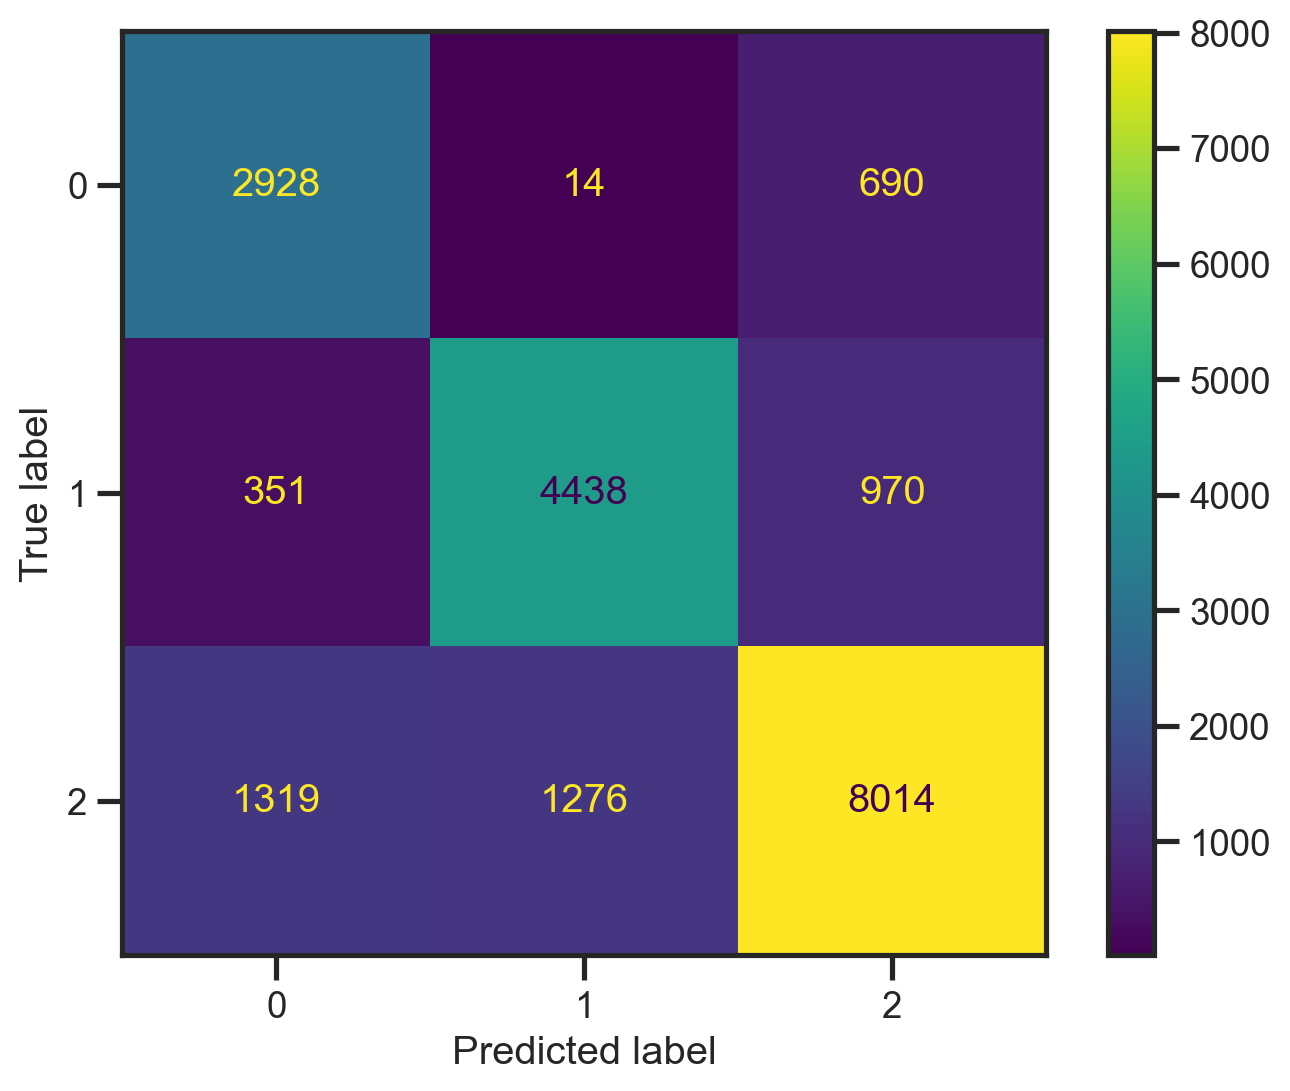

In [272]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()

In [273]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.64      0.81      0.71      3632
           1       0.77      0.77      0.77      5759
           2       0.83      0.76      0.79     10609

    accuracy                           0.77     20000
   macro avg       0.75      0.78      0.76     20000
weighted avg       0.78      0.77      0.77     20000



### ExtraTree Classifier

In [274]:
predictions = extra.predict(X_test)
print(f"accuracy_score {accuracy_score(y_test, predictions)}")
print(f"balanced accuracy_score {balanced_accuracy_score(y_test, predictions)}")
print(f"precision_score {precision_score(y_test, predictions, average='macro')}")

accuracy_score 0.76235
balanced accuracy_score 0.7637598427816074
precision_score 0.7422708852455822


In [275]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()

In [276]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.64      0.79      0.71      3632
           1       0.78      0.74      0.76      5759
           2       0.81      0.77      0.79     10609

    accuracy                           0.76     20000
   macro avg       0.74      0.76      0.75     20000
weighted avg       0.77      0.76      0.76     20000



### Random Forest Classifier

In [277]:
predictions = rfc.predict(X_test)
print(f"accuracy_score {accuracy_score(y_test, predictions)}")
print(f"balanced accuracy_score {balanced_accuracy_score(y_test, predictions)}")
print(f"precision_score {precision_score(y_test, predictions, average='macro')}")

accuracy_score 0.7848
balanced accuracy_score 0.7825865169241587
precision_score 0.768313275613267


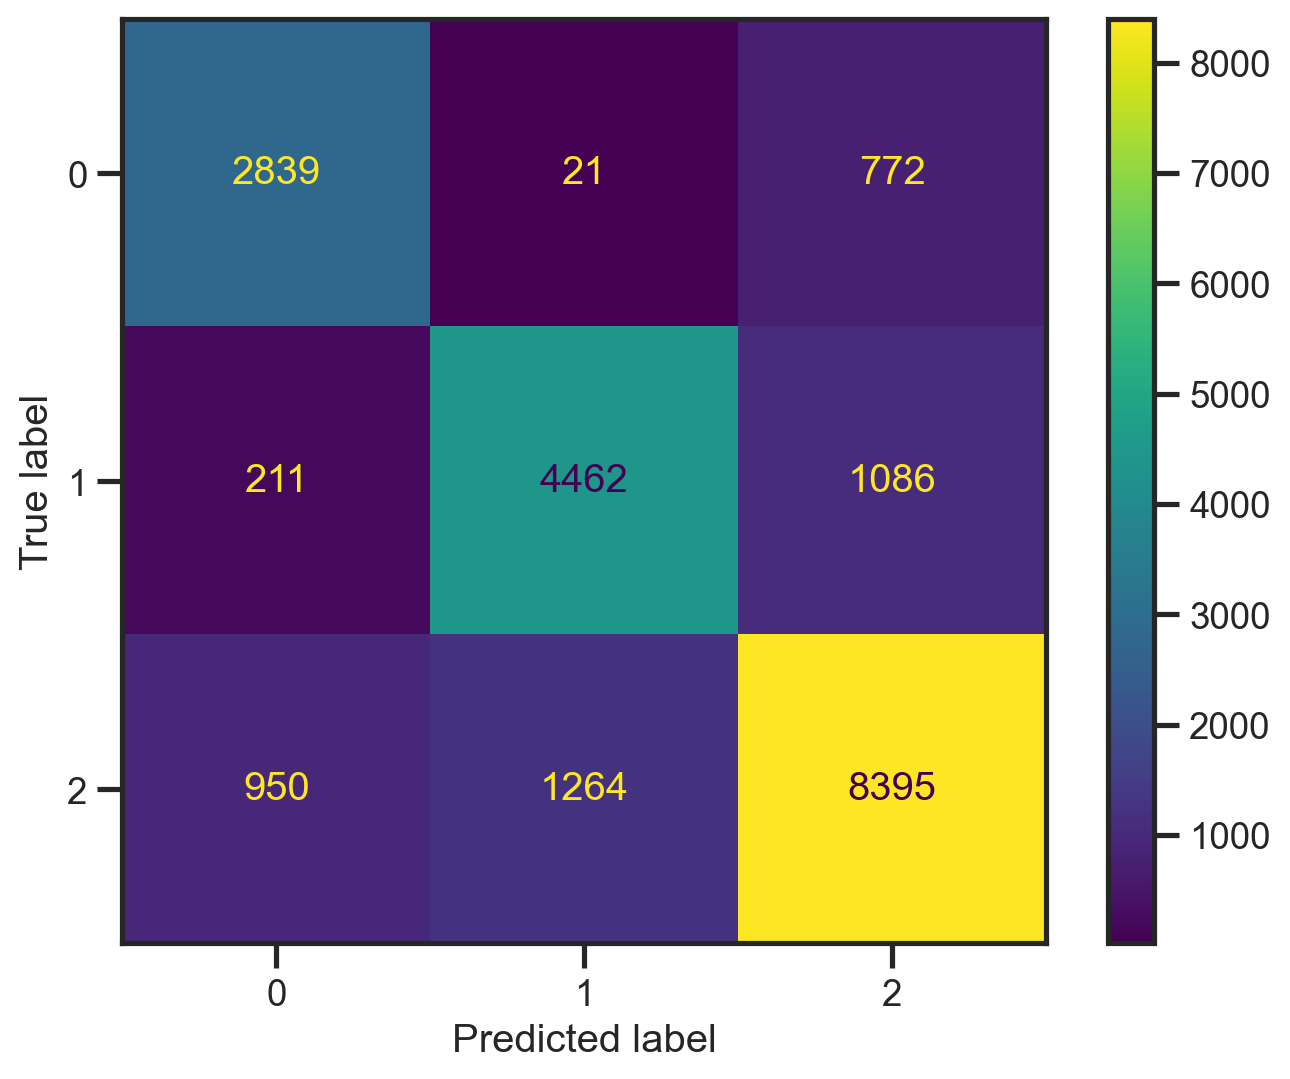

In [278]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()

In [279]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      3632
           1       0.78      0.77      0.78      5759
           2       0.82      0.79      0.80     10609

    accuracy                           0.78     20000
   macro avg       0.77      0.78      0.77     20000
weighted avg       0.79      0.78      0.79     20000



In [285]:
target = {"2":"Standard","1":"Poor","0":"Good"}
target        

{'2': 'Standard', '1': 'Poor', '0': 'Good'}

In [286]:
y.value_counts()

2    53174
1    28998
0    17828
Name: Credit_Score, dtype: int64

In [292]:
target = pd.Series(rfc.predict(X_test), name="Target")

In [320]:
results = pd.concat([X_test.reset_index(), y_test.reset_index(),target], axis=1).drop(columns=['ID','ID'])

In [322]:
results.query("Credit_Score==0 & Target != 0")

Month   Age  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  \
21         8  42.0       20460.96               10.0              8.0   
62         2  33.0       88640.24                3.0              6.0   
66         7  28.0       13180.99                5.0              4.0   
82         5  37.0       16480.50                8.0              6.0   
84         7  21.0      120479.64                2.0              7.0   
...      ...   ...            ...                ...              ...   
19873      4  54.0       65869.24                1.0              7.0   
19956      7  51.0       76353.40                0.0              6.0   
19960      7  54.0       65869.24                1.0              7.0   
19969      8  32.0       69073.65                6.0              7.0   
19970      8  29.0       21298.53                4.0              5.0   

       Interest_Rate  Delay_from_due_date  Num_of_Delayed_Payment  \
21              31.0                 57.0                    19.0   
62               1.0                  4.0                     2.0   
66              12.0                 13.0                    15.0   
82              16.0                 11.0                    11.0   
84               8.0                 17.0                     4.0   
...              ...                  ...                     ...   
19873           10.0                  5.0                     4.0   
19956            4.0                 10.0                     5.0   
19960           10.0                  1.0                     3.0   
19969            7.0                 20.0                    10.0   
19970           17.0                 12.0                    19.0   

       Changed_Credit_Limit  Num_Credit_Inquiries  ...  CreditBuilder  \
21                    27.98                  11.0  ...              0   
62                     3.51                   3.0  ...              0   
66                     9.94                   6.0  ...              0   
82                    12.82                   7.0  ...              0   
84                     6.98                   8.0  ...              0   
...                     ...                   ...  ...            ...   
19873                  4.20                   2.0  ...              0   
19956                  1.97                   8.0  ...              0   
19960                  5.20                   2.0  ...              0   
19969                 16.31                  10.0  ...              0   
19970                  4.69                   0.0  ...              0   

       Personal  DebtConsolidation  Student  Payday Mortgage Auto  HomeEquity  \
21            0                  0        0       0        1    0           0   
62            0                  0        0       1        0    0           0   
66            0                  0        0       0        0    0           0   
82            0                  0        0       0        1    0           0   
84            0                  0        0       0        0    0           0   
...         ...                ...      ...     ...      ...  ...         ...   
19873         0                  0        1       0        0    0           0   
19956         0                  0        0       1        0    0           0   
19960         0                  0        1       0        0    0           0   
19969         0                  0        0       0        1    0           0   
19970         0                  0        0       0        0    0           0   

       Credit_Score  Target  
21                0       2  
62                0       2  
66                0       2  
82                0       2  
84                0       1  
...             ...     ...  
19873             0       2  
19956             0       2  
19960             0       2  
19969             0       2  
19970             0       2  

[793 rows x 27 columns]